# **U.S. Small Business Administration (SBA) Loan Default Analysis & Prediction**

## **Dataset Source**

https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied

## **1. Business Problem**

With the help of SBA, small businesses across USA are able to get a guarantee part of the loan the apply to, mitigating risk from the business owner(s) side and handing over to the SBA.

However, the default rate of 899,164 applied business loans is still high at 21.5%.


## **2. Objectives**

1. Risk Reduction: Identify and minimize the approval of high-risk loans to reduce the incidence of defaults and associated financial losses via model prediction.
2. Identify factors that highly correlates to the loan being defaulted.

## **3. Environment Setup**

### **3.1. Import Libraries**

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

# Statistical analysis
from scipy import stats
from scipy.stats import f_oneway, ttest_ind, chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

# Preprocessing and feature selection
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, classification_report, precision_recall_curve

# Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


## **4. Helper Functions**

### **4.1 Data Information Checker**

In [ ]:
def data_info(data) :
    pd.set_option('display.max_rows',None)
    missing_values = data.isnull().sum()
    missing_perc = (missing_values/len(data))*100
    data_type = data.dtypes
    num_unique = data.nunique()

    print (f'Rows,Columns {data.shape}')
    print (f'Duplicated Values {data.duplicated().sum()}')
    print('=====\n')

    check_df = pd.DataFrame ({'missingValue' : missing_values,
                          'percentMissing' : missing_perc,
                          'DataType' : data_type,
                          'Unique' : num_unique}).sort_values('percentMissing',ascending=False)

    return check_df

### **4.2. Outlier Box Plot**

In [ ]:
def outlier_plot(data, features):
  plt.figure(figsize=(20,15))

  rows = 3
  cols = (len(features) + rows - 1) // rows

  palette = sns.color_palette("crest", len(features))

  for i in range(len(features)):
      plt.subplot(rows, cols, i + 1)
      sns.boxplot(x=[i] * len(data), y=data[features[i]], palette=[palette[i]])
      plt.title(features[i])
      plt.tight_layout()

  plt.show()


### **4.3 Modeling**

In [ ]:
def eval_model(X_train, y_train, X_test, y_test, model):
    model.fit(X=X_train, y=y_train)
    pred = model.predict(X_test)
    pred_probas = model.predict_proba(X_test)

    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    # Classification report
    print('Classification Report: \n', classification_report(y_test, pred, digits=3))
    print('='*100)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix
    disp.plot(ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # ROC Curve
    skplt.metrics.plot_roc(y_test, pred_probas, ax=axes[1])
    axes[1].set_title('ROC Curve')

    # Precision-Recall Curve
    skplt.metrics.plot_precision_recall(y_test, pred_probas, ax=axes[2])
    axes[2].set_title('Precision-Recall Curve')

    plt.tight_layout()
    plt.show()


## **5. Data Preprocessing (EDA)**

### **5.1 Data Check, Missing Values, Duplicates**

In [ ]:
# First read of the dataset given.

loans = pd.read_csv('./dataset/SBAnational.csv')

loans_copy = loans.copy()

In [ ]:
loans.head(3)

LoanNr_ChkDgt                         Name         City State    Zip  \
0     1000014003               ABC HOBBYCRAFT   EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)    NEW PARIS    IN  46526   
2     1000034009        WHITLOCK DDS, TODD M.  BLOOMINGTON    IN  47401   

                      Bank BankState   NAICS ApprovalDate ApprovalFY  ...  \
0         FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...   
1          1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...   
2  GRANT COUNTY STATE BANK        IN  621210    28-Feb-97       1997  ...   

   RevLineCr  LowDoc  ChgOffDate  DisbursementDate  DisbursementGross  \
0          N       Y         NaN         28-Feb-99        $60,000.00    
1          N       Y         NaN         31-May-97        $40,000.00    
2          N       N         NaN         31-Dec-97       $287,000.00    

   BalanceGross  MIS_Status ChgOffPrinGr        GrAppv      SBA_Appv  
0        $0.00        P I F       $0.00    $60,000.00    $48,000.00   
1        $0.00        P I F       $0.00    $40,000.00    $32,000.00   
2        $0.00        P I F       $0.00   $287,000.00   $215,250.00   

[3 rows x 27 columns]

In [ ]:
# Show data values: rows, columns, duplicates, missing values, data types, and how many unique data are there.
data_info(loans_copy)

Rows,Columns (899164, 27)
Duplicated Values 0
=====



missingValue  percentMissing DataType  Unique
ChgOffDate               736465       81.905526   object    6448
RevLineCr                  4528        0.503579   object      18
LowDoc                     2582        0.287156   object       8
DisbursementDate           2368        0.263356   object    8472
MIS_Status                 1997        0.222095   object       2
BankState                  1566        0.174162   object      56
Bank                       1559        0.173383   object    5802
NewExist                    136        0.015125  float64       3
City                         30        0.003336   object   32581
State                        14        0.001557   object      51
Name                         14        0.001557   object  779583
LoanNr_ChkDgt                 0        0.000000    int64  899164
GrAppv                        0        0.000000   object   22128
ChgOffPrinGr                  0        0.000000   object   83165
BalanceGross                  0        0.000000   object      15
DisbursementGross             0        0.000000   object  118859
CreateJob                     0        0.000000    int64     246
UrbanRural                    0        0.000000    int64       3
FranchiseCode                 0        0.000000    int64    2768
RetainedJob                   0        0.000000    int64     358
NoEmp                         0        0.000000    int64     599
Term                          0        0.000000    int64     412
ApprovalFY                    0        0.000000   object      70
ApprovalDate                  0        0.000000   object    9859
NAICS                         0        0.000000    int64    1312
Zip                           0        0.000000    int64   33611
SBA_Appv                      0        0.000000   object   38326

**Observation**

1. `899164` total data rows, with `27` columns.
2. No duplicate values.

3. The `ChgOffDate` variable has a significant amount of missing values, accounting for 81% of the dataset. According to the dataset description, this variable represents the date a loan is declared in default. Therefore, the missing values likely indicate that these loans are still active, and as a result, NaN values are present. It seems to be out of my concern due to the fact that we're focused on whether or not the loan gets charged off or not.
4. There seems to be some missing data that may pose issues, I decided to remove the rows completely since we have a lot of data left to work with. After that I can further analyze which features stand out.

In [ ]:
# Drop null values from specified columns
loans_copy.dropna(subset=['Name', 'City', 'State', 'BankState', 'NewExist','RevLineCr', 'LowDoc', 'DisbursementDate', 'MIS_Status'], inplace=True)

In [ ]:
data_info(loans_copy)

Rows,Columns (886240, 27)
Duplicated Values 0
=====



missingValue  percentMissing DataType  Unique
ChgOffDate               725369       81.847919   object    6425
LoanNr_ChkDgt                 0        0.000000    int64  886240
RetainedJob                   0        0.000000    int64     356
GrAppv                        0        0.000000   object   21922
ChgOffPrinGr                  0        0.000000   object   82645
MIS_Status                    0        0.000000   object       2
BalanceGross                  0        0.000000   object      15
DisbursementGross             0        0.000000   object  117753
DisbursementDate              0        0.000000   object    8435
LowDoc                        0        0.000000   object       8
RevLineCr                     0        0.000000   object      18
UrbanRural                    0        0.000000    int64       3
FranchiseCode                 0        0.000000    int64    2754
CreateJob                     0        0.000000    int64     246
Name                          0        0.000000   object  769838
NewExist                      0        0.000000  float64       3
NoEmp                         0        0.000000    int64     597
Term                          0        0.000000    int64     411
ApprovalFY                    0        0.000000   object      64
ApprovalDate                  0        0.000000   object    9786
NAICS                         0        0.000000    int64    1311
BankState                     0        0.000000   object      56
Bank                          0        0.000000   object    5788
Zip                           0        0.000000    int64   33501
State                         0        0.000000   object      51
City                          0        0.000000   object   32298
SBA_Appv                      0        0.000000   object   37935

Next I want to check if each field is appropriate to the data type given.

In [ ]:
# Check each column for unique data
df_columns = loans_copy.columns.tolist()
for column in df_columns:
    print(f"{column} : {loans_copy[column].unique()}\n")

LoanNr_ChkDgt : [1000014003 1000024006 1000034009 ... 9995613003 9995973006 9996003010]

Name : ['ABC HOBBYCRAFT' 'LANDMARK BAR & GRILLE (THE)' 'WHITLOCK DDS, TODD M.'
 ... 'RADCO MANUFACTURING CO.,INC.' 'MARUTAMA HAWAII, INC.'
 'PACIFIC TRADEWINDS FAN & LIGHT']

City : ['EVANSVILLE' 'NEW PARIS' 'BLOOMINGTON' ... 'MURFRECSBORO' 'E WENALCHEE'
 'SO. OZONE PARK']

State : ['IN' 'OK' 'FL' 'CT' 'NJ' 'NC' 'IL' 'RI' 'TX' 'VA' 'TN' 'AR' 'MN' 'MO'
 'MA' 'CA' 'SC' 'LA' 'IA' 'OH' 'KY' 'MS' 'NY' 'MD' 'PA' 'OR' 'ME' 'KS'
 'MI' 'AK' 'WA' 'CO' 'MT' 'WY' 'UT' 'NH' 'WV' 'ID' 'AZ' 'NV' 'WI' 'NM'
 'GA' 'ND' 'VT' 'AL' 'NE' 'SD' 'HI' 'DE' 'DC']

Zip : [47711 46526 47401 ... 70036 66549 26134]

Bank : ['FIFTH THIRD BANK' '1ST SOURCE BANK' 'GRANT COUNTY STATE BANK' ...
 'FIRST ILLINOIS BANK' 'COLORADO COMMUNITY FIRST STATE' 'DEPCO']

BankState : ['OH' 'IN' 'OK' 'FL' 'DE' 'SD' 'AL' 'CT' 'GA' 'OR' 'MN' 'RI' 'NC' 'TX'
 'MD' 'NY' 'TN' 'SC' 'MS' 'MA' 'LA' 'IA' 'VA' 'CA' 'IL' 'KY' 'PA' 'MO'
 'WA' 'MI' 'UT' 'KS' 'W

### **5.2 Feature Engineering**

I can see that `ApprovalFY` should be integer but there is an issue where one of the data has A in it. I clean the text.

In [ ]:
# Define a function to clean the string from integer data
def clean_data_str(value):
    if isinstance(value, str):
        return value.replace('A', '')
    return value

loans_copy['ApprovalFY'] = loans_copy['ApprovalFY'].apply(clean_data_str).astype('int64')

I can also see that currencies in this dataset are declared as objects rather than float. It may be because of the '$' and commas are included. I will modify the data and change it to float appropriately.

In [ ]:
# Remove '$', commas, and extra spaces from records in columns with dollar values that should be floats

loans_copy[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = \
loans_copy[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

In [ ]:
# Reconfigure remaining data into appropriate data types.
# Here i change data types of Zip, NewExist, UrbanRural and all currency types to the appropriate data types.
loans_copy = loans_copy.astype({
    'Zip': 'str',
    'NewExist': 'int64',
    'UrbanRural': 'str',
    'DisbursementGross' : 'float64',
    'BalanceGross' : 'float64',
    'ChgOffPrinGr' : 'float64',
    'GrAppv' : 'float64',
    'SBA_Appv' : 'float64'
    })

Next, we can see that NAICS can be seperated into two columns, where the first two digits of NAICS correlates to the business sector with an active loan.

In [ ]:
# Mapping dictionary for NAICS codes
naics_mapping = {
    '11': 'Agri/For/Fish/Hunt', # 'Agriculture, forestry, fishing and hunting',
    '21': 'Min/Quar/Oil/Gas_ext', # 'Mining, quarrying, and oil and gas extraction',
    '22': 'Utilities', # 'Utilities',
    '23': 'Construction', # 'Construction',
    '31': 'Manufacturing', # 'Manufacturing',
    '32': 'Manufacturing', # 'Manufacturing',
    '33': 'Manufacturing', # 'Manufacturing',
    '42': 'Wholesale_trade', # 'Wholesale trade',
    '44': 'Retail_trade', # 'Retail trade',
    '45': 'Retail_trade', # 'Retail trade',
    '48': 'Transp/WareH', # 'Transportation and warehousing',
    '49': 'Transp/WareH', # 'Transportation and warehousing',
    '51': 'Info', # 'Information',
    '52': 'Finance/Insurance', # 'Finance and insurance',
    '53': 'Real_est/Rental/Lease', # 'Real estate and rental and leasing',
    '54': 'Prof/Science/Tech', # 'Professional, scientific, and technical services',
    '55': 'Mgmt_comp_entp', # 'Management of companies and enterprises',
    '56': 'Admin/Supp/WasteM/Remed', # 'Administrative and support and waste management and remediation services',
    '61': 'Edu', # 'Educational services',
    '62': 'Health/Social', # 'Health care and social assistance',
    '71': 'Art/Entr/Rec', # 'Arts, entertainment, and recreation',
    '72': 'Accom/Food', # 'Accommodation and food services',
    '81': 'Other', # 'Other services (except public administration)',
    '92': 'Pub_Admin', # 'Public administration'
}

# Function to map NAICS codes to sectors (created two, one for Industry Sector text and one for Industry Code)
loans_copy['Industry'] = loans_copy['NAICS'].astype('str').apply(lambda x: x[:2])
loans_copy['IndustryCode'] = loans_copy['NAICS'].astype('str').apply(lambda x: x[:2])

# map Industry code based on mapping
loans_copy['Industry'] = loans_copy['Industry'].map(naics_mapping)

# Remove records where Industry is NaN (NAICS code was a 0)
loans_copy.dropna(subset=['Industry'], inplace=True)


In [ ]:
loans_copy[['NAICS','Industry']].head()

NAICS       Industry
0  451120   Retail_trade
1  722410     Accom/Food
2  621210  Health/Social
5  332721  Manufacturing
7  811118          Other

Next I want to highlight on `NewExist` where the data only says it has 1 = Existing business, and 2 = New business, so we filter out data that has NewExist of 0.

In [ ]:
loans_copy = loans_copy[(loans_copy['NewExist'] == 1) | (loans_copy['NewExist'] == 2)]

# I then create a new column where NewBusiness = 0 is an existing business, and NewBusiness = 1 is a new business
loans_copy.loc[(loans_copy['NewExist'] == 1), 'NewBusiness'] = 0
loans_copy.loc[(loans_copy['NewExist'] == 2), 'NewBusiness'] = 1

Next, I want to address `RevLineCr` and `LowDoc` which has multiple datas outside of the needed ones which are only Y and N

In [ ]:
print(loans_copy['RevLineCr'].unique())
print(loans_copy['LowDoc'].unique())

['N' 'Y' '0' 'T' '`' ',' '1' 'C' '2' 'R' '7' 'A' '-' 'Q']
['Y' 'N' 'C' '1' 'S' 'R' 'A' '0']


In [ ]:
# Temove records where RevLineCr != Y or N and LowDoc != Y or N
loans_copy = loans_copy[(loans_copy['RevLineCr'] == 'Y') | (loans_copy['RevLineCr'] == 'N')]
loans_copy = loans_copy[(loans_copy['LowDoc'] == 'Y') | (loans_copy['LowDoc'] == 'N')]

# Transform data to int
loans_copy['RevLineCr'] = loans_copy['RevLineCr'].replace(['N' ,'Y'],[0,1])
loans_copy['LowDoc'] = loans_copy['LowDoc'].replace(['N' ,'Y'],[0,1])

print(loans_copy['RevLineCr'].unique())
print(loans_copy['LowDoc'].unique())

[0 1]
[1 0]


In [ ]:
# Created a flag for FranchiseCode = IsFranchise
loans_copy.loc[(loans_copy['FranchiseCode'] <= 1), 'IsFranchise'] = 0
loans_copy.loc[(loans_copy['FranchiseCode'] > 1), 'IsFranchise'] = 1

In [ ]:
# Convert ApprovalDate and DisbursementDate columns to datetime values
# ChgOffDate not changed to datetime since it is not relevant to the analysis since it only states when the approval is charged off and will be removed later

loans_copy[['ApprovalDate', 'DisbursementDate']] = loans_copy[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)

I'm interested in measuring the time elapsed between loan approval and fund disbursement as a potential metric. My hypothesis suggest that longer waiting times for fund disbursement could negatively impact a business's loan repayment ability, for example if they are in a tight cycle of funds.

In [ ]:
# Create DaysToDisbursement column calculating days between DisbursementDate and ApprovalDate
loans_copy['DaysToDisbursement'] = (loans_copy['DisbursementDate'] - loans_copy['ApprovalDate']).dt.days

# Convert DaysToDisbursement to int64 dtype
loans_copy['DaysToDisbursement'] = loans_copy['DaysToDisbursement'].astype('int64')

# Create DisbursementMonth & DisbursementYear field for time analysis later (Great Recession categorizing)
loans_copy['DisbursementMonth'] = loans_copy['DisbursementDate'].map(lambda x: x.month)
loans_copy['DisbursementYear'] = loans_copy['DisbursementDate'].map(lambda x: x.year)

I'm also interested in investigating whether the bank servicing the loan is located in the same state as the business. My hypothesis suggests that servicing a loan from a different state could pose challenges that might negatively affect the business's loan repayment capability.

In [ ]:
# Create StateSame flag field which identifies where the business State is the same as the BankState
loans_copy['StateSame'] = np.where(loans_copy['State'] == loans_copy['BankState'], 1, 0)

Based on [sba-loans-guarantees](https://www.wolterskluwer.com/en/expert-insights/sba-loan-guarantees), I can see that SBA will guarantee a loan even if it is at a loss. This can be really tempting for Small Business Owners to take a loan from the SBA because it may mitigate their risk but it will increase the risks for SBA. These loans are typically based on percentage, so I created a feature to accomodate that.

In [ ]:
# Percent = SBA_Appv / GrAppv

loans_copy['SBA_AppvPercent'] = loans_copy['SBA_Appv'] / loans_copy['GrAppv']

A good indicator is also seeing if the loan amount disbursed was equal to the full amount approved.

In [ ]:
# Create AppvDisbursed flag field signifying if the loan amount disbursed was equal to the full amount approved
loans_copy['AppvDisbursed'] = np.where(loans_copy['DisbursementGross'] == loans_copy['GrAppv'], 1, 0)

Finally, based on the paper attached to this dataset, there are 2 key informations that I need to consider:
1. Loans that are backed by Real Estate
2. Economic Recession as a Risk Indicator (December 2007 to June 2009)

Based on these two informations, I created two features

In [ ]:
# Field for loans backed by Real Estate (loans with a term of at least 20 years)
loans_copy['RealEstate'] = np.where(loans_copy['Term'] >= 240, 1, 0)


# Column for loans through economic recession
loans_copy['GreatRecession'] = np.where(
    (
        (loans_copy['DisbursementYear'] == 2007) & (loans_copy['DisbursementMonth'] >= 12) |
        (loans_copy['DisbursementYear'] == 2008) |
        (loans_copy['DisbursementYear'] == 2009) & (loans_copy['DisbursementMonth'] <= 6)
    ),
    1,0)

`IsFranchise` and `NewBusiness` need to change data types to int64

In [ ]:
loans_copy = loans_copy.astype({
    'IsFranchise': 'int64',
    'NewBusiness': 'int64'
    })

Next I will replace text in MIS_Status to int

In [ ]:
# Create a new `Default` column to represent MIS_Status where P I F = 0 and CHGOFF = 1
loans_copy['Default'] = np.where(loans_copy['MIS_Status'] == 'P I F', 0, 1)

In [ ]:
print(loans_copy['Default'].value_counts())

Default
0    358558
1     98382
Name: count, dtype: int64


Defaulted loans looks to be not evenly matched with the total data of non-defaulted loans. I will look into this later.

In [ ]:
data_info(loans_copy)

Rows,Columns (456940, 40)
Duplicated Values 0
=====



missingValue  percentMissing        DataType  Unique
ChgOffDate                355763       77.857706          object    4739
DisbursementGross              0        0.000000         float64  100863
BalanceGross                   0        0.000000         float64       8
MIS_Status                     0        0.000000          object       2
ChgOffPrinGr                   0        0.000000         float64   53232
GrAppv                         0        0.000000         float64   12785
SBA_Appv                       0        0.000000         float64   22219
Industry                       0        0.000000          object      20
IndustryCode                   0        0.000000          object      24
NewBusiness                    0        0.000000           int64       2
LoanNr_ChkDgt                  0        0.000000           int64  456940
DaysToDisbursement             0        0.000000           int64    2230
DisbursementMonth              0        0.000000           int64      12
DisbursementYear               0        0.000000           int64      32
StateSame                      0        0.000000           int64       2
SBA_AppvPercent                0        0.000000         float64    5720
AppvDisbursed                  0        0.000000           int64       2
RealEstate                     0        0.000000           int64       2
GreatRecession                 0        0.000000           int64       2
IsFranchise                    0        0.000000           int64       2
DisbursementDate               0        0.000000  datetime64[ns]    5117
Name                           0        0.000000          object  417430
ApprovalFY                     0        0.000000           int64      29
City                           0        0.000000          object   25166
State                          0        0.000000          object      51
Zip                            0        0.000000          object   26898
Bank                           0        0.000000          object    4832
BankState                      0        0.000000          object      54
NAICS                          0        0.000000           int64    1304
ApprovalDate                   0        0.000000  datetime64[ns]    7314
Term                           0        0.000000           int64     373
LowDoc                         0        0.000000           int64       2
NoEmp                          0        0.000000           int64     432
NewExist                       0        0.000000           int64       2
CreateJob                      0        0.000000           int64     192
RetainedJob                    0        0.000000           int64     276
FranchiseCode                  0        0.000000           int64    1691
UrbanRural                     0        0.000000          object       3
RevLineCr                      0        0.000000           int64       2
Default                        0        0.000000           int64       2

## **6. Exploratory Data Analysis**

### **6.1 Descriptive Statistics**

In [ ]:
# List of numerical features
feat_num = [
    'NewBusiness', 'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr',
    'GrAppv', 'SBA_Appv', 'DaysToDisbursement', 'DisbursementMonth',
    'DisbursementYear', 'SBA_AppvPercent', 'ApprovalFY', 'Term', 'NoEmp',
    'CreateJob', 'RetainedJob', 'IsFranchise', 'StateSame', 'RealEstate',
    'Default', 'LowDoc', 'RevLineCr', 'GreatRecession'
]

# List of numerical features with a wide spread of data
feat_num_spread = [
    'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr','GrAppv',
    'SBA_Appv', 'DaysToDisbursement','DisbursementYear', 'SBA_AppvPercent',
    'ApprovalFY', 'Term', 'NoEmp','CreateJob', 'RetainedJob'
]

# List of numerical features with a small spread of data
feat_num_cat = [
    'NewBusiness', 'IsFranchise', 'RealEstate', 'Default', 'LowDoc',
    'RevLineCr', 'GreatRecession', 'StateSame'
]

# List of categorical features
feat_cat = [
    'Industry', 'City', 'State', 'Bank', 'BankState', 'UrbanRural'
]

# List of date features
feat_date = ['DisbursementDate', 'ApprovalDate']

In [ ]:
loans_copy[feat_num].describe().T

count           mean            std      min      25%  \
NewBusiness         456940.0       0.265061       0.441366     0.00      0.0   
DisbursementGross   456940.0  172161.689708  275115.559660  4000.00  35000.0   
BalanceGross        456940.0       4.411391    1922.546204     0.00      0.0   
ChgOffPrinGr        456940.0   12933.369118   58079.166340     0.00      0.0   
GrAppv              456940.0  154211.017414  261327.086473  1000.00  25000.0   
SBA_Appv            456940.0  117205.787576  214196.605246   500.00  12750.0   
DaysToDisbursement  456940.0     108.578463     190.739346 -3614.00     26.0   
DisbursementMonth   456940.0       6.369385       3.436842     1.00      4.0   
DisbursementYear    456940.0    2003.063249       5.575671  1984.00   2000.0   
SBA_AppvPercent     456940.0       0.652474       0.179334     0.05      0.5   
ApprovalFY          456940.0    2003.020642       5.657087  1984.00   2000.0   
Term                456940.0      93.811706      68.362394     0.00     59.0   
NoEmp               456940.0       9.895455      56.807480     0.00      2.0   
CreateJob           456940.0       1.896610      16.277406     0.00      0.0   
RetainedJob         456940.0       4.782175      15.697409     0.00      0.0   
IsFranchise         456940.0       0.031214       0.173896     0.00      0.0   
StateSame           456940.0       0.456872       0.498137     0.00      0.0   
RealEstate          456940.0       0.110327       0.313298     0.00      0.0   
Default             456940.0       0.215306       0.411035     0.00      0.0   
LowDoc              456940.0       0.054937       0.227858     0.00      0.0   
RevLineCr           456940.0       0.420053       0.493568     0.00      0.0   
GreatRecession      456940.0       0.085370       0.279432     0.00      0.0   

                        50%            75%         max  
NewBusiness             0.0       1.000000         1.0  
DisbursementGross   75763.5  192000.000000  11446325.0  
BalanceGross            0.0       0.000000    996262.0  
ChgOffPrinGr            0.0       0.000000   3512596.0  
GrAppv              50000.0  157000.000000   5000000.0  
SBA_Appv            35000.0  125000.000000   4500000.0  
DaysToDisbursement     49.0     108.000000      9132.0  
DisbursementMonth       6.0      10.000000        12.0  
DisbursementYear     2005.0    2007.000000      2028.0  
SBA_AppvPercent         0.5       0.819209         1.0  
ApprovalFY           2005.0    2007.000000      2014.0  
Term                   84.0      90.000000       527.0  
NoEmp                   4.0       9.000000      9999.0  
CreateJob               0.0       1.000000      5621.0  
RetainedJob             1.0       5.000000      4441.0  
IsFranchise             0.0       0.000000         1.0  
StateSame               0.0       1.000000         1.0  
RealEstate              0.0       0.000000         1.0  
Default                 0.0       0.000000         1.0  
LowDoc                  0.0       0.000000         1.0  
RevLineCr               0.0       1.000000         1.0  
GreatRecession          0.0       0.000000         1.0

In [ ]:
loans_copy[feat_cat].describe().T

count unique                         top    freq
Industry    456940     20                Retail_trade   80952
City        456940  25166                 LOS ANGELES    5830
State       456940     51                          CA   61387
Bank        456940   4832  BANK OF AMERICA NATL ASSOC   60118
BankState   456940     54                          NC   56407
UrbanRural  456940      3                           1  285558

In [ ]:
loans_copy[feat_date].describe().T

count                          mean        min        25%  \
DisbursementDate  456940 2003-08-01 02:23:16.699785472 1984-07-03 2000-08-31   
ApprovalDate      456940 2003-04-14 12:30:17.474504192 1984-04-16 2000-03-09   

                        50%        75%        max  
DisbursementDate 2005-04-30 2007-05-31 2028-06-18  
ApprovalDate     2005-01-24 2007-03-05 2014-06-25

**Observation:**

Numerical

1. Around ~21% of loans resulted into being defaulted.
2. Average disbursement of loans are at 172,000 with 75% of those loans being less than 192,000 , suggesting leftly skewed.
3. The average percentage of SBA loan guaranteed amount was 65.2%
4. About ~8% of loans were active during the Great Recession.
5. ~11% of those loans were backed by Real Estate.
6. Approximately 42% of loans in the sample have revolving lines of credit and about 5% of loans have low documentation.
7. Average days to disbursement is aroung ~108 days with 75% of it being 109 days, again suggested it is leftly skewed. There is a min of -3,614 days which there may be an error in the data.
8. The length of loan terms average around ~94 months with a standard.deviation of ~69 months, suggesting the loan terms are spread out. But according to [7a loans](https://www.sba.gov/partners/lenders/7a-loan-program/terms-conditions-eligibility) the maximum maturity term is 25 year (a.k.a 300 months), which the max in this dataset is 527 months (43 years). There is also an error in the data and I will remove these outliers later on during preprocessing for the model creation.
9. ~3% of the businesses are franchises, and ~26% of all businesses in this dataset are new.
10. Roughly ~45% of SBA loans were serviced by banks in the same state as the borrower's business.
11. The average number of employees is approximately 10, with 75% of businesses having 9 or fewer employees, indicating a significant left skew in the `NoEmp` variable. This left skew is also evident in the distributions of both created and retained jobs.**bold text**

Categorical

1. The dataset is heavily skewed towards the `retail trade industry`, indicating a large number of loans or businesses are retail-related.
2. `Los Angeles` is the most frequent city in the dataset, suggesting it has a high concentration of businesses receiving loans.
3. `California (CA)` has the most records, indicating a significant number of loans or businesses are based there.
4. `Bank of America National Association` appears most frequently, indicating it handles a large volume of loans.
5. `North Carolina (NC)` has the most banks, suggesting a high concentration of financial institutions or many banks headquartered there.
6. An average of 62% of applicants are `urban-based` businesses.


Date

1. Around 75% of these loans were disbursed right before the Great Recession, suggesting that some of these loans may have affect to the borrower's business resulting into default.

### **6.2 Outliers**

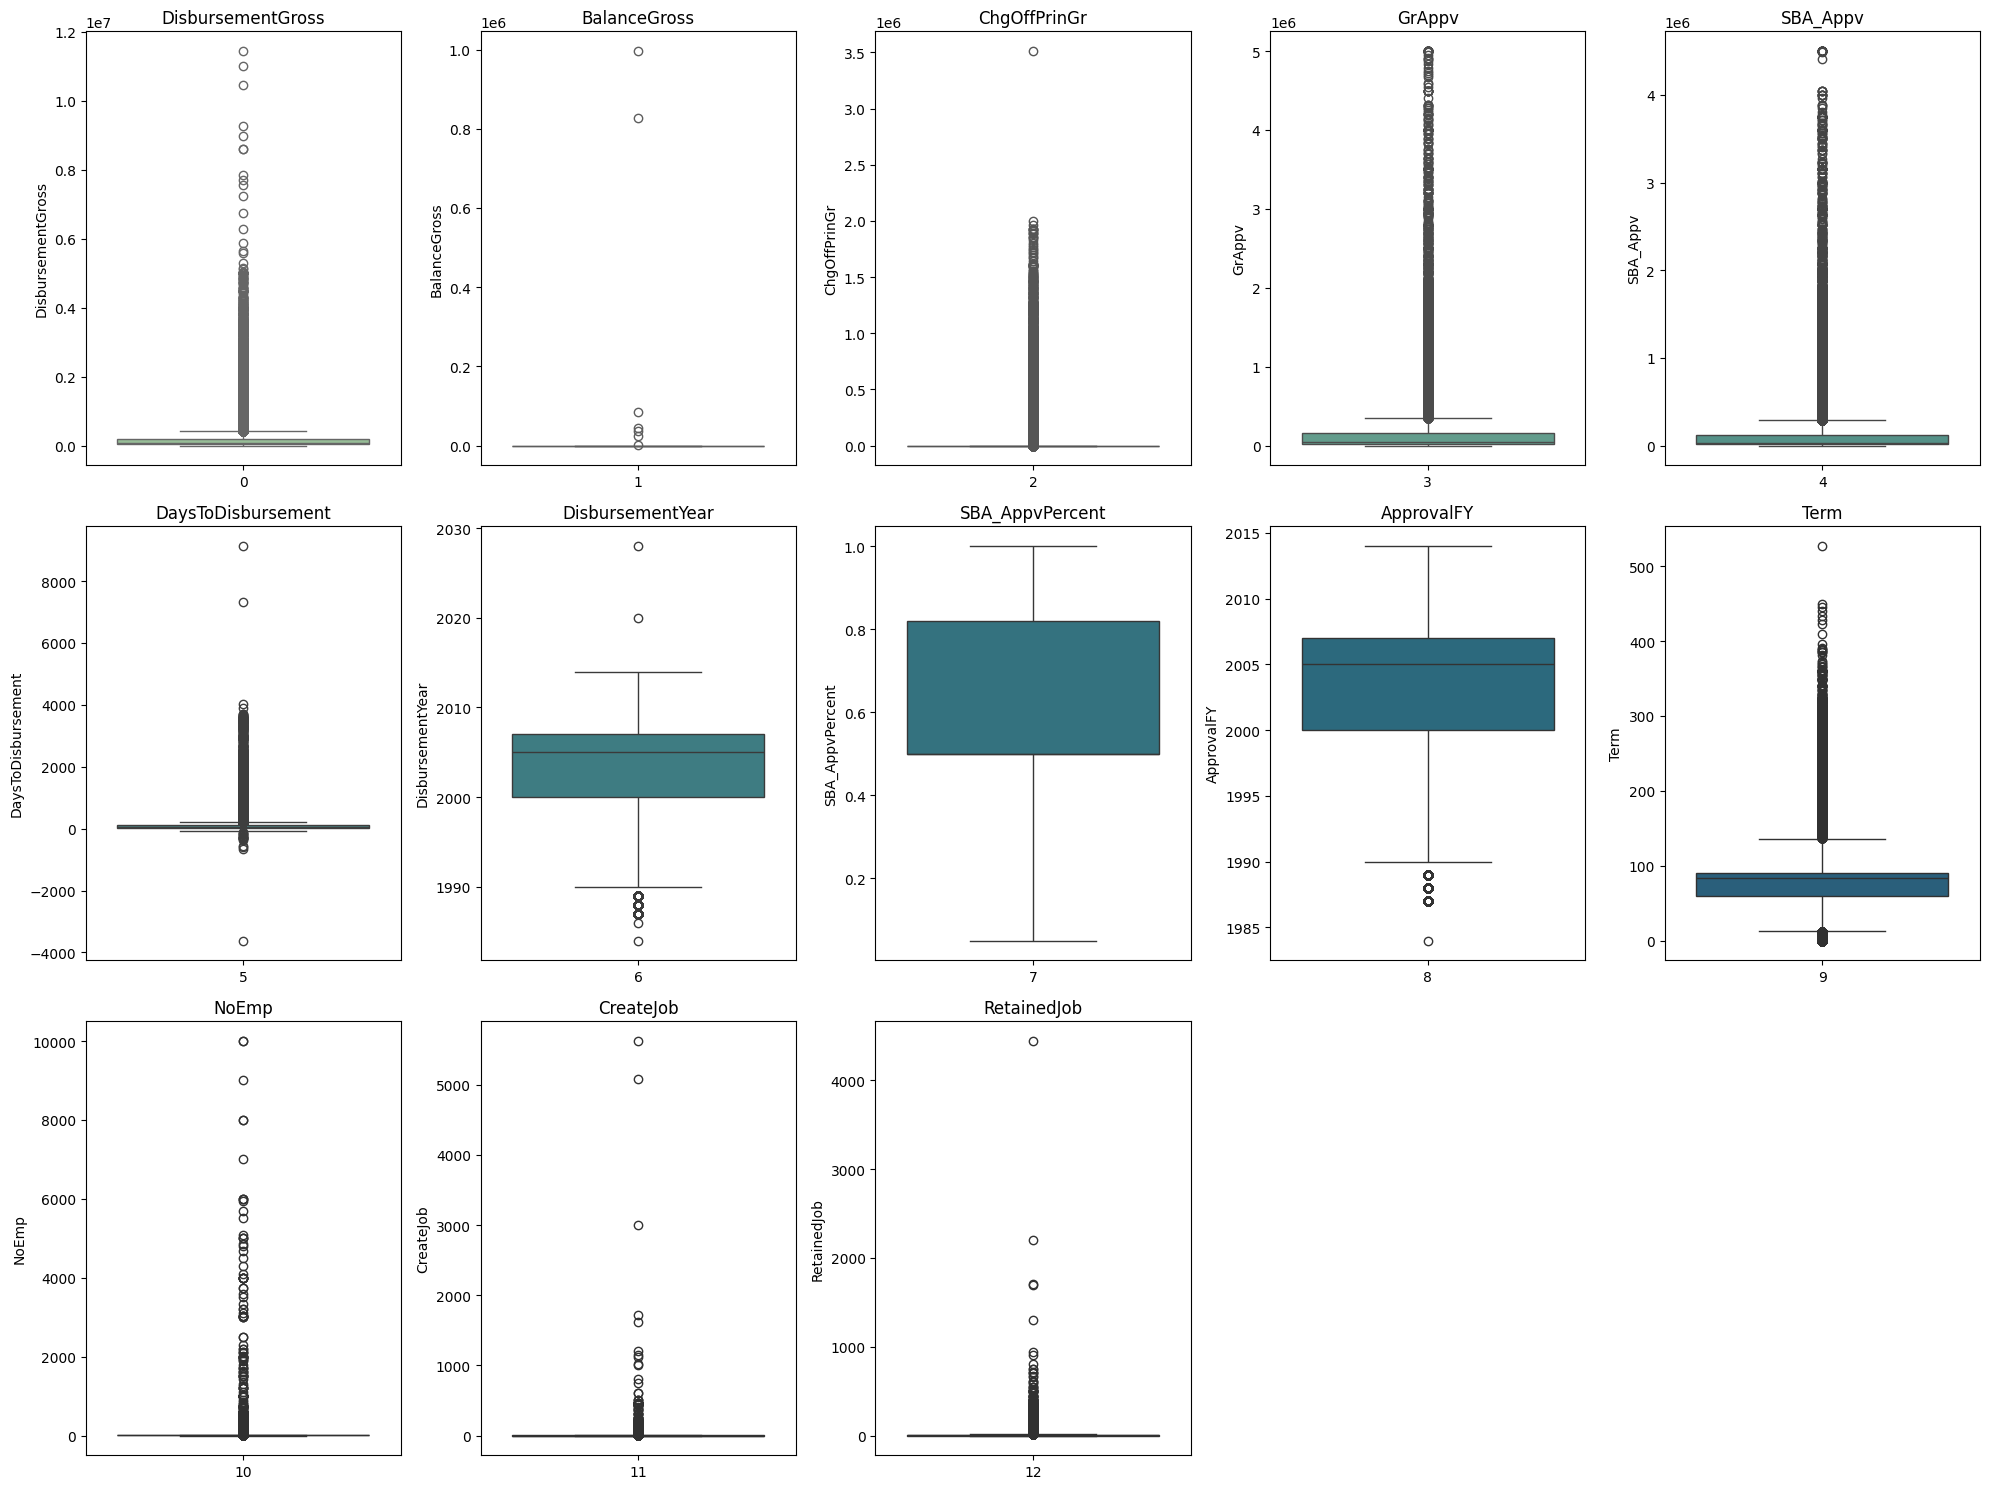

In [ ]:
# Create boxplot to see outliers distribution in each numerical feature

outlier_plot(loans_copy, feat_num_spread)

In [ ]:
# create countplot function to churn out count plots of the dataset's categorical features
def count_plot(services):
  num_rows = len(services) // 2 + len(services) % 2
  plt.figure(figsize=(18, 10))

  for i, col in enumerate(services, start=1):
      ax = plt.subplot(3, num_rows, i)
      sns.countplot(x=col, hue=col, data=loans_copy, palette="viridis", ax=ax)
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')
      plt.legend([], frameon=False)

      # Adding percentages above the bars
      total = len(loans_copy[col])
      for p in ax.patches:
          height = p.get_height()
          percentage = f'{height / total * 100:.1f}%'
          ax.annotate(percentage,
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='center',
                      xytext=(0, 5),
                      textcoords='offset points',
                      fontsize=10,
                      color='black')

  plt.tight_layout()
  plt.show()

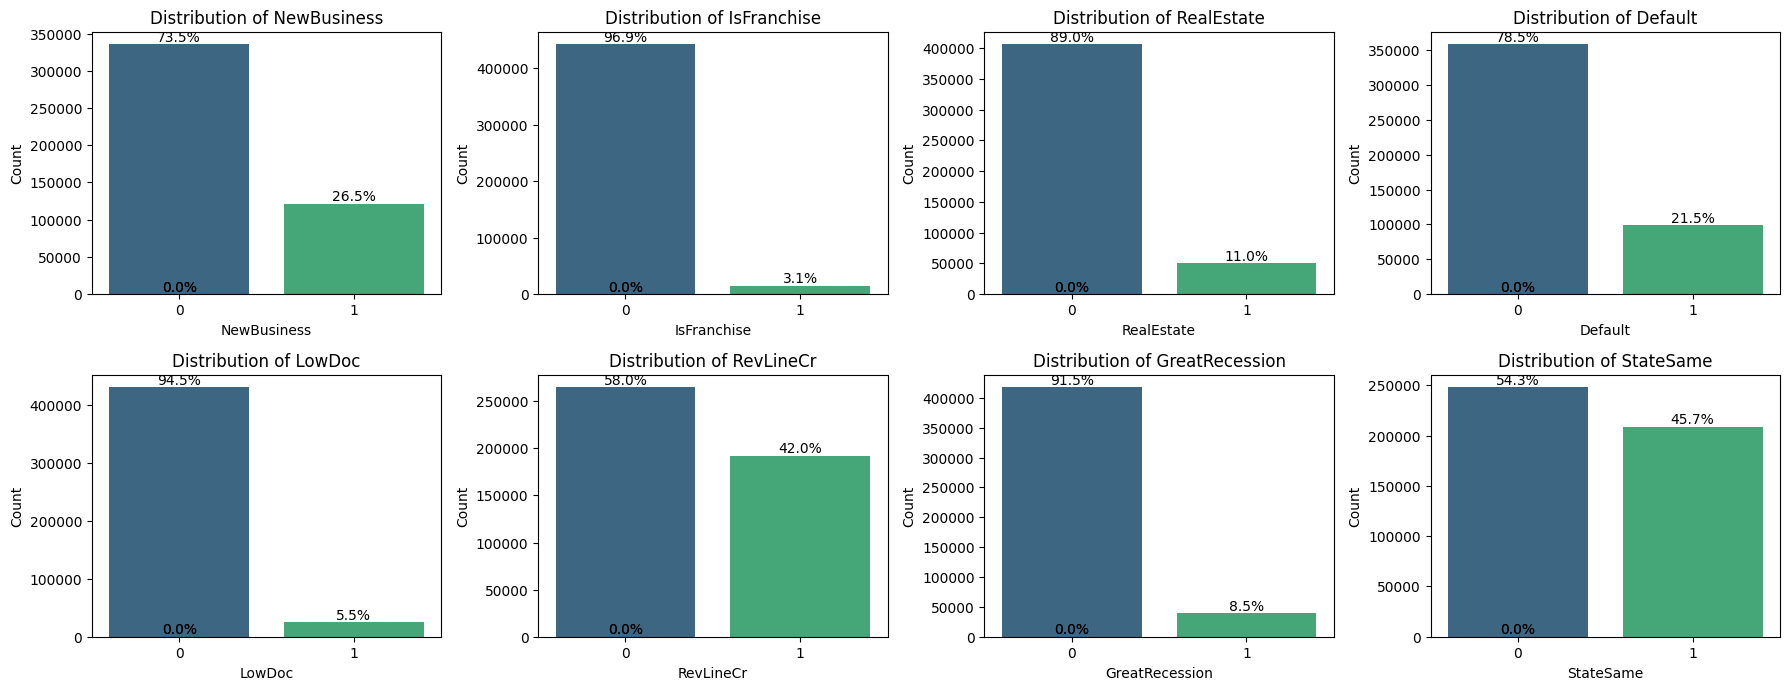

In [ ]:
count_plot(feat_num_cat)

**Observation:**

Majority of numerical features are heavily left skewed, they include `DisbursementGross`, `BalanceGross`, `GrAppv`, `SBA_Appv`, `Term`, `NoEmp`, `CreateJob`, `RetainedJob`. They seem to be heavily skewed to the left due to the fact that most of the businesses applying for SBA Loans are small businesses with an average employee count of 10 with the outliers being big businesses.

I will keep the outliers for modeling later on and try to minimize it by scaling, since it may give out key analysis points.


### **6.2 Bivariate / Multivariate Analysis**

First of all, I want to see the correlation of each feature with one another by using correlation matrix.

Since correlation matrix cannot accept text, I drop the columns that I assume may not be of use.

In [ ]:
loans_eda = loans_copy.copy()

In [ ]:
loans_eda.drop(columns=['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'State', 'Bank', 'BankState', 'NAICS', 'ApprovalDate', 'NewExist', 'FranchiseCode',
                      'ChgOffDate', 'DisbursementDate', 'SBA_Appv', 'MIS_Status', 'Industry'], inplace=True)

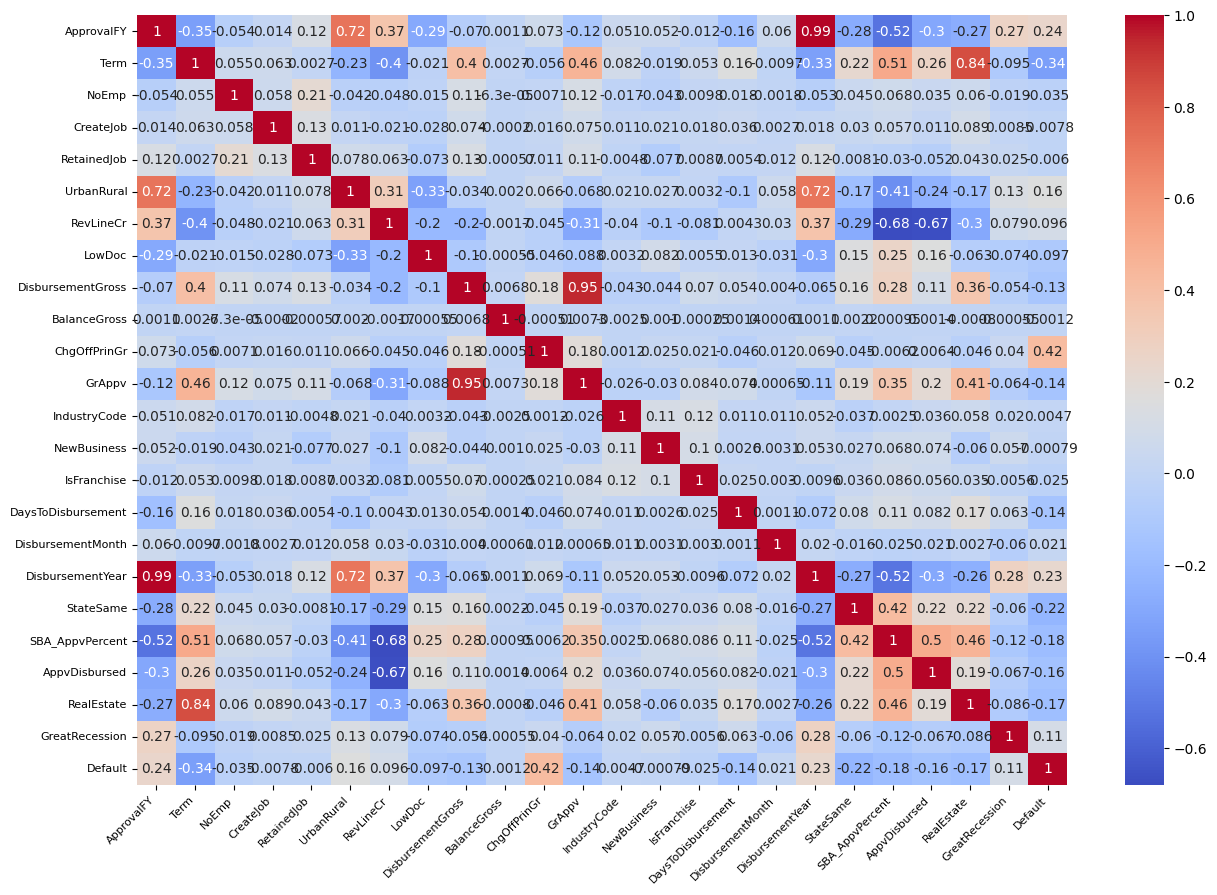

In [ ]:
# Heatmap for correlation matrix between features
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
corr_matrix = loans_eda.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

**Observation**

There are some notable correaltions:
1. `ApprovalFY` & `DisbursementYear` + `UrbanRural` : This can be connected to economic factors (e.g., economic downturns, policy changes) based on the location of the business.
2. `ApprovalFY` + `DisbursementYear` : More likely the year of the loan being approved will be disbursed on the same year.
3. `Term` + `RealEstate` : Most likely the longer the term, the collateral being used for the loan is real estate.
4. `DisbursementGross` + `GrAppv` : Most likely almost the total amount of Gross Approved is disbursed but SBA may not approve all of it.
5. `RevLineCr` + `AppvDisbursed` : Negatively correlates due to the fact that usually customers can continually take out loans from their credit line after paying off the balance.
6. `SBA_AppvPercent` + `RevLineCr` : Based on [7(a) loans](https://www.sba.gov/partners/lenders/7a-loan-program/types-7a-loans), a higher percentage of approved loans by the SBA typically involves a short line of credit, and vice versa.

In [ ]:
ind_dis_sum = loans_copy.groupby('Industry')['DisbursementGross'].sum().sort_values(ascending=False)

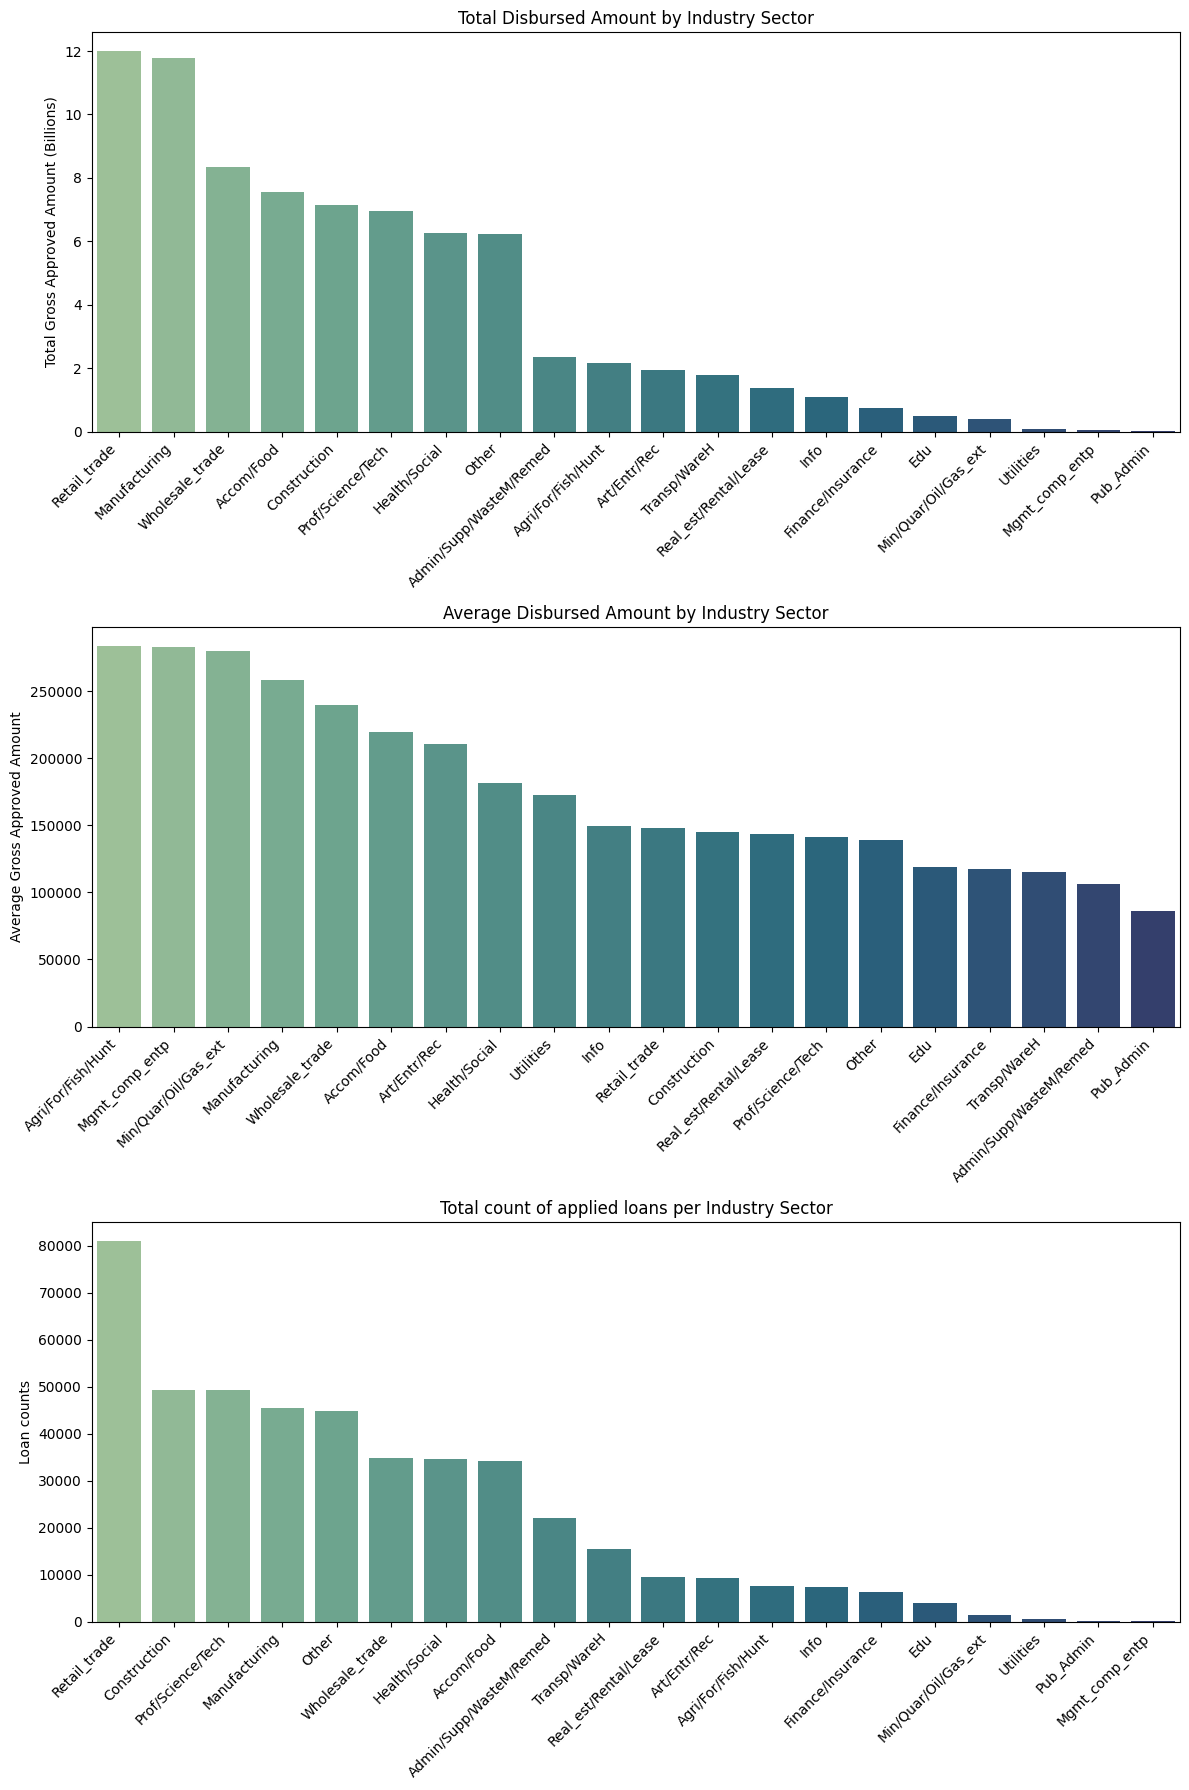

In [ ]:
# Calculate means and sort by mean value
ind_dis_sum = loans_copy.groupby('Industry')['DisbursementGross'].sum().sort_values(ascending=False)
ind_dis_avg = loans_copy.groupby('Industry')['DisbursementGross'].mean().sort_values(ascending=False).index
industry_counts = loans_copy['Industry'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(12, 18))

# Total Gross Approved Amount
plt.subplot(3, 1, 1)
sns.barplot(x=ind_dis_sum.index, y=ind_dis_sum.values / 1000000000, palette="crest", ci=None)
plt.title('Total Disbursed Amount by Industry Sector')
plt.xlabel('')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)
plt.ylabel('Total Gross Approved Amount (Billions)')

# Average Gross Approved Amount
plt.subplot(3, 1, 2)
sns.barplot(x='Industry', y='DisbursementGross', data=loans_copy, order=ind_dis_avg, palette="crest", ci=None)
plt.title('Average Disbursed Amount by Industry Sector')
plt.xlabel('')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)
plt.ylabel('Average Gross Approved Amount')

# Total count of applied loans
plt.subplot(3, 1, 3)
sns.countplot(x='Industry', data=loans_copy, order=industry_counts, palette="crest")
plt.title('Total count of applied loans per Industry Sector')
plt.xlabel('')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)
plt.ylabel('Loan counts')

plt.tight_layout()
plt.show()

**Observation:**

1. Retail Trade and Manufacturing industries have more loans disbursed in total than other industries.
2. On the other hand, Agriculture/forestry/fishing/hunting, management of companies and enterprises, and mining, quarrying, and oil and gas extraction
have a higher average loan disbursed per loan applied & approved.
3. Frequency of the loans applied varies on each industry sector and it suggested that observation point 1 has lower frequencies of loans applied than point 2.
4. These suggesst the scale of businesses on each industry sector may correlate to the loan amount disbursed.

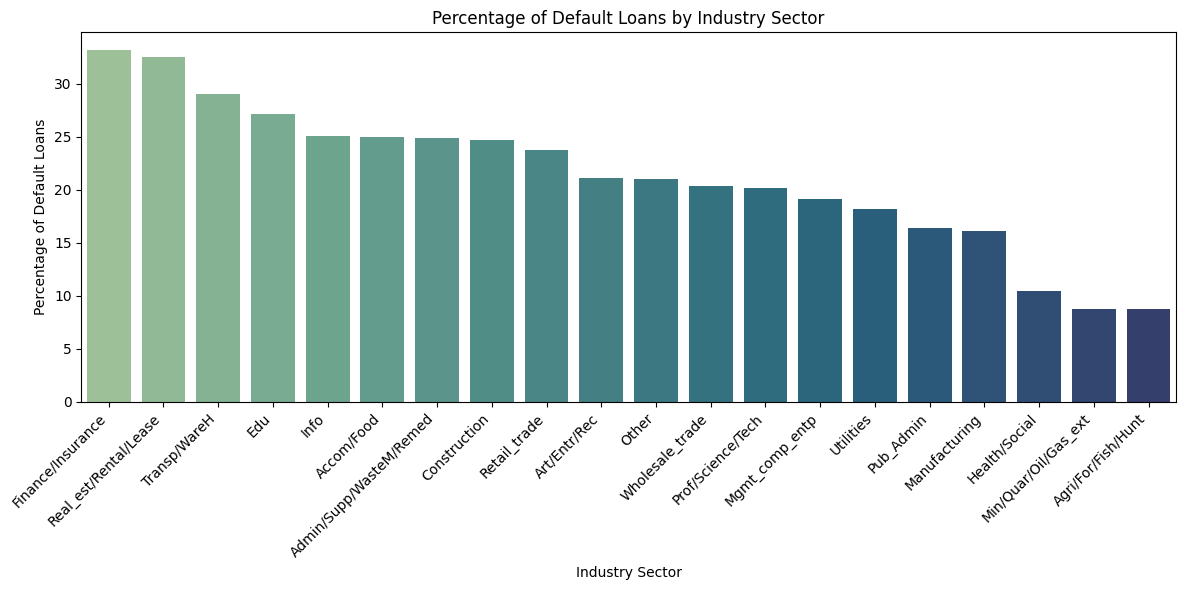

In [ ]:
loans_copy_default = loans_copy[loans_copy['Default'] == 1]

# Calculate the total count of loans and default loans for each industry
industry_totals = loans_copy.groupby('Industry').size().reset_index(name='Total')
default_counts = loans_copy_default.groupby('Industry').size().reset_index(name='DefaultCount')

# Merge the dataframes
industry_default = pd.merge(industry_totals, default_counts, on='Industry', how='left')
industry_default['DefaultCount'] = industry_default['DefaultCount'].fillna(0)
industry_default['DefaultPercentage'] = (industry_default['DefaultCount'] / industry_default['Total']) * 100

# Sort by most default loans (descending order)
industry_default_perc_sorted = industry_default.sort_values(by='DefaultPercentage', ascending=False)

plt.figure(figsize=(12, 6))

sns.barplot(x='Industry', y='DefaultPercentage', data=industry_default_perc_sorted, palette='crest')
plt.title('Percentage of Default Loans by Industry Sector')
plt.xlabel('Industry Sector')
plt.ylabel('Percentage of Default Loans')
plt.xticks(rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()

In [ ]:
industry_default.sort_values(by='DefaultCount', ascending=False).reset_index(drop=True).head(10)

Industry  Total  DefaultCount  DefaultPercentage
0             Retail_trade  80952         19246          23.774582
1             Construction  49238         12185          24.747147
2        Prof/Science/Tech  49201          9911          20.143900
3                    Other  44799          9439          21.069667
4               Accom/Food  34266          8565          24.995622
5            Manufacturing  45530          7343          16.127828
6          Wholesale_trade  34804          7100          20.399954
7  Admin/Supp/WasteM/Remed  22012          5475          24.872797
8             Transp/WareH  15404          4472          29.031420
9            Health/Social  34505          3627          10.511520

**Observation:**

Interestingly, industry sectors with the most percentage of defaults go to Finance/Insurance, Real Estate/Rental/Lease, and Transportation/Warehouse.

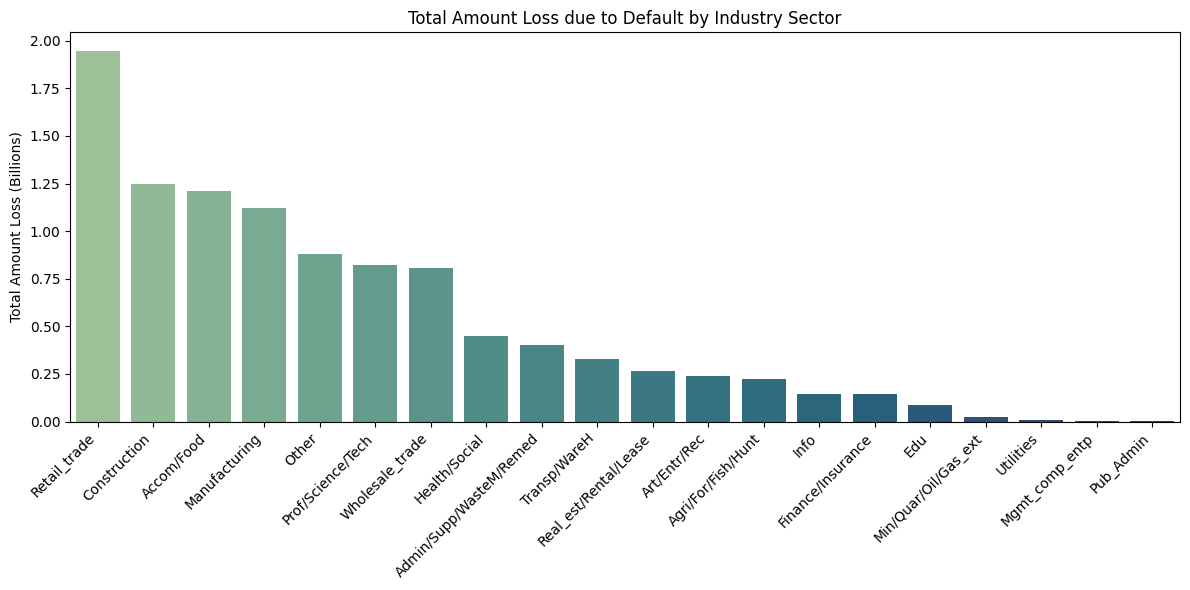

In [ ]:
# Calculate the total count of loans and default loans for each industry
loans_copy_default = loans_copy[loans_copy['Default'] == 1]

industry_totals = loans_copy_default.groupby('Industry').size().reset_index(name='DefaultCount')
ind_dis_sum_default = loans_copy_default.groupby('Industry')['DisbursementGross'].sum().sort_values(ascending=False)

# Merge the dataframes (for descriptive purposes)
industry_default_loss = pd.merge(industry_totals, ind_dis_sum_default, on='Industry', how='left')

plt.figure(figsize=(12, 6))

sns.barplot(x=ind_dis_sum_default.index, y=ind_dis_sum_default.values / 1000000000, palette="crest", ci=None)
plt.title('Total Amount Loss due to Default by Industry Sector')
plt.xlabel('')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)
plt.ylabel('Total Amount Loss (Billions)')

plt.tight_layout()
plt.show()

In [ ]:
# Rename field data to be readable
industry_default_loss['DisbursementGross'] = industry_default_loss['DisbursementGross'].apply(lambda x: f'${x / 1e9:.3f} billion')

In [ ]:
# Drop columns for merge purposes
industry_default_loss.drop(['DefaultCount'], axis=1, inplace=True)

In [ ]:
# Merge default percentage dataframe with loss dataframe

industry_default_with_loss = pd.merge(industry_default, industry_default_loss, on='Industry', how='left')

In [ ]:
# Rename column from DisburmentGross to DisbursementLoss
industry_default_with_loss.rename(columns = {'DisbursementGross' : 'DisbursementLoss'}, inplace=True)

# Sort based on DisbursementLoss
industry_default_with_loss.sort_values(by='DisbursementLoss', ascending=False).reset_index(drop=True)

Industry  Total  DefaultCount  DefaultPercentage  \
0              Retail_trade  80952         19246          23.774582   
1              Construction  49238         12185          24.747147   
2                Accom/Food  34266          8565          24.995622   
3             Manufacturing  45530          7343          16.127828   
4                     Other  44799          9439          21.069667   
5         Prof/Science/Tech  49201          9911          20.143900   
6           Wholesale_trade  34804          7100          20.399954   
7             Health/Social  34505          3627          10.511520   
8   Admin/Supp/WasteM/Remed  22012          5475          24.872797   
9              Transp/WareH  15404          4472          29.031420   
10    Real_est/Rental/Lease   9553          3112          32.576154   
11             Art/Entr/Rec   9264          1953          21.081606   
12       Agri/For/Fish/Hunt   7629           669           8.769170   
13                     Info   7352          1843          25.068009   
14        Finance/Insurance   6336          2104          33.207071   
15                      Edu   4005          1087          27.141074   
16     Min/Quar/Oil/Gas_ext   1353           119           8.795270   
17                Utilities    434            79          18.202765   
18           Mgmt_comp_entp    120            23          19.166667   
19                Pub_Admin    183            30          16.393443   

   DisbursementLoss  
0    $1.947 billion  
1    $1.249 billion  
2    $1.211 billion  
3    $1.123 billion  
4    $0.879 billion  
5    $0.823 billion  
6    $0.808 billion  
7    $0.448 billion  
8    $0.400 billion  
9    $0.327 billion  
10   $0.266 billion  
11   $0.241 billion  
12   $0.222 billion  
13   $0.147 billion  
14   $0.145 billion  
15   $0.087 billion  
16   $0.024 billion  
17   $0.007 billion  
18   $0.003 billion  
19   $0.002 billion

**Observation:**

1. The most losses in loan defaults come from Retail Trade, Construction, and Accomodation/Food sector.
2. Even though bank may lose a lot of money from loan default where the funds cannot be retrieved, there is an insurance policy with the SBA where banks/lenders can submit a claim to the SBA for reimbursement of the guaranteed portion of the outstanding principal balance. The reimbursement amount is generally based on the percentage of the loan that was guaranteed by the SBA.

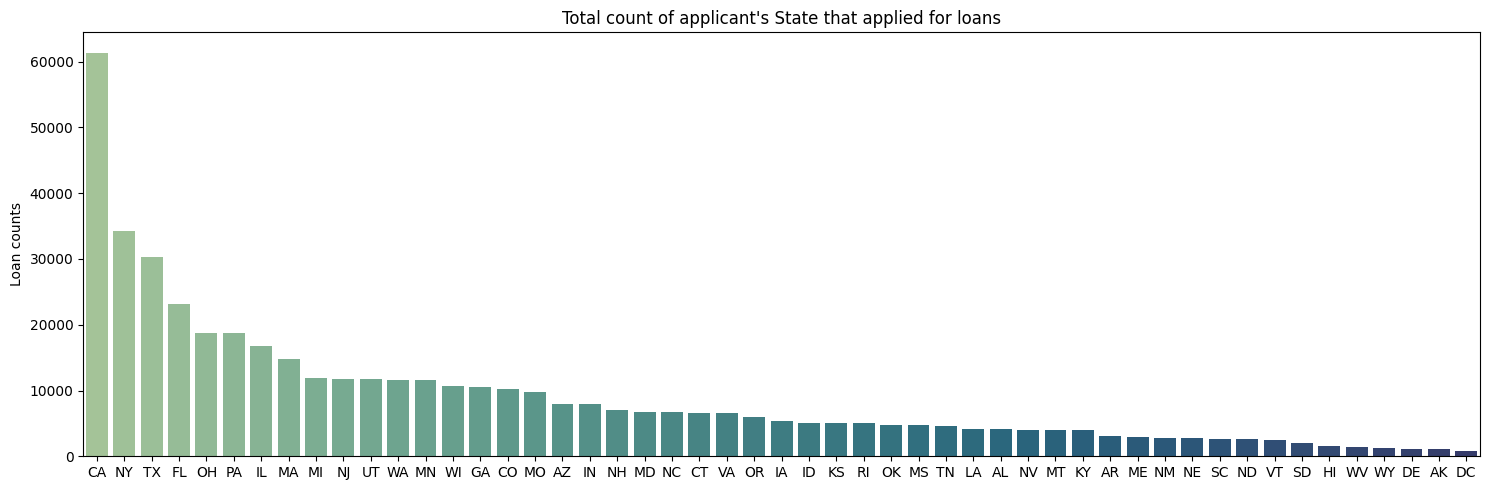

In [ ]:
# Calculate State counts and sort them
state_counts = loans_copy['State'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(15, 5))

sns.countplot(x='State', data=loans_copy, order=state_counts, palette="crest")
plt.title('Total count of applicant\'s State that applied for loans')
plt.xlabel('')
plt.xticks(fontsize=10)
plt.ylabel('Loan counts')

plt.tight_layout()
plt.show()

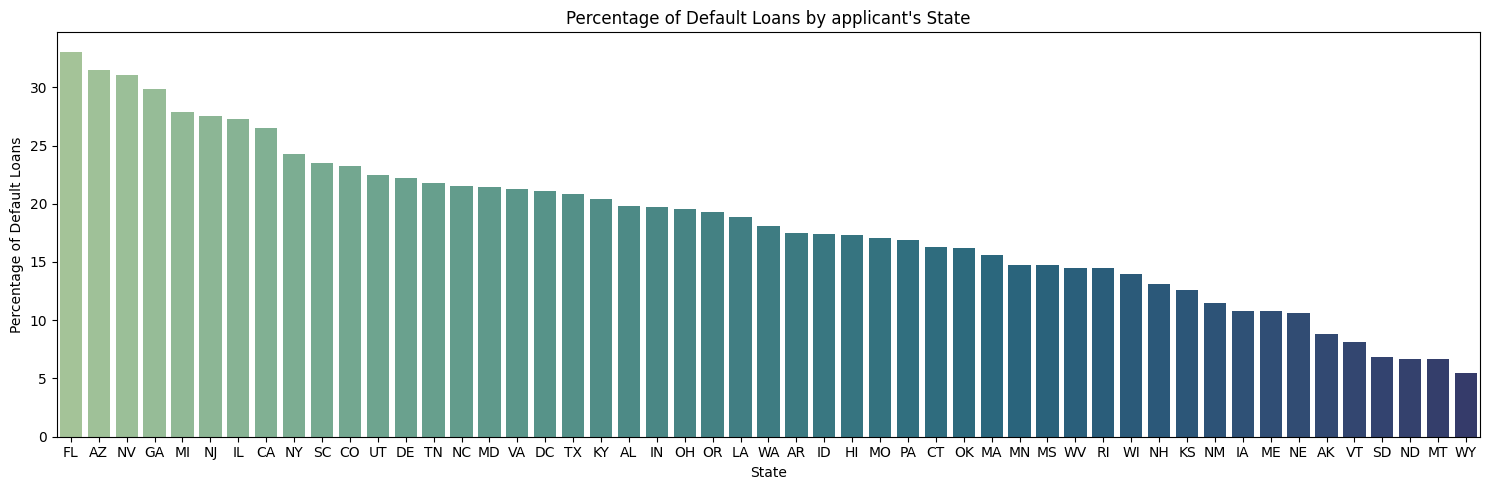

In [ ]:
# Calculate the total count of loans and default loans for each state
state_totals = loans_copy.groupby('State').size().reset_index(name='Total')
state_default_counts = loans_copy_default.groupby('State').size().reset_index(name='DefaultCount')

# Merge the dataframes
state_default = pd.merge(state_totals, state_default_counts, on='State', how='left')
state_default['DefaultCount'] = state_default['DefaultCount'].fillna(0)
state_default['DefaultPercentage'] = (state_default['DefaultCount'] / state_default['Total']) * 100

# Sort by most default loans (descending order)
state_default_perc_sorted = state_default.sort_values(by='DefaultPercentage', ascending=False)

plt.figure(figsize=(15, 5))

sns.barplot(x='State', y='DefaultPercentage', data=state_default_perc_sorted, palette='crest')
plt.title('Percentage of Default Loans by applicant\'s State')
plt.xlabel('State')
plt.ylabel('Percentage of Default Loans')
plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
state_default.sort_values(by='DefaultPercentage', ascending=False).reset_index(drop=True).head(3)

State  Total  DefaultCount  DefaultPercentage
0    FL  23110          7641          33.063609
1    AZ   7944          2504          31.520645
2    NV   4044          1255          31.033630

In [ ]:
state_dis_loss = loans_copy_default.groupby('State')['DisbursementGross'].sum().sort_values(ascending=False)

# Merge the dataframes (for descriptive purposes)
state_default_loss = pd.merge(state_default, state_dis_loss, on='State', how='left')

# Rename field data to be readable
state_default_loss['DisbursementGross'] = state_default_loss['DisbursementGross'].apply(lambda x: f'${x / 1e9:.3f} billion')

# Rename column from DisburmentGross to DisbursementLoss
state_default_loss.rename(columns = {'DisbursementGross' : 'DisbursementLoss'}, inplace=True)

# Sort based on DisbursementLoss (Display top 3)
state_default_loss.sort_values(by='DisbursementLoss', ascending=False).reset_index(drop=True).head(3)

State  Total  DefaultCount  DefaultPercentage DisbursementLoss
0    CA  61387         16296          26.546337   $1.507 billion
1    FL  23110          7641          33.063609   $0.773 billion
2    TX  30306          6317          20.844057   $0.752 billion

**Observation:**

1. The highest frequency of applied loans comes from businesses that resides at California, New York, and Texas
2. Florida (33%), Arizona (31.5%), and Nevada (31%) have the highest default percentage based on applicant's state.
3. On the other hand, the most losses comes from applicants residing at California (1.5 billion), Florida (0.77 billion), and Texas (0.75 billion). This suggesst that more businessess applied for larger sums of loans resides from these states.

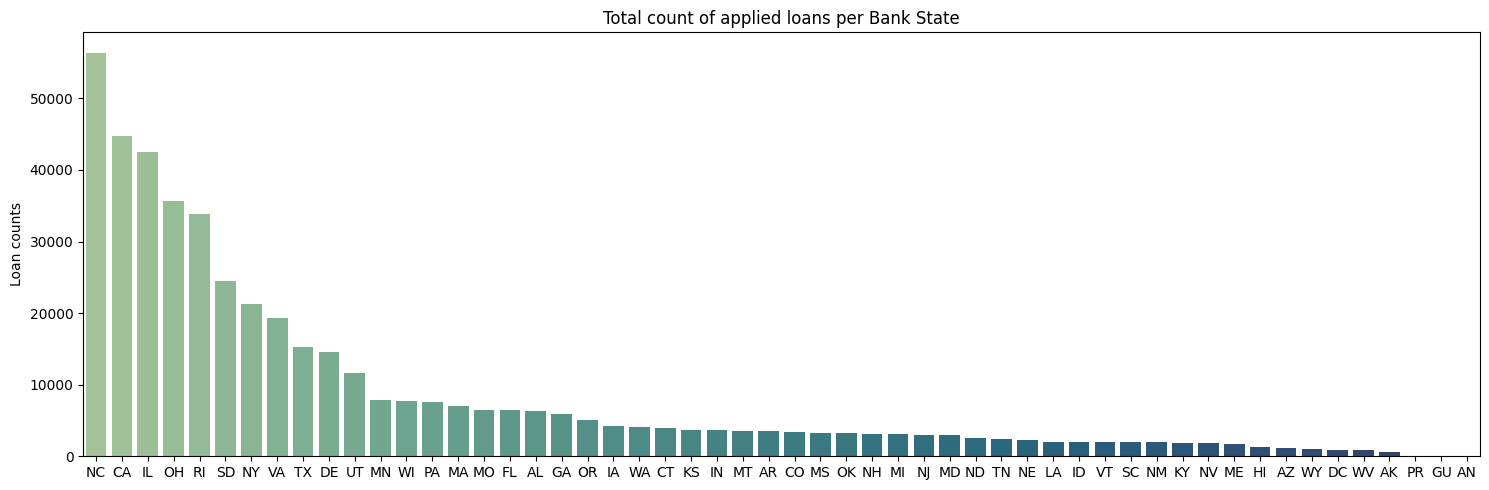

In [ ]:
# Calculate Bank State counts and sort
bank_state_counts = loans_copy['BankState'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(15, 5))

sns.countplot(x='BankState', data=loans_copy, order=bank_state_counts, palette="crest")
plt.title('Total count of applied loans per Bank State')
plt.xlabel('')
plt.xticks(fontsize=10)
plt.ylabel('Loan counts')

plt.tight_layout()
plt.show()

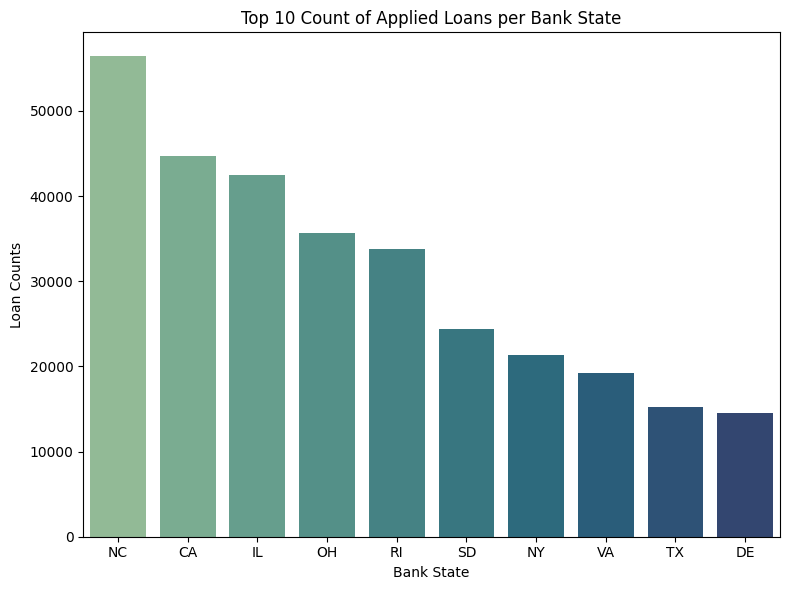

In [ ]:
# Calculate Bank State counts and get the top 10 states
top_10_bank_states = loans_copy['BankState'].value_counts().nlargest(10).index

plt.figure(figsize=(8, 6))

sns.countplot(x='BankState', data=loans_copy[loans_copy['BankState'].isin(top_10_bank_states)],
              order=top_10_bank_states, palette="crest")
plt.title('Top 10 Count of Applied Loans per Bank State')
plt.xlabel('Bank State')
plt.ylabel('Loan Counts')

plt.tight_layout()
plt.show()

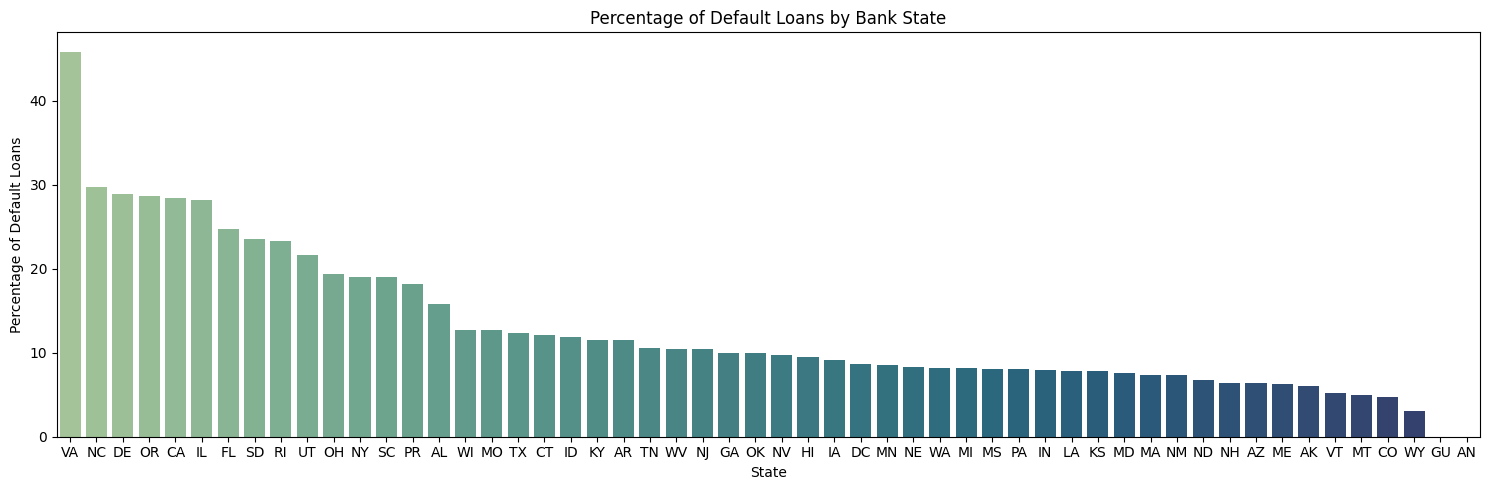

In [ ]:
# Calculate the total count of loans and default loans for each state
bank_state_totals = loans_copy.groupby('BankState').size().reset_index(name='Total')
bank_state_default_counts = loans_copy_default.groupby('BankState').size().reset_index(name='DefaultCount')

# Merge dataframes
bank_state_default = pd.merge(bank_state_totals, bank_state_default_counts, on='BankState', how='left')
bank_state_default['DefaultCount'] = bank_state_default['DefaultCount'].fillna(0)
bank_state_default['DefaultPercentage'] = (bank_state_default['DefaultCount'] / bank_state_default['Total']) * 100

# Sort by most default loans (descending order)
bank_state_default_perc_sorted = bank_state_default.sort_values(by='DefaultPercentage', ascending=False)

plt.figure(figsize=(15, 5))

sns.barplot(x='BankState', y='DefaultPercentage', data=bank_state_default_perc_sorted, palette='crest')
plt.title('Percentage of Default Loans by Bank State')
plt.xlabel('State')
plt.ylabel('Percentage of Default Loans')
plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()

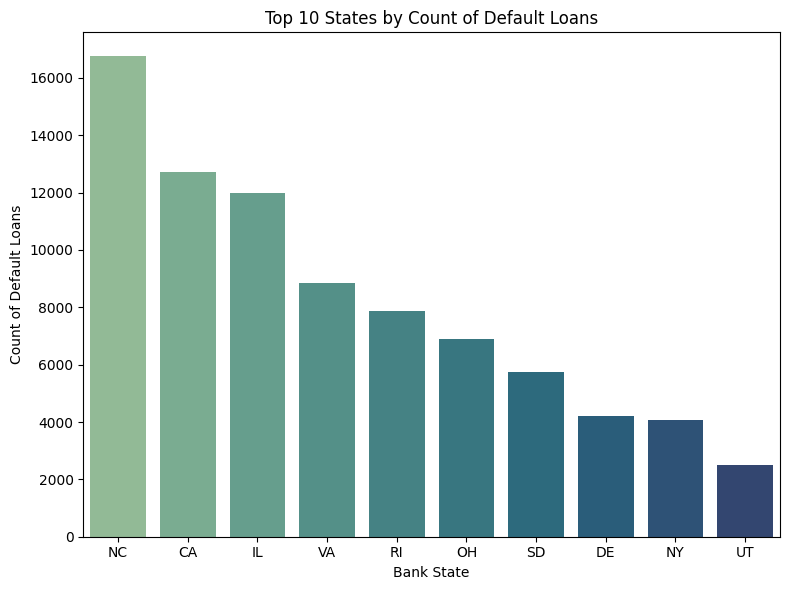

In [ ]:
# Calculate the total count of loans and default loans for each state
bank_state_totals = loans_copy.groupby('BankState').size().reset_index(name='Total')
bank_state_default_counts = loans_copy_default.groupby('BankState').size().reset_index(name='DefaultCount')

# Merge dataframes
bank_state_default = pd.merge(bank_state_totals, bank_state_default_counts, on='BankState', how='left')
bank_state_default['DefaultCount'] = bank_state_default['DefaultCount'].fillna(0)

# Sort by the count of default loans (descending order) and get top 10
top_10_defaults = bank_state_default.sort_values(by='DefaultCount', ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x='BankState', y='DefaultCount', data=top_10_defaults, palette='crest')
plt.title('Top 10 States by Count of Default Loans')
plt.xlabel('Bank State')
plt.ylabel('Count of Default Loans')
plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
bank_state_dis_loss = loans_copy_default.groupby('BankState')['DisbursementGross'].sum().sort_values(ascending=False)

# Merge the dataframes (for descriptive purposes)
bank_state_default_loss = pd.merge(bank_state_default, bank_state_dis_loss, on='BankState', how='left')

# Rename field data to be readable
bank_state_default_loss['DisbursementGross'] = bank_state_default_loss['DisbursementGross'].apply(lambda x: f'${x / 1e9:.3f} billion')

# Rename column from DisburmentGross to DisbursementLoss
bank_state_default_loss.rename(columns = {'DisbursementGross' : 'DisbursementLoss'}, inplace=True)

# Drop null values from specified columns
bank_state_default_loss = bank_state_default_loss.query('DefaultCount != 0')

# Sort based on DisbursementLoss
bank_state_default_loss.sort_values(by='DisbursementLoss', ascending=False).reset_index(drop=True).head(3)

BankState  Total  DefaultCount DisbursementLoss
0        CA  44758       12729.0   $1.286 billion
1        IL  42460       11970.0   $1.218 billion
2        NC  56407       16753.0   $1.142 billion

**Observation:**

1. The highest frequency of applied loans comes from banks that resides at North Carolina, California, Illinois
2. Virginia (45.8%), North Carolina (29.7%), and Delaware (28.8%) have the highest default percentage based on bank state.
3. On the other hand, the most losses comes from banks residing at California (1.28 billion), Illinois (1.21 billion), and North Carolina (1.14 billion). This suggests that more businesses are applying for larger sums of loans through banks in these states.

Next, I want to see how many new businesses applied for loans that ended up in default.

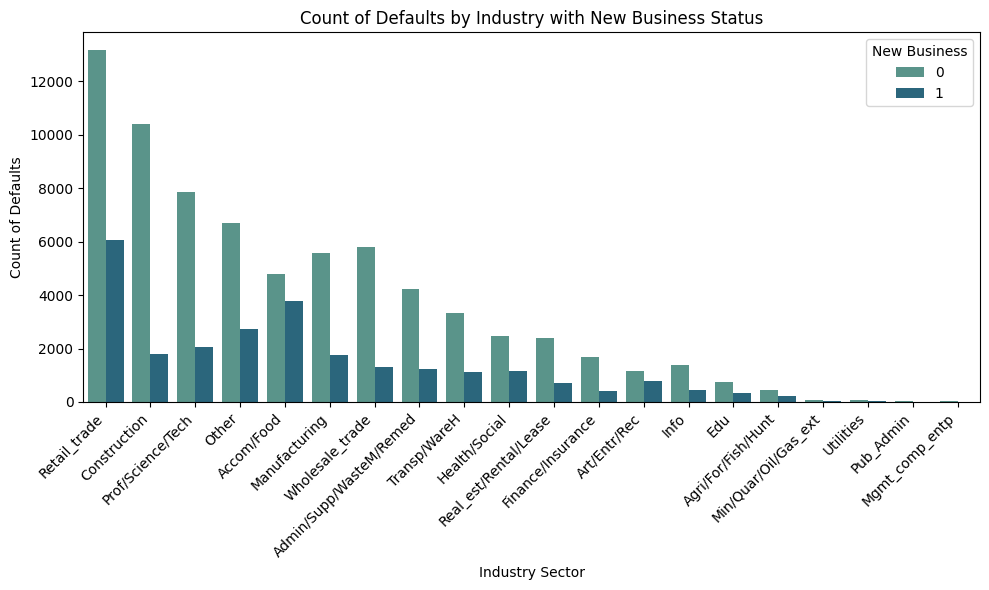

In [ ]:
# Calculate counts of defaults by industry and new business status
industry_counts = loans_copy_default.groupby('Industry').size().reset_index(name='Count')
industry_counts_sorted = industry_counts.sort_values(by='Count', ascending=False)
sorted_industries = industry_counts_sorted['Industry'].tolist()

plt.figure(figsize=(10, 6))
sns.countplot(x='Industry', hue='NewBusiness', data=loans_copy_default, palette='crest', order=sorted_industries)

plt.title('Count of Defaults by Industry with New Business Status')
plt.xlabel('Industry Sector')
plt.ylabel('Count of Defaults')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)
plt.legend(title='New Business', loc='upper right')

plt.tight_layout()
plt.show()

**Observation:**

1. Most business loans that default are not new businesses.
2. Nevertheless, a few industry sectors have new businesses that nearly compare 1 to 1 at scale with old businesses at the corresponding industry. Some include Accomodation/Food, and Arts/Entertainment/Recreation. This may suggest that some sort of economic failure may affect the corresponding industry. It may also suggest that these industries have the highest risk among others.

Next, I want to see how default rates correlates to StateSame, NewBusiness, and IsFranchise.

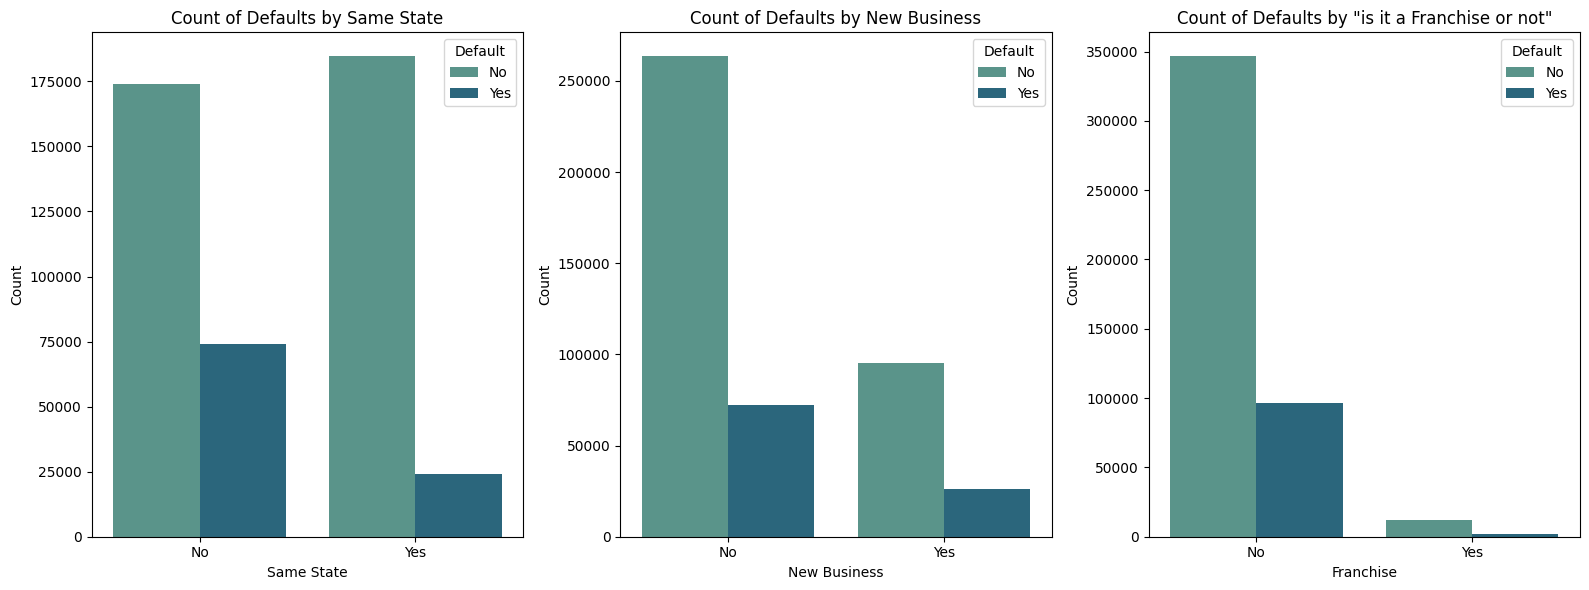

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Default by Same State
ax0 = sns.countplot(x='StateSame', hue='Default', data=loans_copy, palette='crest', ax=axes[0], hue_order=[0, 1])
axes[0].set_title('Count of Defaults by Same State')
axes[0].set_xlabel('Same State')
axes[0].set_ylabel('Count')
axes[0].legend(title='Default', labels=['No', 'Yes'])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No', 'Yes'])

# NewBusiness by Same State
ax1 = sns.countplot(x='NewBusiness', hue='Default', data=loans_copy, palette='crest', ax=axes[1], hue_order=[0, 1])
axes[1].set_title('Count of Defaults by New Business')
axes[1].set_xlabel('New Business')
axes[1].set_ylabel('Count')
axes[1].legend(title='Default', labels=['No', 'Yes'])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No', 'Yes'])

# NewBusiness by Same State
ax2 = sns.countplot(x='IsFranchise', hue='Default', data=loans_copy, palette='crest', ax=axes[2], hue_order=[0, 1])
axes[2].set_title('Count of Defaults by "is it a Franchise or not"')
axes[2].set_xlabel('Franchise')
axes[2].set_ylabel('Count')
axes[2].legend(title='Default', labels=['No', 'Yes'])
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

**Observation:**
1. A major amount (~75%) of defaulted loans do not come from the same state as the applicant.
2. A major amount (~75%) of defaulted loans were applied by new businesses.
3. Most of defaulted loans come from businesses that are not franchises.

Next, I want to see how is the average DaysToDisbursement for each industry wtih the default status.

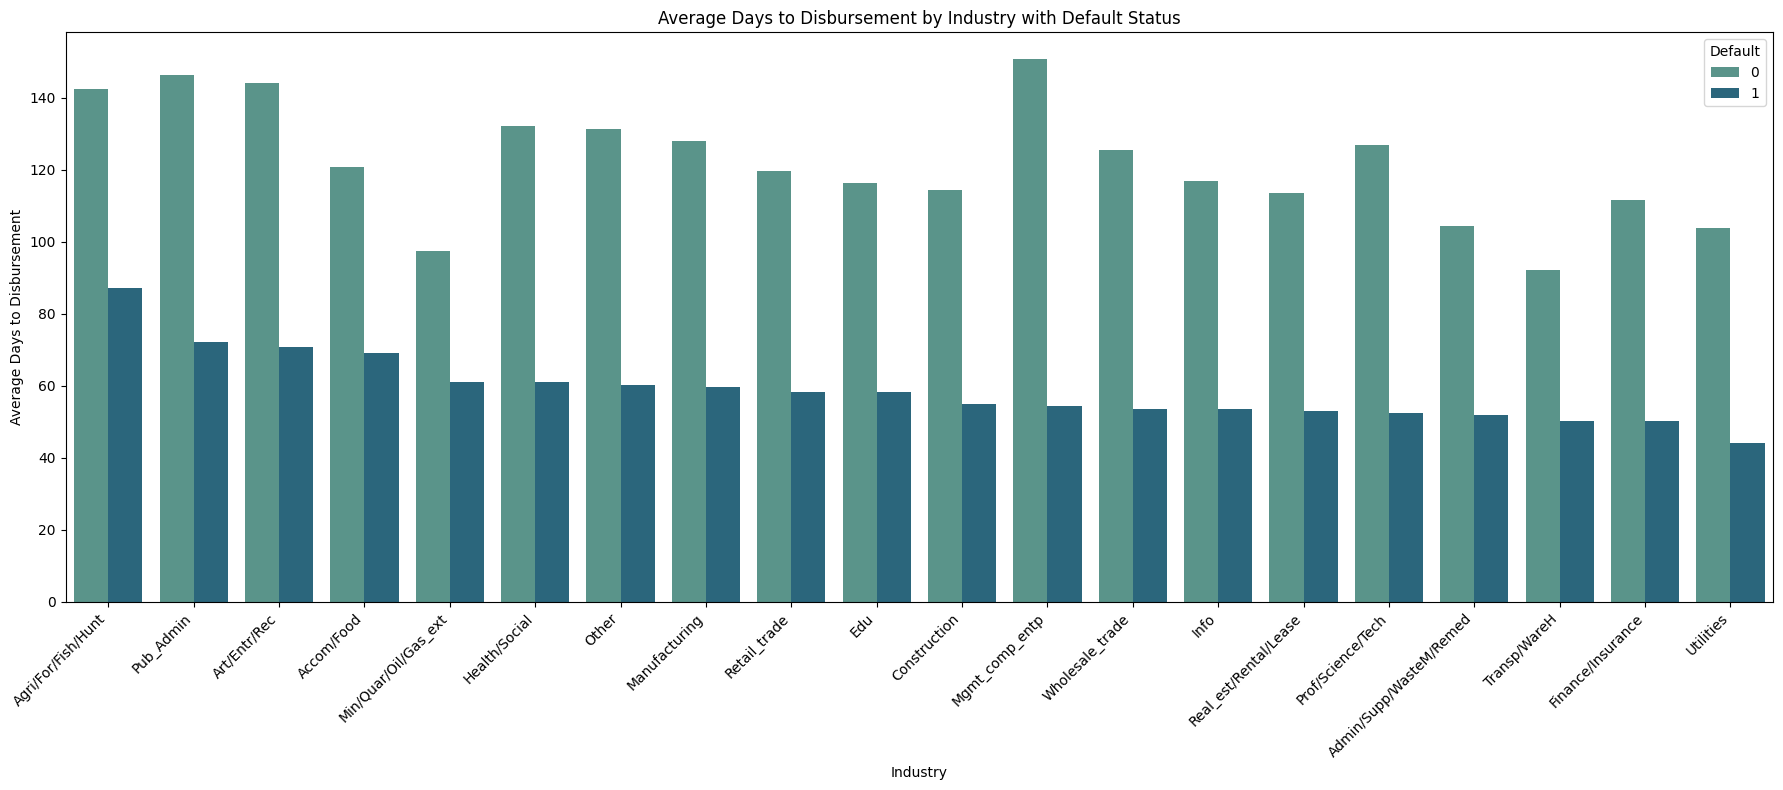

In [ ]:
# Calculate the average DaysToDisbursement for each Industry and Default status
average_days_to_disbursement = loans_copy.groupby(['Industry', 'Default'])['DaysToDisbursement'].mean().reset_index()

# Filter for Default = 1 and sort by DaysToDisbursement
sorted_industries = average_days_to_disbursement[average_days_to_disbursement['Default'] == 1].sort_values(by='DaysToDisbursement', ascending=False)['Industry']

sorted_industry_list = sorted_industries.tolist()

plt.figure(figsize=(18, 8))
sns.barplot(x='Industry', y='DaysToDisbursement', hue='Default', data=average_days_to_disbursement,
            order=sorted_industry_list, palette='crest')

plt.title('Average Days to Disbursement by Industry with Default Status')
plt.xlabel('Industry')
plt.ylabel('Average Days to Disbursement')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Observation:**

Interestingly, this shows that most loans that default have shorter days of disbursement, suggesting that there may be some practices happening:

1. A short processing time, meaning the banks do not conduct thorough checks of the business.
2. Urgent loans, businesses might accept higher interest rates or may have cashflow issues and in need of cash.

For further detail, I want to see how DaysToDisbursement correlates to Industry, NewBusiness, and IsFranchise.


In [ ]:
# Group by mean of days to disbursement for ease of sight

mean_dtd_new_business = loans_copy.groupby(['Default', 'NewBusiness'])['DaysToDisbursement'].mean().reset_index()
mean_dtd_franchise = loans_copy.groupby(['Default', 'IsFranchise'])['DaysToDisbursement'].mean().reset_index()
mean_dtd_industry = loans_copy.groupby(['Default', 'Industry'])['DaysToDisbursement'].mean().reset_index().sort_values(by='DaysToDisbursement', ascending=False)

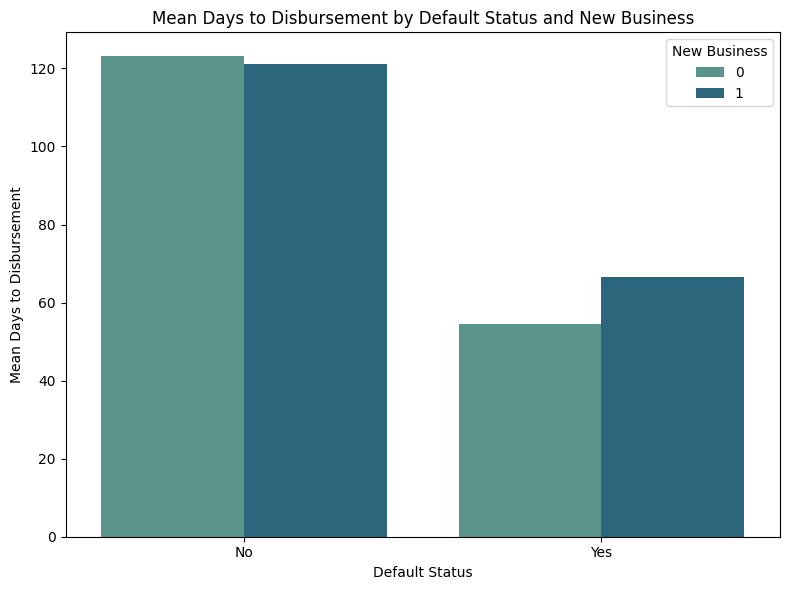

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Default', y='DaysToDisbursement', hue='NewBusiness', data=mean_dtd_new_business, palette='crest')

plt.title('Mean Days to Disbursement by Default Status and New Business')
plt.xlabel('Default Status')
plt.ylabel('Mean Days to Disbursement')
plt.xticks([0, 1], ['No', 'Yes'])

plt.legend(title='New Business', loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
mean_dtd_new_business

Default  NewBusiness  DaysToDisbursement
0        0            0          123.091512
1        0            1          121.118763
2        1            0           54.385491
3        1            1           66.513032

Interestingly, defaulted loans come from loans that were disbursed faster than non defaulted loans. This may indicate risk of inadequate vetting or the banks approving the loans may be encouraging risky borrowing.

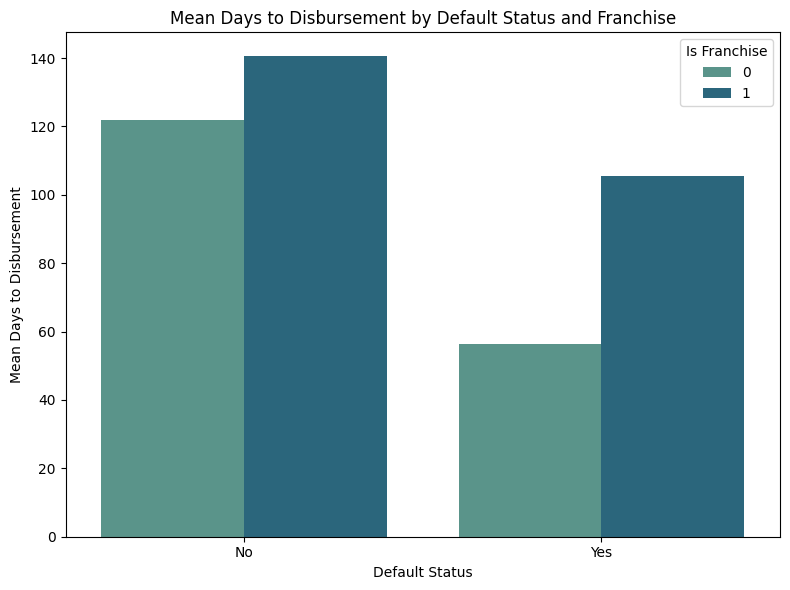

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Default', y='DaysToDisbursement', hue='IsFranchise', data=mean_dtd_franchise, palette='crest')

plt.title('Mean Days to Disbursement by Default Status and Franchise')
plt.xlabel('Default Status')
plt.ylabel('Mean Days to Disbursement')
plt.xticks([0, 1], ['No', 'Yes'])

plt.legend(title='Is Franchise', loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
mean_dtd_franchise

Default  IsFranchise  DaysToDisbursement
0        0            0          121.946836
1        0            1          140.499251
2        1            0           56.471200
3        1            1          105.412783

More or less the same with New Business parameter, but I need to take note for only a few businesses are franchises which resuts in a high mean of days to disbursement.

Moving along, I want to see how loan Term correlates to industry and default status.

In [ ]:
mean_term_industry = loans_copy.groupby(['Default', 'Industry'])['Term'].mean().reset_index().sort_values(by='Term', ascending=False)

In [ ]:
mean_term_industry

Default                 Industry        Term
10        0           Mgmt_comp_entp  156.185567
3         0             Art/Entr/Rec  125.076187
0         0               Accom/Food  123.488269
2         0       Agri/For/Fish/Hunt  122.802730
7         0            Health/Social  122.381760
12        0                    Other  119.805119
9         0            Manufacturing  108.771938
16        0             Retail_trade  105.296438
19        0          Wholesale_trade  104.130487
15        0    Real_est/Rental/Lease   99.945971
18        0                Utilities   99.416901
13        0        Prof/Science/Tech   98.517180
5         0                      Edu   96.139479
6         0        Finance/Insurance   94.465265
14        0                Pub_Admin   90.248366
4         0             Construction   90.126171
8         0                     Info   89.125976
11        0     Min/Quar/Oil/Gas_ext   87.824149
1         0  Admin/Supp/WasteM/Remed   84.760174
17        0             Transp/WareH   83.091840
22        1       Agri/For/Fish/Hunt   82.729447
20        1               Accom/Food   61.087566
23        1             Art/Entr/Rec   57.802355
27        1            Health/Social   54.683761
31        1     Min/Quar/Oil/Gas_ext   51.478992
32        1                    Other   51.140905
29        1            Manufacturing   50.372191
36        1             Retail_trade   50.086044
25        1                      Edu   49.800368
30        1           Mgmt_comp_entp   49.478261
35        1    Real_est/Rental/Lease   49.081941
34        1                Pub_Admin   47.866667
28        1                     Info   47.187737
26        1        Finance/Insurance   46.332700
33        1        Prof/Science/Tech   46.306831
39        1          Wholesale_trade   45.478310
21        1  Admin/Supp/WasteM/Remed   45.001644
37        1             Transp/WareH   44.831395
38        1                Utilities   44.113924
24        1             Construction   43.150677

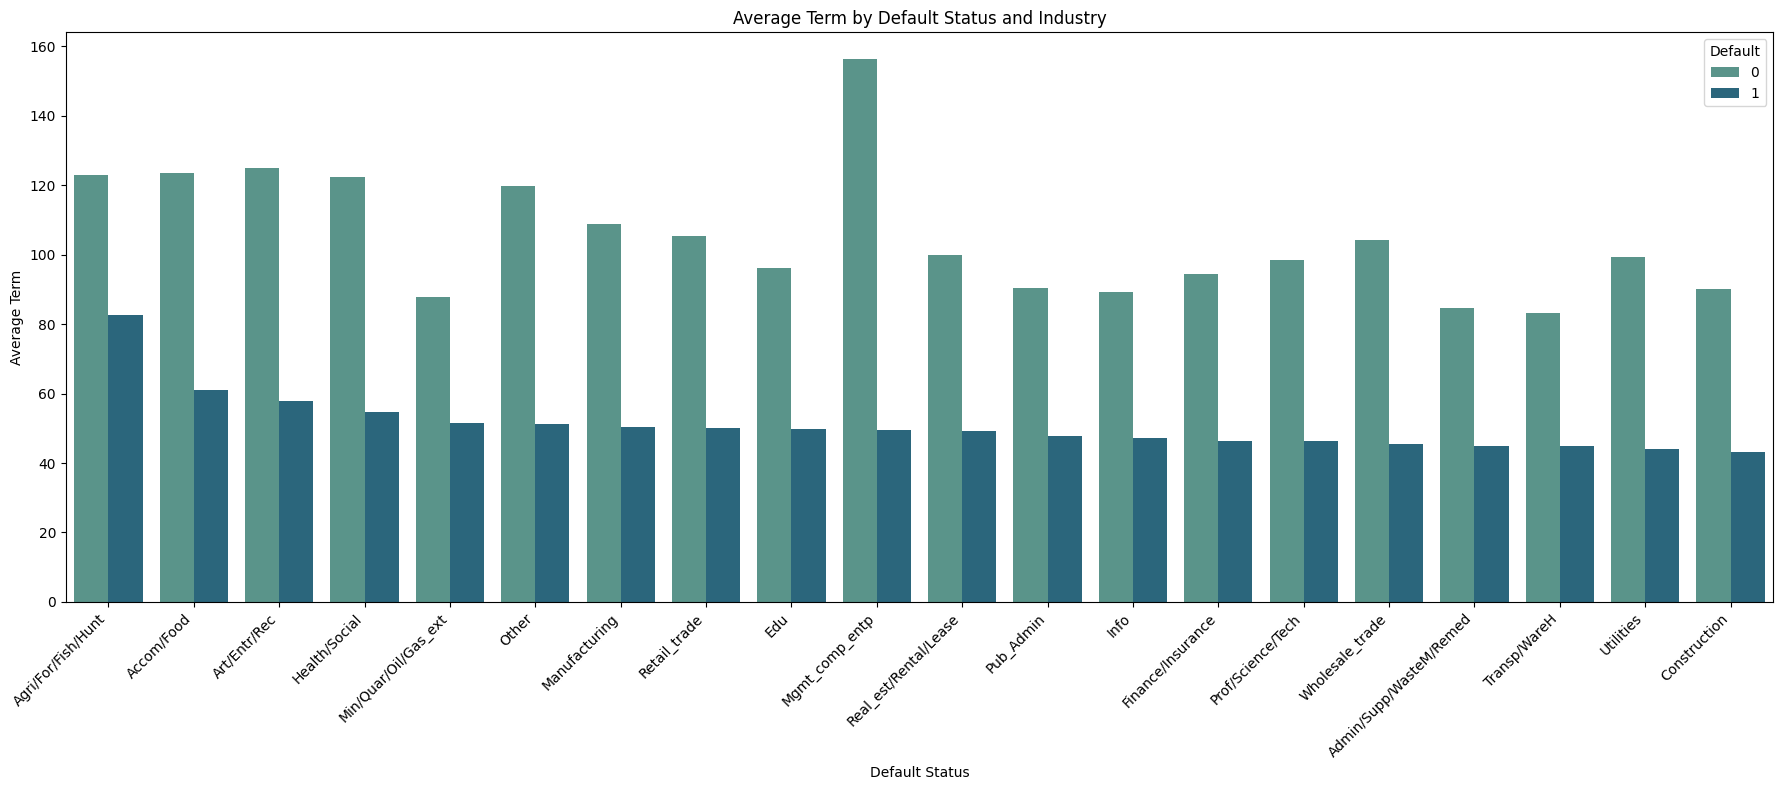

In [ ]:
# Filter for Default = 1 and sort by DaysToDisbursement
sorted_industries = mean_term_industry[mean_term_industry['Default'] == 1].sort_values(by='Term', ascending=False)['Industry']

sorted_industry_list = sorted_industries.tolist()

plt.figure(figsize=(18, 8))
sns.barplot(x='Industry', y='Term', hue='Default', data=mean_term_industry, order=sorted_industry_list, palette='crest')

plt.title('Average Term by Default Status and Industry')
plt.xlabel('Default Status')
plt.ylabel('Average Term')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Observation:**

The data above indicates that most defaulting loans are applied for shorter terms, indicating higher monthly payments, suggesting that businesses may have miscalculated their stability and are unable to repay.

**number of defaulted loans time period (DisbursementYear)**

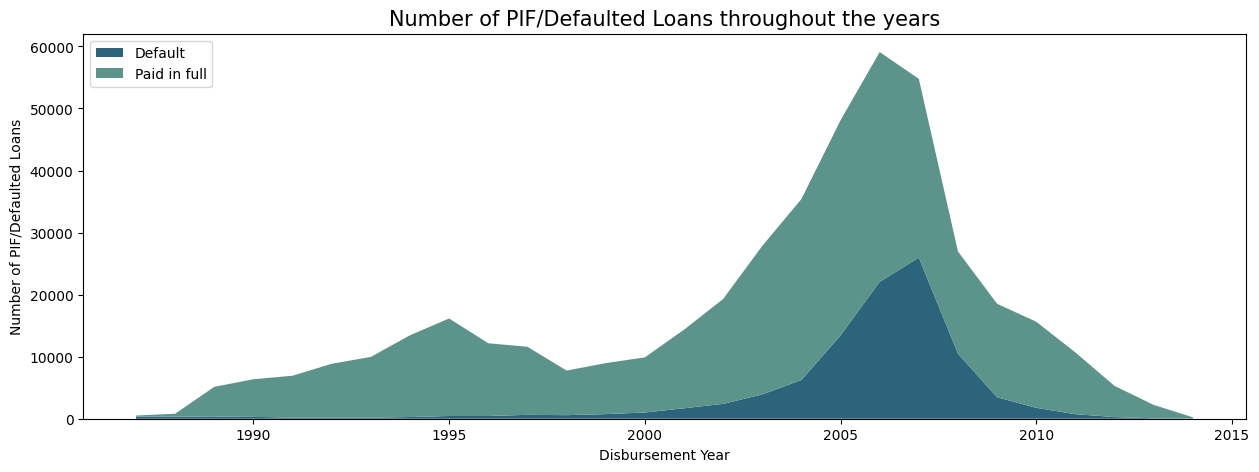

In [ ]:
# Time series data, stackplot is used

fig, ax = plt.subplots(figsize=(15, 5))

stack_data = loans_copy.groupby(['DisbursementYear', 'Default'])['DisbursementYear'].count().unstack('Default')
x = stack_data.index
y = [stack_data[1], stack_data[0]]

colors = ['#2c647b', '#5c938b']

ax.stackplot(x, y, labels=['Default', 'Paid in full'], colors=colors)
ax.set_title('Number of PIF/Defaulted Loans throughout the years', fontsize=15)
ax.set_xlabel('Disbursement Year')
ax.set_ylabel('Number of PIF/Defaulted Loans')
ax.legend(loc='upper left')

plt.show()

**Observation:**

There is an apparent increase in loan volume preceding the Great Recession's peak and a subsequent decline in loan volume just after. Based on the graph, it seems that there was a rise in loan default rates throughout that period as well.

To my surprise, a lot of loans were paid in full righ tbefore the great recession, as well more loans defaulted at that same period.

A further analysis can be conducted for loans in the period of 2003 - 2005

**default + real estate / default + active in recession**

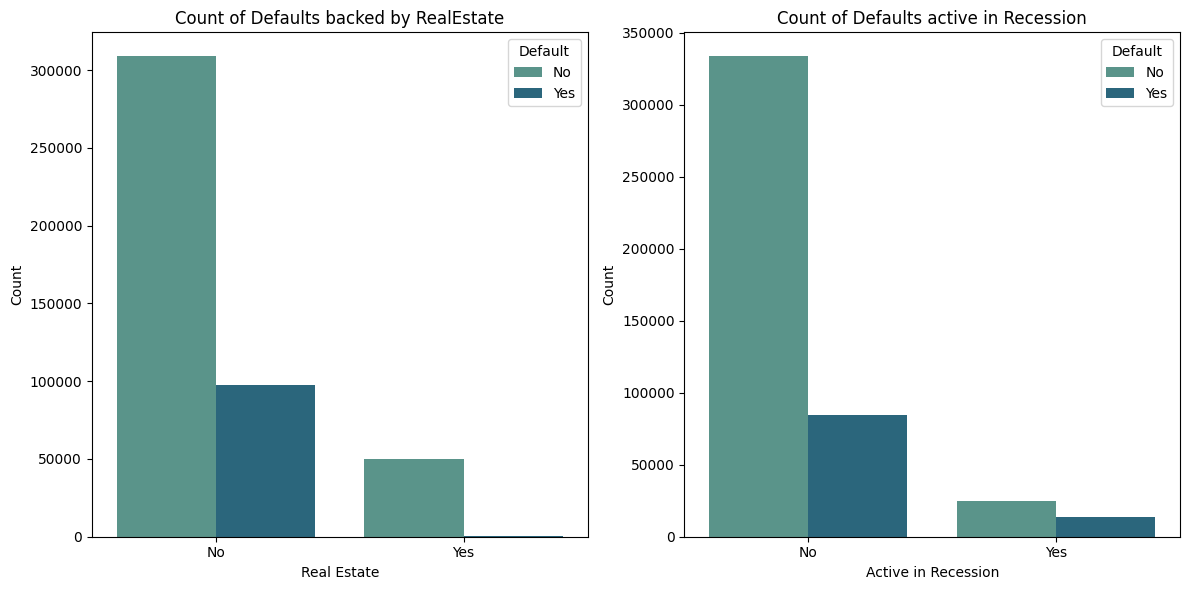

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Default backed by Real Estate
ax0 = sns.countplot(x='RealEstate', hue='Default', data=loans_copy, palette='crest', ax=axes[0], hue_order=[0, 1])
axes[0].set_title('Count of Defaults backed by RealEstate')
axes[0].set_xlabel('Real Estate')
axes[0].set_ylabel('Count')
axes[0].legend(title='Default', labels=['No', 'Yes'])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No', 'Yes'])

# Default active in Recession
ax1 = sns.countplot(x='GreatRecession', hue='Default', data=loans_copy, palette='crest', ax=axes[1], hue_order=[0, 1])
axes[1].set_title('Count of Defaults active in Recession')
axes[1].set_xlabel('Active in Recession')
axes[1].set_ylabel('Count')
axes[1].legend(title='Default', labels=['No', 'Yes'])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

**Observation:**

The numbers of loans backed by real estate are significantly less than loans not backed by real estate (this make sense due to the fact most business owners are not willing to take that high of a risk). However, the default rate of loans backed by real estate is significantly higher than the ones that default. This suggest that business owners have calculated their risk and have what it takes to repay on time.

The loans active in recession have higher default rate than the ones that are not active in recession. This signifies that an economic collapse may be a big factor on loans getting defaulted.

Next, I would like to see how NoEmp (Number of Employees) affects a business' default loan.

`NoEmp` has a wide range, I will categorize it based on [this](https://learn.microsoft.com/en-us/linkedin/shared/references/reference-tables/company-size-codes) Microsoft article.

In [ ]:
# Define bins and labels
bins = [0, 10, 50, 200, 500, 1000, 5000, float('inf')]
labels = ['1-10 employees', '11-50 employees', '51-200 employees', '201-500 employees', '501-1000 employees',
          '1001-5000 employees', '5001-10,000 employees']

# Categorize NoEmp and create new column NoEmpGroup
loans_copy['CompanySize'] = pd.cut(loans_copy['NoEmp'], bins=bins, labels=labels, right=False)

#Check if NoEmp is created and as expected resuts
print(loans_copy[['NoEmp', 'CompanySize']].head())

   NoEmp      CompanySize
0      4   1-10 employees
1      2   1-10 employees
2      7   1-10 employees
5     19  11-50 employees
7      1   1-10 employees


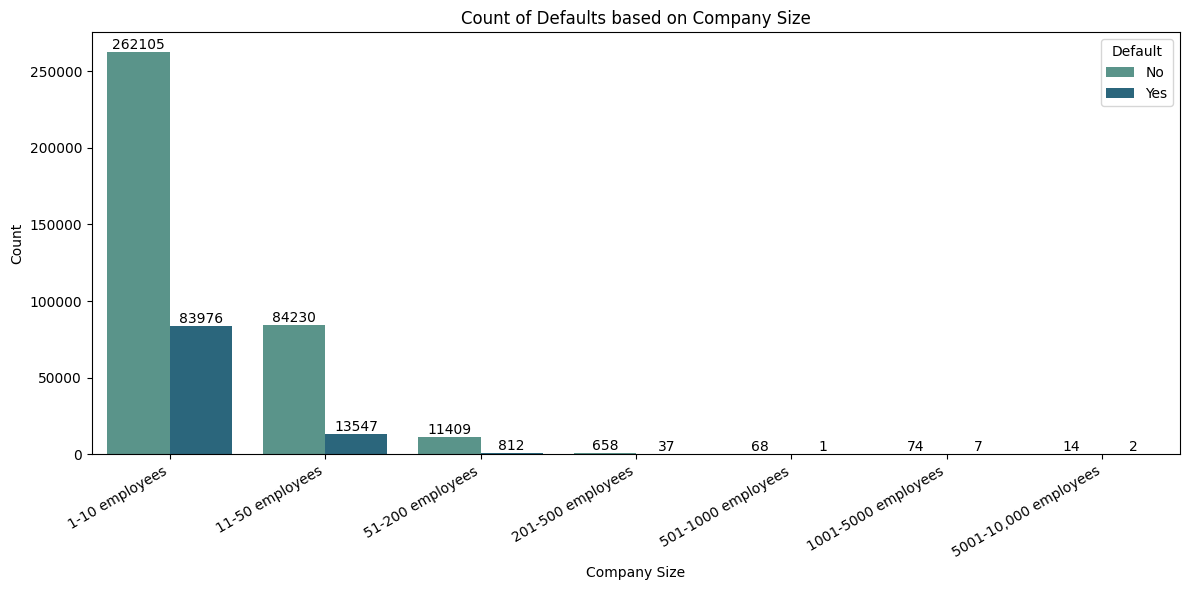

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

plot = sns.countplot(x='CompanySize', hue='Default', data=loans_copy, palette='crest', ax=ax)
ax.set_title('Count of Defaults based on Company Size')
ax.set_xlabel('Company Size')
ax.set_ylabel('Count')
ax.legend(title='Default', labels=['No', 'Yes'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# Add counts on top of each bar
for container in plot.containers:
    plot.bar_label(container, fmt='%d', label_type='edge')

plt.tight_layout()
plt.show()


As expected by the descriptive statistics on NoEmp, most businesses have 1-10 employees. I am interested in seeing the percentage ratio on default.

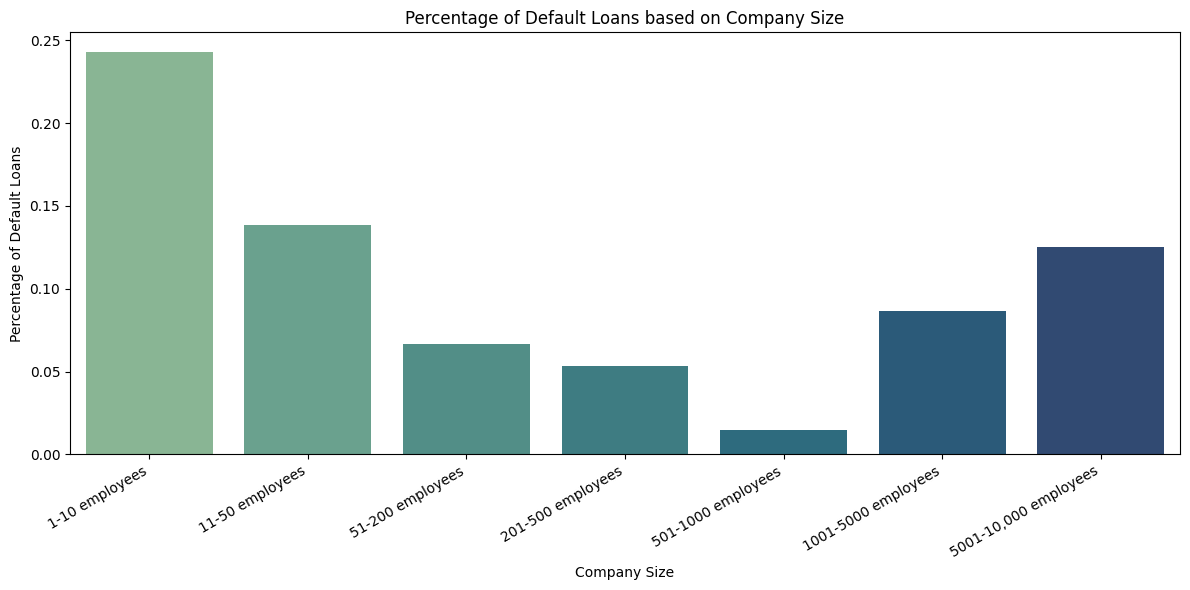

In [ ]:
# Group by CompanySize and Default, then calculate the count
grouped = loans_copy.groupby(['CompanySize', 'Default']).size().reset_index(name='count')

# Calculate the percentage
total_counts = loans_copy.groupby('CompanySize').size().reset_index(name='total_count')
merged = pd.merge(grouped, total_counts, on='CompanySize')
merged['percentage'] = merged['count'] / merged['total_count']

temp_df = merged[['CompanySize', 'Default', 'percentage']]

temp_df = temp_df[temp_df['Default'] == 1]

plt.figure(figsize=(12, 6))
sns.barplot(x='CompanySize', y='percentage', data=temp_df, palette='crest')
plt.title('Percentage of Default Loans based on Company Size')
plt.xlabel('Company Size')
plt.ylabel('Percentage of Default Loans')
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

**Observation:**

Interestingly, there seems to be a downtrend in default percentage upto businesses with 501-1000 employees and it slowly rises again.

A few assumptions I have in mind are:
1. Businesses with mid-sized employees have good track record of their cashflow, resulting in low default ratio.
2. The bigger the business, the more salaries and benefits they have to pay, insisting in applying for a loan.

## **7. Deep Dive Questions Analysis**

1. What is the correlation between the loan amount (DisbursementGross) and the size of the business?
2. How does Retail_trade, Construction, and Prof/Science/Tech industry sectors correlate with `RevLineCr`, `LowDoc`, and `StateSame`?
3. How does `SBA_AppvPercent` corelate with `Industry` and Company Size?

### **7.1 What is the correlation between the loan amount (Gross Approved by Bank) with the size of the business?**

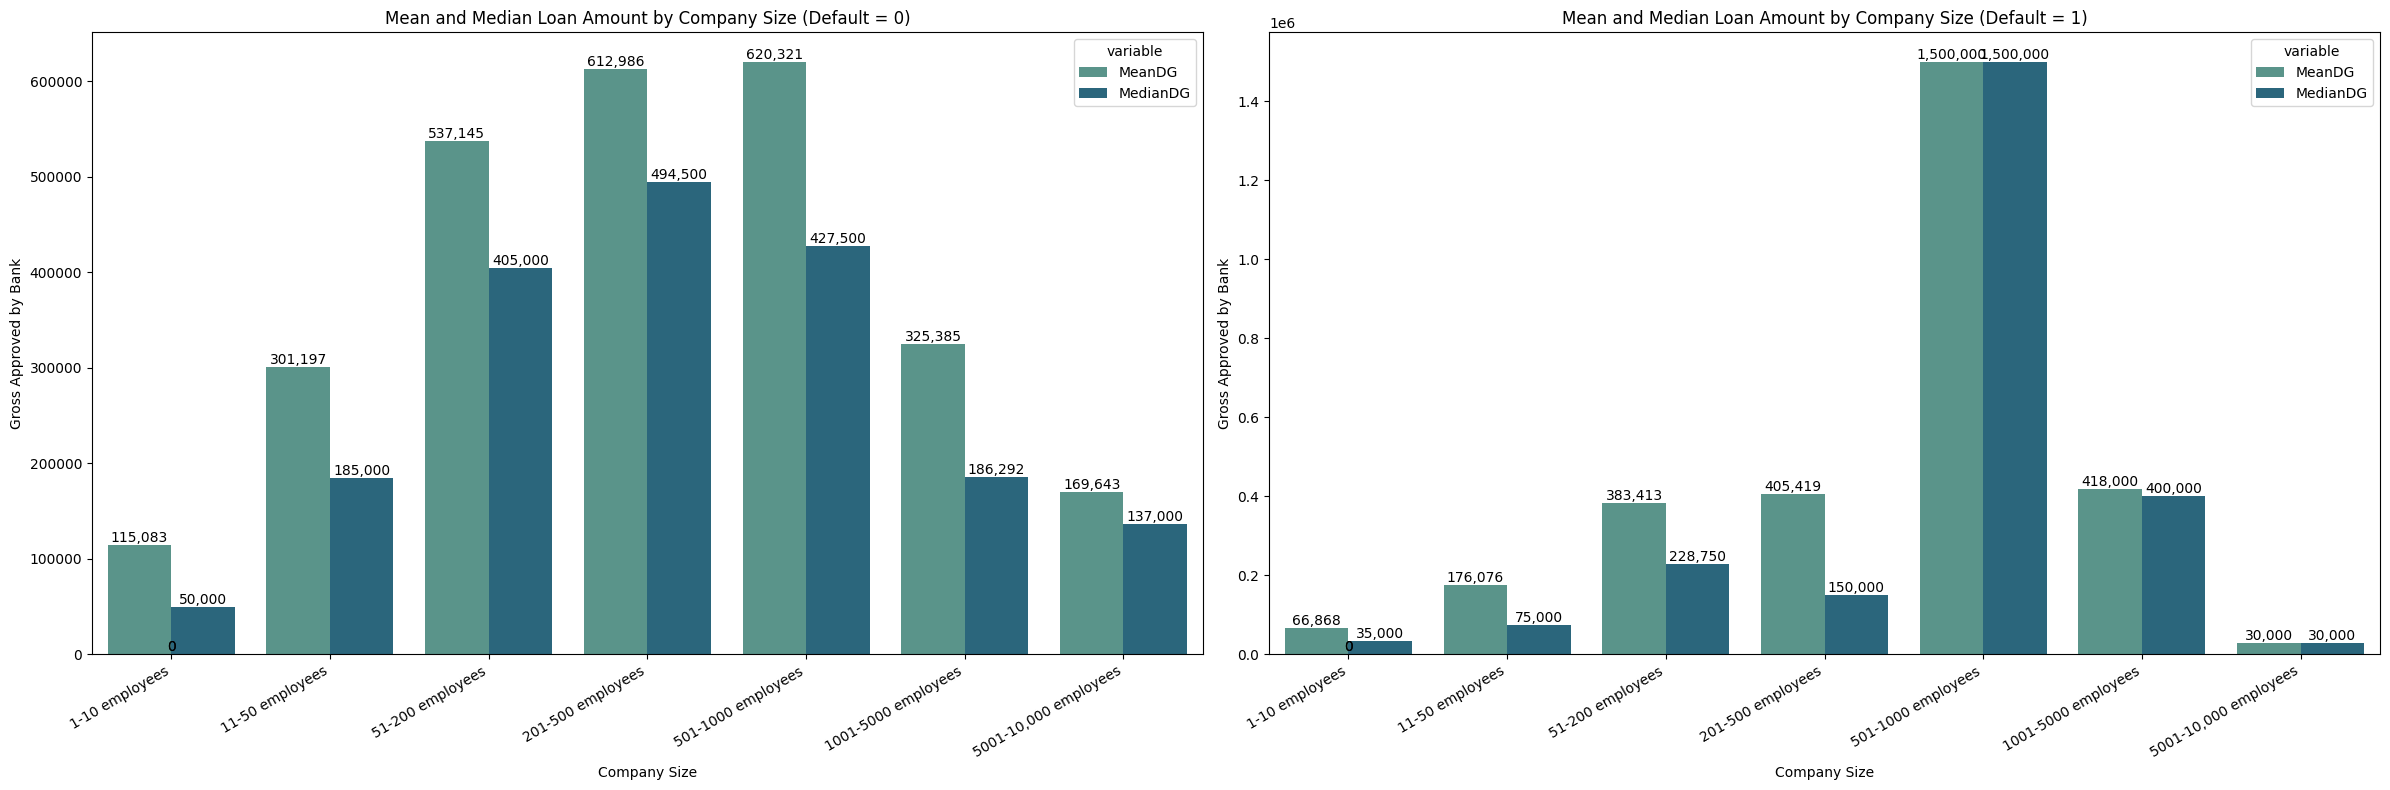

In [ ]:
# Calculate mean and median loan amounts by company size and default status
mean_loan_by_size_default = loans_copy.groupby(['CompanySize', 'Default'])['GrAppv'].mean().reset_index(name='MeanDG')
median_loan_by_size_default = loans_copy.groupby(['CompanySize', 'Default'])['GrAppv'].median().reset_index(name='MedianDG')

# Merge mean and median dataframes
mean_median_loan_stats = pd.merge(mean_loan_by_size_default, median_loan_by_size_default, on=['CompanySize', 'Default'])

plt.figure(figsize=(24, 8))

# Default = 0
plt.subplot(1, 2, 1)
default_0_stats = mean_median_loan_stats[mean_median_loan_stats['Default'] == 0]
sns.barplot(data=default_0_stats.melt(id_vars='CompanySize', value_vars=['MeanDG', 'MedianDG']),
            x='CompanySize', y='value', hue='variable', palette='crest')
plt.title('Mean and Median Loan Amount by Company Size (Default = 0)')
plt.xlabel('Company Size')
plt.ylabel('Gross Approved by Bank')
plt.xticks(rotation=30, ha='right')

# Default = 1
plt.subplot(1, 2, 2)
default_1_stats = mean_median_loan_stats[mean_median_loan_stats['Default'] == 1]
sns.barplot(data=default_1_stats.melt(id_vars='CompanySize', value_vars=['MeanDG', 'MedianDG']),
            x='CompanySize', y='value', hue='variable', palette='crest')
plt.title('Mean and Median Loan Amount by Company Size (Default = 1)')
plt.xlabel('Company Size')
plt.ylabel('Gross Approved by Bank')
plt.xticks(rotation=30, ha='right')

# Add text annotations on top of bars
for ax in plt.gcf().axes:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()

**Observation:**

Although percentage wise there has been an increase in defaults on big-sized businesses, the median amount of funds they loan are not too far from small-sized businesses.

Interestingly enough, mid-sized businesses tend to apply for a larger loan sum; even larget than big-size businesses, but the default rate is the smallest out of each business size category. My assumption is that these businesses found their sweet spot in regulating their cashflow and priorities.

There seems to be an outlier where a mid-sized business was disbursed a large sum of loan funds and ended up defaulting. This further suggest that there may be inadequate vetting or the banks approving the loans may be encouraging risky borrowing.

### 7.2 How does Retail_trade, Construction, and Prof/Science/Tech industry sectors correlate with `RevLineCr`, `LowDoc`, and `StateSame`?

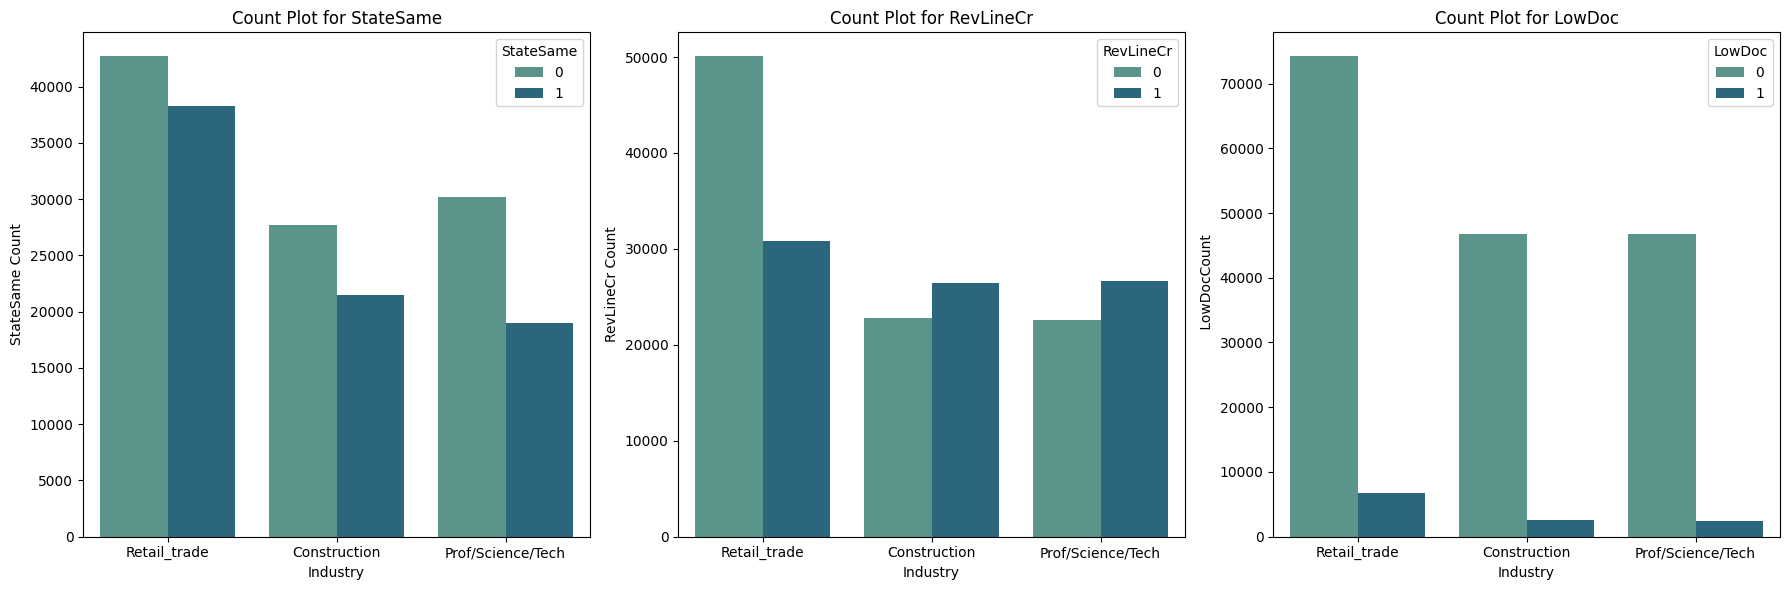

In [ ]:
filtered_df = loans_copy[loans_copy['Industry'].isin(['Retail_trade', 'Construction', 'Prof/Science/Tech'])]

plt.figure(figsize=(18, 6))

# StateSame
plt.subplot(1, 3, 1)
sns.countplot(data=filtered_df, x='Industry', hue='StateSame', palette='crest')
plt.title('Count Plot for StateSame')
plt.xlabel('Industry')
plt.ylabel('StateSame Count')

# RevLineCr
plt.subplot(1, 3, 2)
sns.countplot(data=filtered_df, x='Industry', hue='RevLineCr', palette='crest')
plt.title('Count Plot for RevLineCr')
plt.xlabel('Industry')
plt.ylabel('RevLineCr Count')

# LowDoc
plt.subplot(1, 3, 3)
sns.countplot(data=filtered_df, x='Industry', hue='LowDoc', palette='crest')
plt.title('Count Plot for LowDoc')
plt.xlabel('Industry')
plt.ylabel(' LowDocCount')

plt.tight_layout()
plt.show()

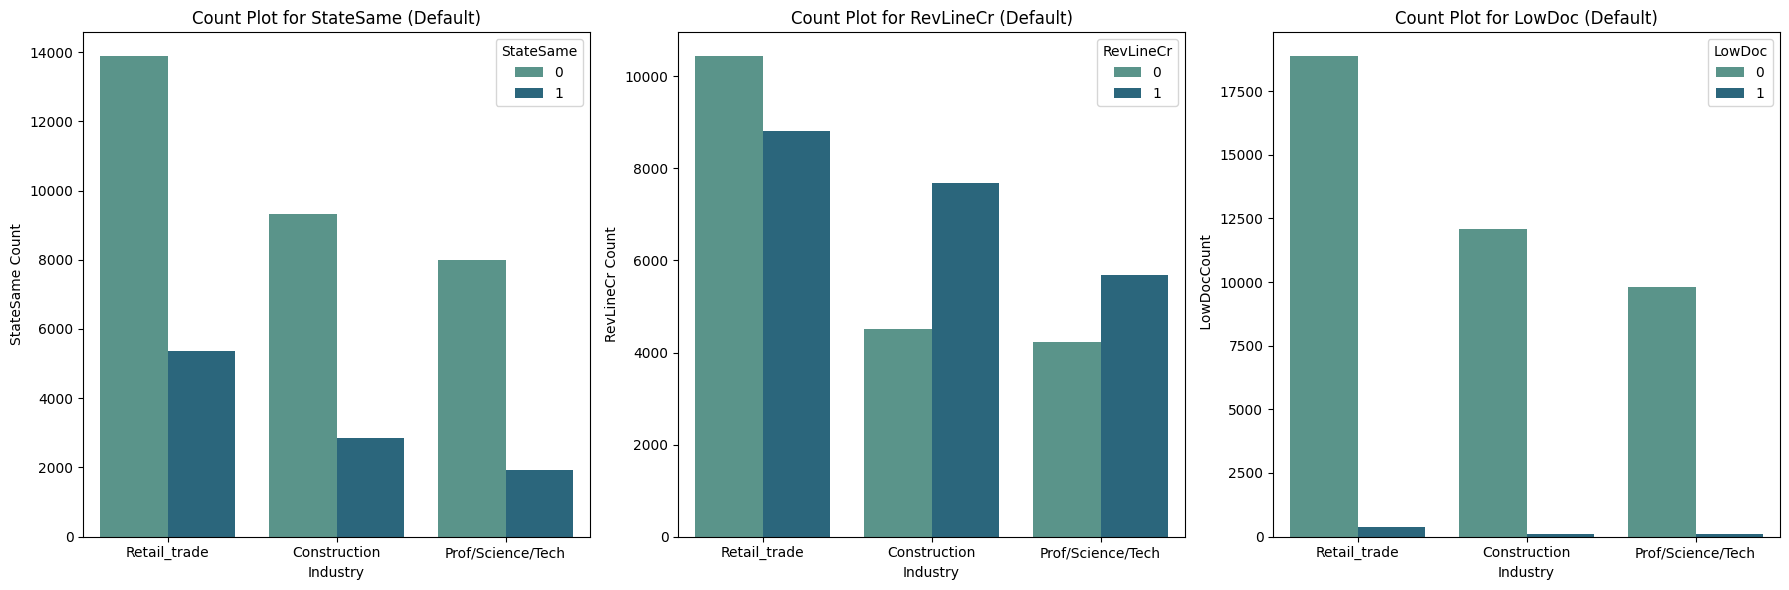

In [ ]:
loans_copy_default = loans_copy[loans_copy['Default'] == 1]

filtered_df = loans_copy_default[loans_copy_default['Industry'].isin(['Retail_trade', 'Construction', 'Prof/Science/Tech'])]

plt.figure(figsize=(18, 6))

# StateSame
plt.subplot(1, 3, 1)
sns.countplot(data=filtered_df, x='Industry', hue='StateSame', palette='crest')
plt.title('Count Plot for StateSame (Default)')
plt.xlabel('Industry')
plt.ylabel('StateSame Count')

# RevLineCr
plt.subplot(1, 3, 2)
sns.countplot(data=filtered_df, x='Industry', hue='RevLineCr', palette='crest')
plt.title('Count Plot for RevLineCr (Default)')
plt.xlabel('Industry')
plt.ylabel('RevLineCr Count')

# LowDoc
plt.subplot(1, 3, 3)
sns.countplot(data=filtered_df, x='Industry', hue='LowDoc', palette='crest')
plt.title('Count Plot for LowDoc (Default)')
plt.xlabel('Industry')
plt.ylabel(' LowDocCount')

plt.tight_layout()
plt.show()

**Observation:**

We can see that loans from these industries that default often involve the use of a revolving line of credit. This suggests that businesses which defaulted on their loans may be experiencing higher credit utilization, indicating possible cash flow problems or financial difficulties.

In particular, it is common for businesses in the Construction and Prof/Science/Tech industries to default while utilizing a revolving line of credit. This is due to their business practices and heavy reliance on debt. These businesses typically depend on future sales of their products or services to repay their loans, which can take time.

The majority of businesses applying for loans are not from the same state as their applicant data, suggesting that banks in certain states have easier approval processes, larger loan amounts, and looser regulations. This could lead businesses to seek out states with lenient banking regulations, faster approvals, and larger loan amounts. The discrepancy between applicant and loan states may indicate that businesses are strategically choosing lenders based on their likelihood of approval and better loan terms, suggesting areas for strengthened regulatory oversight to ensure fair lending practices across different regions.

### **7.3 How does `SBA_AppvPercent` corelate with `Industry` and Company Size?**

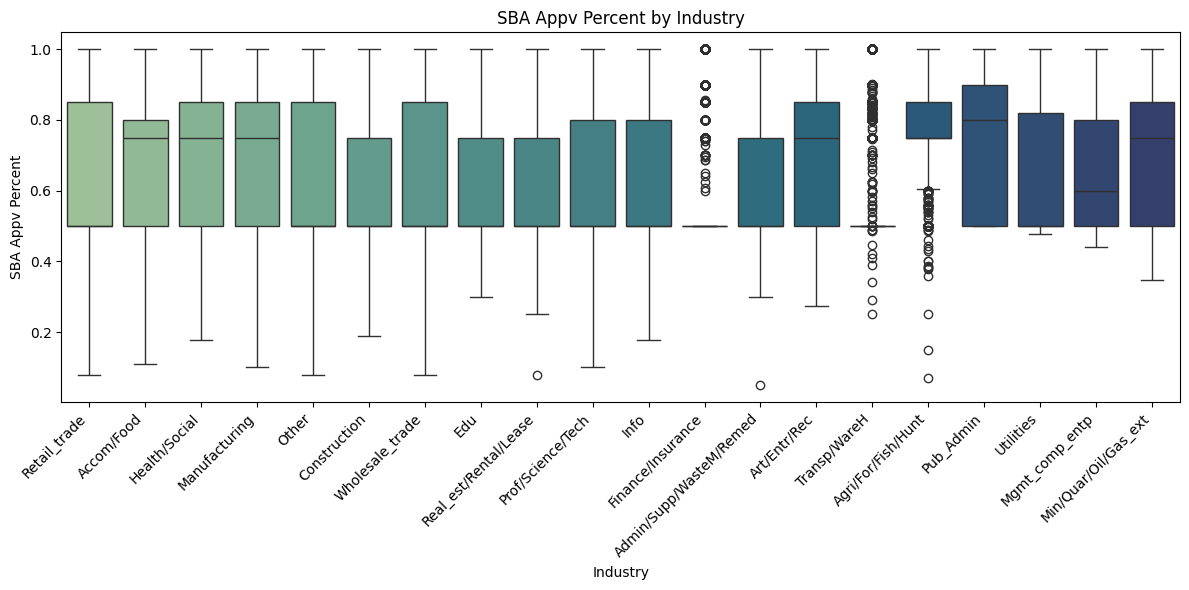

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=loans_copy, x='Industry', y='SBA_AppvPercent', palette='crest')
plt.title('SBA Appv Percent by Industry')
plt.xlabel('Industry')
plt.ylabel('SBA Appv Percent')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

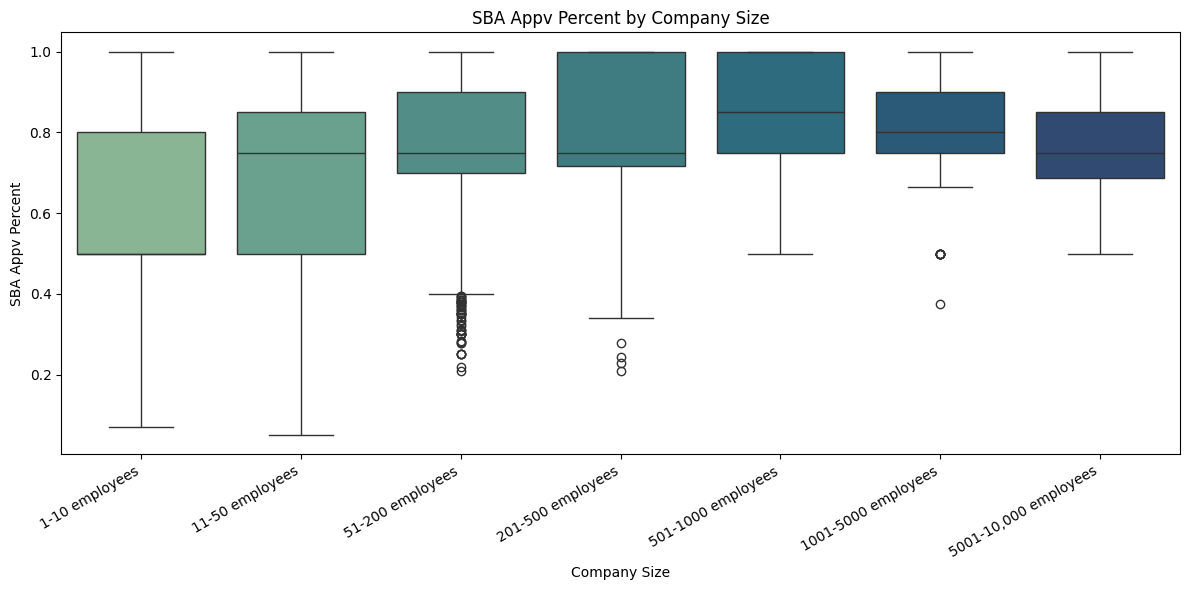

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=loans_copy, x='CompanySize', y='SBA_AppvPercent', palette='crest')
plt.title('SBA Appv Percent by Company Size')
plt.xlabel('Company Size')
plt.ylabel('SBA Appv Percent')
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

**Observation:**

A majority of industries, including Retail Trade, Construction, and Professional/Scientific/Technical, have an average SBA loan approval rate of around 60-75%. This high approval rate may be a key factor in why many defaults occur. Businesses that apply for these loans may exploit the high approval percentage to mitigate their own risk, effectively transferring the risk to the SBA.

On the other hand, the larger the business in terms of employee size, the higher the average approval percentage from the SBA. This indicates that the SBA conducts a more thorough review of loan applications for larger businesses, which is a positive sign.

Although, majority of 1001-5000 employee & 5001-10000 employee businesses have a slight lower average on the 75% quartile mark.

## **8. Base Model**

In [ ]:
# Copy laons dataframe for base modeling to see how it performs without any preprocessing.
loans_base = loans.copy()

### **8.1 Preprocessing**

In [ ]:
data_info(loans_base)

Rows,Columns (899164, 27)
Duplicated Values 0
=====



missingValue  percentMissing DataType  Unique
ChgOffDate               736465       81.905526   object    6448
RevLineCr                  4528        0.503579   object      18
LowDoc                     2582        0.287156   object       8
DisbursementDate           2368        0.263356   object    8472
MIS_Status                 1997        0.222095   object       2
BankState                  1566        0.174162   object      56
Bank                       1559        0.173383   object    5802
NewExist                    136        0.015125  float64       3
City                         30        0.003336   object   32581
State                        14        0.001557   object      51
Name                         14        0.001557   object  779583
LoanNr_ChkDgt                 0        0.000000    int64  899164
GrAppv                        0        0.000000   object   22128
ChgOffPrinGr                  0        0.000000   object   83165
BalanceGross                  0        0.000000   object      15
DisbursementGross             0        0.000000   object  118859
CreateJob                     0        0.000000    int64     246
UrbanRural                    0        0.000000    int64       3
FranchiseCode                 0        0.000000    int64    2768
RetainedJob                   0        0.000000    int64     358
NoEmp                         0        0.000000    int64     599
Term                          0        0.000000    int64     412
ApprovalFY                    0        0.000000   object      70
ApprovalDate                  0        0.000000   object    9859
NAICS                         0        0.000000    int64    1312
Zip                           0        0.000000    int64   33611
SBA_Appv                      0        0.000000   object   38326

I'm going to remove unrelevant features that I think will not affect the model:
1. ChgOffDate
2. Bank
3. City
4. Name
5. LoanNr_ChkDgt
6. Zip

In [ ]:
# Drop potential unrelated and fields with too much uniqueness fields

loans_base.drop(['ChgOffDate', 'Bank', 'City', 'Name', 'LoanNr_ChkDgt', 'Zip'], axis=1, inplace=True)

In [ ]:
# Clean the string from integer data

loans_base['ApprovalFY'] = loans_base['ApprovalFY'].apply(clean_data_str).astype('int64')

In [ ]:
# Remove '$', commas, and extra spaces from records in columns with dollar values that should be floats


loans_base[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = \
loans_base[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

In [ ]:
# Create enum mapping for each state & map to field

state_mapping = {state: idx for idx, state in enumerate([
    'IN', 'OK', 'FL', 'CT', 'NJ', 'NC', 'IL', 'RI', 'TX', 'VA',
    'TN', 'AR', 'MN', 'MO', 'MA', 'CA', 'SC', 'LA', 'IA', 'OH',
    'KY', 'MS', 'NY', 'MD', 'PA', 'OR', 'ME', 'KS', 'MI', 'AK',
    'WA', 'CO', 'MT', 'WY', 'UT', 'NH', 'WV', 'ID', 'AZ', 'NV',
    'WI', 'NM', 'GA', 'ND', 'VT', 'AL', 'NE', 'SD', 'HI', 'DE', 'DC'
])}

loans_base['State'] = loans_base['State'].map(state_mapping)

In [ ]:
# Create one-hot encoding enum mapping for each state & map to field

bank_state_mapping = {state: idx for idx, state in enumerate([
    'OH', 'IN', 'OK', 'FL', 'DE', 'SD', 'AL', 'CT', 'GA', 'OR', 'MN', 'RI', 'NC', 'TX',
    'MD', 'NY', 'TN', 'SC', 'MS', 'MA', 'LA', 'IA', 'VA', 'CA', 'IL', 'KY', 'PA', 'MO',
    'WA', 'MI', 'UT', 'KS', 'WV', 'WI', 'AZ', 'NJ', 'CO', 'ME', 'NH', 'AR', 'ND', 'MT',
    'ID', 'WY', 'NM', 'DC', 'NV', 'NE', 'PR', 'HI', 'VT', 'AK', 'GU', 'AN', 'EN', 'VI'
  ])}

loans_base['BankState'] = loans_base['BankState'].map(bank_state_mapping)

In [ ]:
# Convert the 'Date' column to datetime format with the specified format
loans_base['DisbursementDate'] = pd.to_datetime(loans_base['DisbursementDate'], format='%d-%b-%y')
loans_base['ApprovalDate'] = pd.to_datetime(loans_base['ApprovalDate'], format='%d-%b-%y')

# Convert date to float representing days since epoch (1984-07-03 for DisbursementDate) & (1984-04-16 for ApprovalDate)
loans_base['DisbursementDate'] = (loans_base['DisbursementDate'] - pd.Timestamp('1984-07-03')) / pd.Timedelta(days=1)
loans_base['ApprovalDate'] = (loans_base['ApprovalDate'] - pd.Timestamp('1984-04-16')) / pd.Timedelta(days=1)

In [ ]:
# Create one-hot encoding enum mapping for each RevLineCr & map to field

rev_line_cr_mapping = {state: idx for idx, state in enumerate([
    'N', 'Y', '0', 'T', '`', ',', '1', 'C', '2', 'R', '7', 'A', '-', 'Q'
    ])}

loans_base['RevLineCr'] = loans_base['RevLineCr'].map(rev_line_cr_mapping)

In [ ]:
# Create one-hot encoding enum mapping for each LowDoc & map to field

low_doc_mapping = {state: idx for idx, state in enumerate([
    'Y', 'N', 'C', '1', 'S', 'R', 'A', '0'
    ])}

loans_base['LowDoc'] = loans_base['LowDoc'].map(low_doc_mapping)

In [ ]:
# Convert MIS_Status to categorical values

loans_base['MIS_Status'] = loans_base['MIS_Status'].replace(['CHGOFF' ,'P I F'],[1,0])

In [ ]:
# Convert field type to float64 since some are object or string

loans_base = loans_base.astype({
    'DisbursementGross' : 'float64',
    'BalanceGross' : 'float64',
    'ChgOffPrinGr' : 'float64',
    'GrAppv' : 'float64',
    'SBA_Appv' : 'float64',
    })

In [ ]:
# Drop null values from specified columns
loans_base.dropna(subset=['RevLineCr', 'LowDoc', 'DisbursementDate', 'MIS_Status', 'BankState', 'NewExist', 'State'], inplace=True)

In [ ]:
# One-hot encoding for categorical values without rankings

loans_base = pd.get_dummies(loans_base, columns=['State']).astype(int)
loans_base = pd.get_dummies(loans_base, columns=['BankState']).astype(int)
loans_base = pd.get_dummies(loans_base, columns=['RevLineCr']).astype(int)
loans_base = pd.get_dummies(loans_base, columns=['LowDoc']).astype(int)

### **8.2 Data Splitting**

In [ ]:
# Feature
X_base = loans_base.drop(['MIS_Status'],axis=1)

# Target
y_base = loans_base['MIS_Status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

### **8.3 Modeling**

In [ ]:
# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Training set performance
train_accuracy = accuracy_score(y_train, train_preds)
train_precision = precision_score(y_train, train_preds)
train_recall = recall_score(y_train, train_preds)
train_f1 = f1_score(y_train, train_preds)

# Test set performance
test_accuracy = accuracy_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
test_recall = recall_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)

print("Training Set Performance")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("\nTest Set Performance")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")

Training Set Performance
Accuracy: 0.9999985896065284
Precision: 1.0
Recall: 0.9999920031987205
F1 Score: 0.9999960015833729

Test Set Performance
Accuracy: 0.9941327797084443
Precision: 0.969437652811736
Recall: 0.9979026845637584
F1 Score: 0.9834642414220753


Training & Test performance are both concerningly high, especially training recall at perfect score of 1. I need to check feature to see if there are any features that correlate highly or resembles closely with the target variable that may end in data leakage.

In [ ]:
coefficients = model.feature_importances_
feature_names = X_base.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False).reset_index(drop=True)

importance_df

Feature   Coefficient
0         ChgOffPrinGr  6.423085e-01
1                 Term  1.389214e-01
2         ApprovalDate  3.151750e-02
3     DisbursementDate  2.585414e-02
4           ApprovalFY  2.288361e-02
5             SBA_Appv  1.495061e-02
6               GrAppv  1.322306e-02
7    DisbursementGross  1.231079e-02
8                NAICS  1.050761e-02
9        FranchiseCode  9.186485e-03
10         RetainedJob  8.649556e-03
11          UrbanRural  8.106410e-03
12               NoEmp  6.616395e-03
13           CreateJob  4.090293e-03
14        BankState_23  3.928166e-03
15         RevLineCr_1  3.707659e-03
16        BankState_12  2.894052e-03
17        BankState_22  2.624602e-03
18         RevLineCr_2  2.420365e-03
19         RevLineCr_0  2.340959e-03
20            NewExist  2.244132e-03
21          State_15.0  2.181851e-03
22         RevLineCr_3  1.565636e-03
23           State_2.0  1.295902e-03
24        BankState_24  1.228217e-03
25            LowDoc_1  1.183003e-03
26            LowDoc_0  9.571556e-04
27         BankState_5  8.809738e-04
28         BankState_0  8.780053e-04
29           State_8.0  7.689842e-04
30          State_22.0  7.254209e-04
31         BankState_4  6.965734e-04
32        BankState_11  6.944364e-04
33        BankState_15  6.601170e-04
34        BankState_26  6.243912e-04
35          State_42.0  5.232333e-04
36          State_24.0  5.063339e-04
37           State_6.0  5.029356e-04
38        BankState_13  4.754399e-04
39          State_19.0  4.448770e-04
40           State_4.0  4.406732e-04
41           State_9.0  3.860806e-04
42          State_28.0  3.706343e-04
43         BankState_3  3.598544e-04
44          State_23.0  3.540819e-04
45          State_14.0  3.413632e-04
46           State_5.0  3.384392e-04
47         BankState_9  3.316063e-04
48          State_38.0  3.127960e-04
49          State_13.0  2.948911e-04
50          State_34.0  2.838596e-04
51          State_31.0  2.706465e-04
52          State_30.0  2.681921e-04
53         BankState_6  2.640047e-04
54          State_12.0  2.637178e-04
55        BankState_10  2.605681e-04
56          State_10.0  2.581251e-04
57        BankState_19  2.465003e-04
58          State_40.0  2.430119e-04
59          State_39.0  2.333790e-04
60        BankState_30  2.326872e-04
61           State_0.0  2.310026e-04
62        BankState_27  2.194796e-04
63           State_3.0  2.181011e-04
64         BankState_8  2.171954e-04
65          State_17.0  2.133774e-04
66        BankState_41  1.992518e-04
67          State_45.0  1.957201e-04
68         BankState_7  1.881847e-04
69          State_16.0  1.875827e-04
70           State_1.0  1.861751e-04
71        BankState_33  1.812243e-04
72          State_27.0  1.728155e-04
73          State_32.0  1.700170e-04
74          State_20.0  1.678171e-04
75          State_35.0  1.643019e-04
76        BankState_17  1.636720e-04
77          State_25.0  1.631538e-04
78          State_21.0  1.621468e-04
79         BankState_1  1.544840e-04
80        BankState_35  1.385671e-04
81          State_26.0  1.366687e-04
82           State_7.0  1.365646e-04
83          State_11.0  1.328321e-04
84          State_18.0  1.319643e-04
85          State_37.0  1.284773e-04
86          State_50.0  1.224996e-04
87        BankState_31  1.183284e-04
88        BankState_36  1.181510e-04
89          State_43.0  1.127567e-04
90          State_48.0  1.124512e-04
91          State_41.0  1.093699e-04
92        BankState_18  1.089341e-04
93        BankState_21  1.085307e-04
94        BankState_39  1.073781e-04
95        BankState_29  1.071691e-04
96         BankState_2  1.024567e-04
97          State_46.0  1.023677e-04
98          State_36.0  1.010244e-04
99        BankState_28  9.669674e-05
100       BankState_46  9.523153e-05
101       BankState_14  9.120956e-05
102         State_44.0  9.063775e-05
103       BankState_37  8.990086e-05
104       BankState_16  8.523687e-05
105         State_49.0  8.214943e-05
106       BankState_40  8.084073e-05
107       BankState

One feature that may leak is `ChgOffPrinGr`, it directly correlates to `MIS_Status` due to the fact it only gets data if the loan has been charged off. This proves my assumption is correct there is data leakage on this model and I need to further tune it.

Furthermore, the heatmap displayed on the previous section showed that there are some features that causes multicollinearity. This needs to be addressed on the preprocessing (modeling) phase.

## **9. Data Preprocessing (Modeling)**

### **9.1 Outlier Handling**

Before I go on processing the data for modelling, I need to handle the outliers based on `6.2 Outliers`. I can see from there that there are some negative data that needs to be assessed which is `DaysToDisbursement`.

In [ ]:
loans_copy = loans_copy[loans_copy['DaysToDisbursement'] > 0]

In [ ]:
features_many_dimensions = ['DaysToDisbursement', 'SBA_Appv', 'GrAppv', 'DisbursementGross',
                            'RetainedJob', 'CreateJob', 'NoEmp', 'Term', 'ApprovalFY']

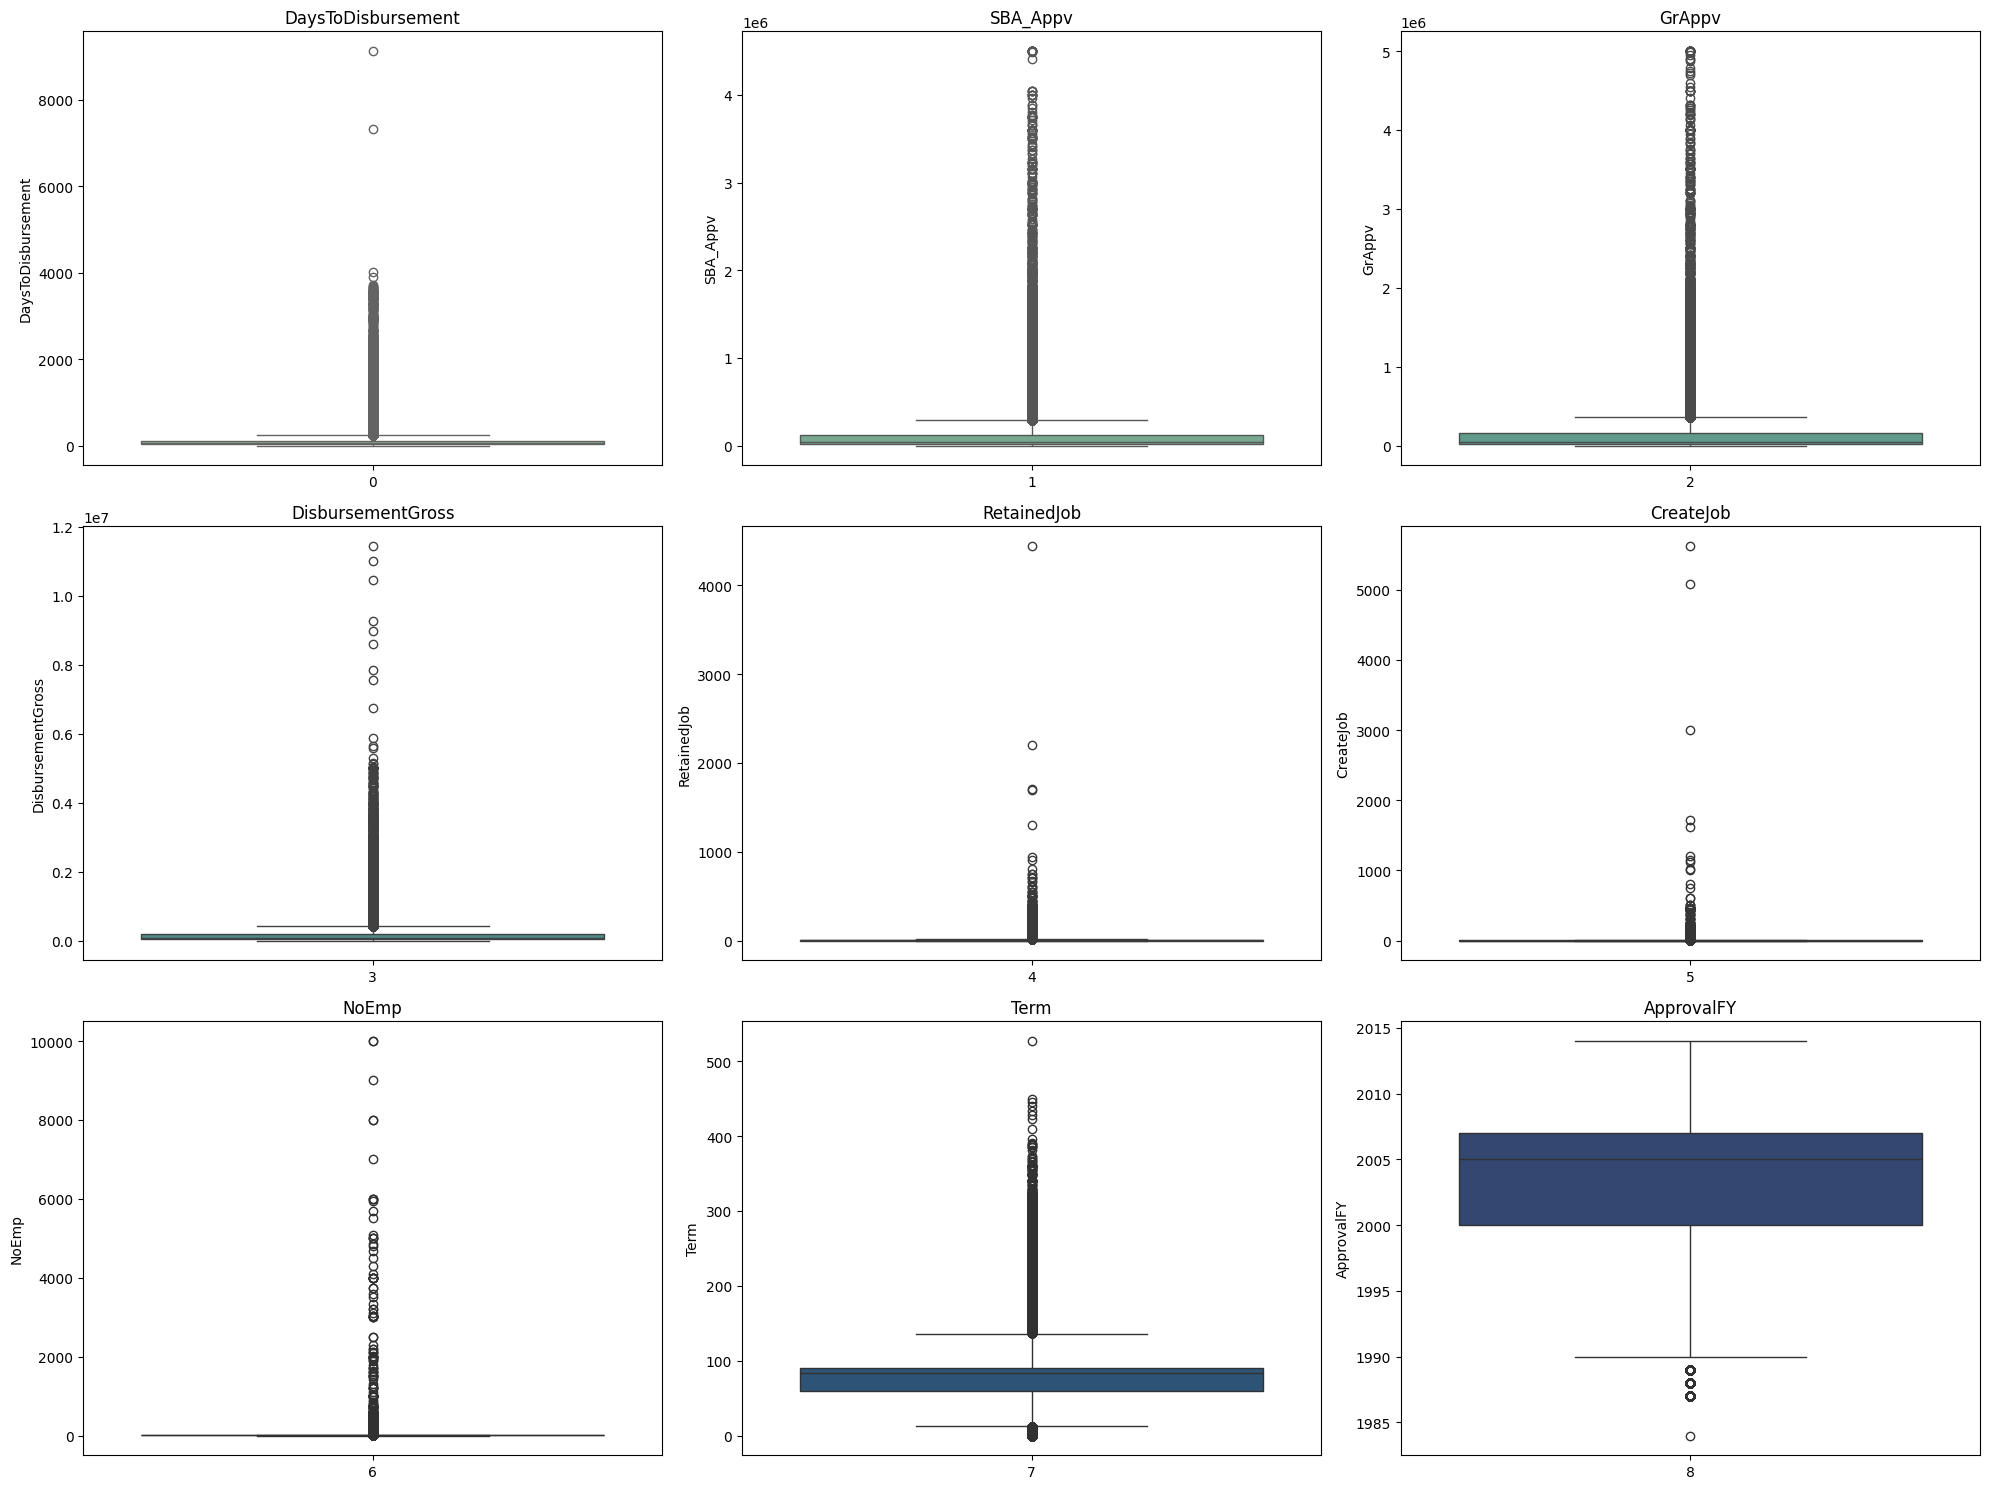

In [ ]:
outlier_plot(loans_copy, features_many_dimensions)

ApprovalFY seems to be normally skewed, while the rest of the data tend to be leftly skewed.

### **9.2 Preprocessing**

In [ ]:
# Copy data for model

loans_model_df = loans_copy.copy()

Here are the fields I plan to drop from the modeling phase, along with the reasons for each:

1. **LoanNr_ChkDgt**: This acts as a row identifier and does not contribute to the analysis.
2. **ChgOffDate**: This field only indicates when the loan was charged off, which doesn't add value to the analysis.
3. **Name**, **Zip**, **City**, **Bank**: These fields are too specific to individual users and are not useful for the analysis.
4. **NAICS**: I have already created a related field called "Industry", making this redundant.
5. **MIS_Status**: I have already created a related field called "Default", making this redundant.
6. **NewExist**: I have already created a related field called "NewBusiness", making this redundant.
7. **FranchiseCode**: I have already created a related field called "IsFranchise", due to the fact franchise code may be irrelevant for the analysis.
8. **Industry**: I have already created a related field called "IndustryCode", making this redundant.
9. **ApprovalDate** & **DisbursementDate**: I have created a related field called "DaysToDisbursement", making these not useful anymore for modeling.

In [ ]:
# Drop respected columns

loans_model_df.drop(columns=['LoanNr_ChkDgt', 'ChgOffDate', 'Name', 'City', 'Zip', 'Bank', 'NAICS', 'MIS_Status', 'NewExist', 'FranchiseCode',
                      'ApprovalDate', 'DisbursementDate'], inplace=True)

In [ ]:
# Encoding like base model encoding

loans_model_df['State'] = loans_model_df['State'].map(state_mapping)
loans_model_df['BankState'] = loans_model_df['BankState'].map(bank_state_mapping)

In [ ]:
loans_model_df = loans_model_df.astype({
    'IndustryCode' : 'int64',
    'UrbanRural': 'int64'
    })

### **9.3 Calculate VIF Score & Multicollinearity Test**

#### **9.3.1 Data Splitting**

Industry field cannot be processed in correlation matrix, so we create a copy dataframe for this purpose.

In [ ]:
loans_matrix_df = loans_model_df.copy()

In [ ]:
loans_matrix_df.drop(columns=['Industry', 'CompanySize'], inplace=True)

In [ ]:
X = loans_matrix_df.drop(columns=['Default'])
y = loans_matrix_df[['Default']]

In [ ]:
# Split the data
X_train_mt, X_test_mt, y_train_mt, y_test_mt = train_test_split(X, y, test_size=0.2, random_state=42)

#### **9.3.2 Multicollinearity Test**

In [ ]:
X = add_constant(X_train_mt)

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

feature   vif_score
1                State    1.087654
2            BankState    1.228724
3           ApprovalFY  394.863761
4                 Term    4.203494
5                NoEmp    1.059005
6            CreateJob    1.030736
7          RetainedJob    1.097022
8           UrbanRural    2.250131
9            RevLineCr    2.839041
10              LowDoc    1.240983
11   DisbursementGross   10.945024
12        BalanceGross    1.000178
13        ChgOffPrinGr    1.093285
14              GrAppv   54.211816
15            SBA_Appv   40.622255
16        IndustryCode    1.053580
17         NewBusiness    1.070467
18         IsFranchise    1.037778
19  DaysToDisbursement    4.721228
20   DisbursementMonth    1.652942
21    DisbursementYear  384.614499
22           StateSame    1.371452
23     SBA_AppvPercent    3.682781
24       AppvDisbursed    1.878802
25          RealEstate    3.812315
26      GreatRecession    1.138090

`ApprovalFY`, `Term`, `DisbursementGross`, `GrAppv`, `SBA_Appv`, `DisbursementYear` have really high VIF score, I need to address the multicollinearity.

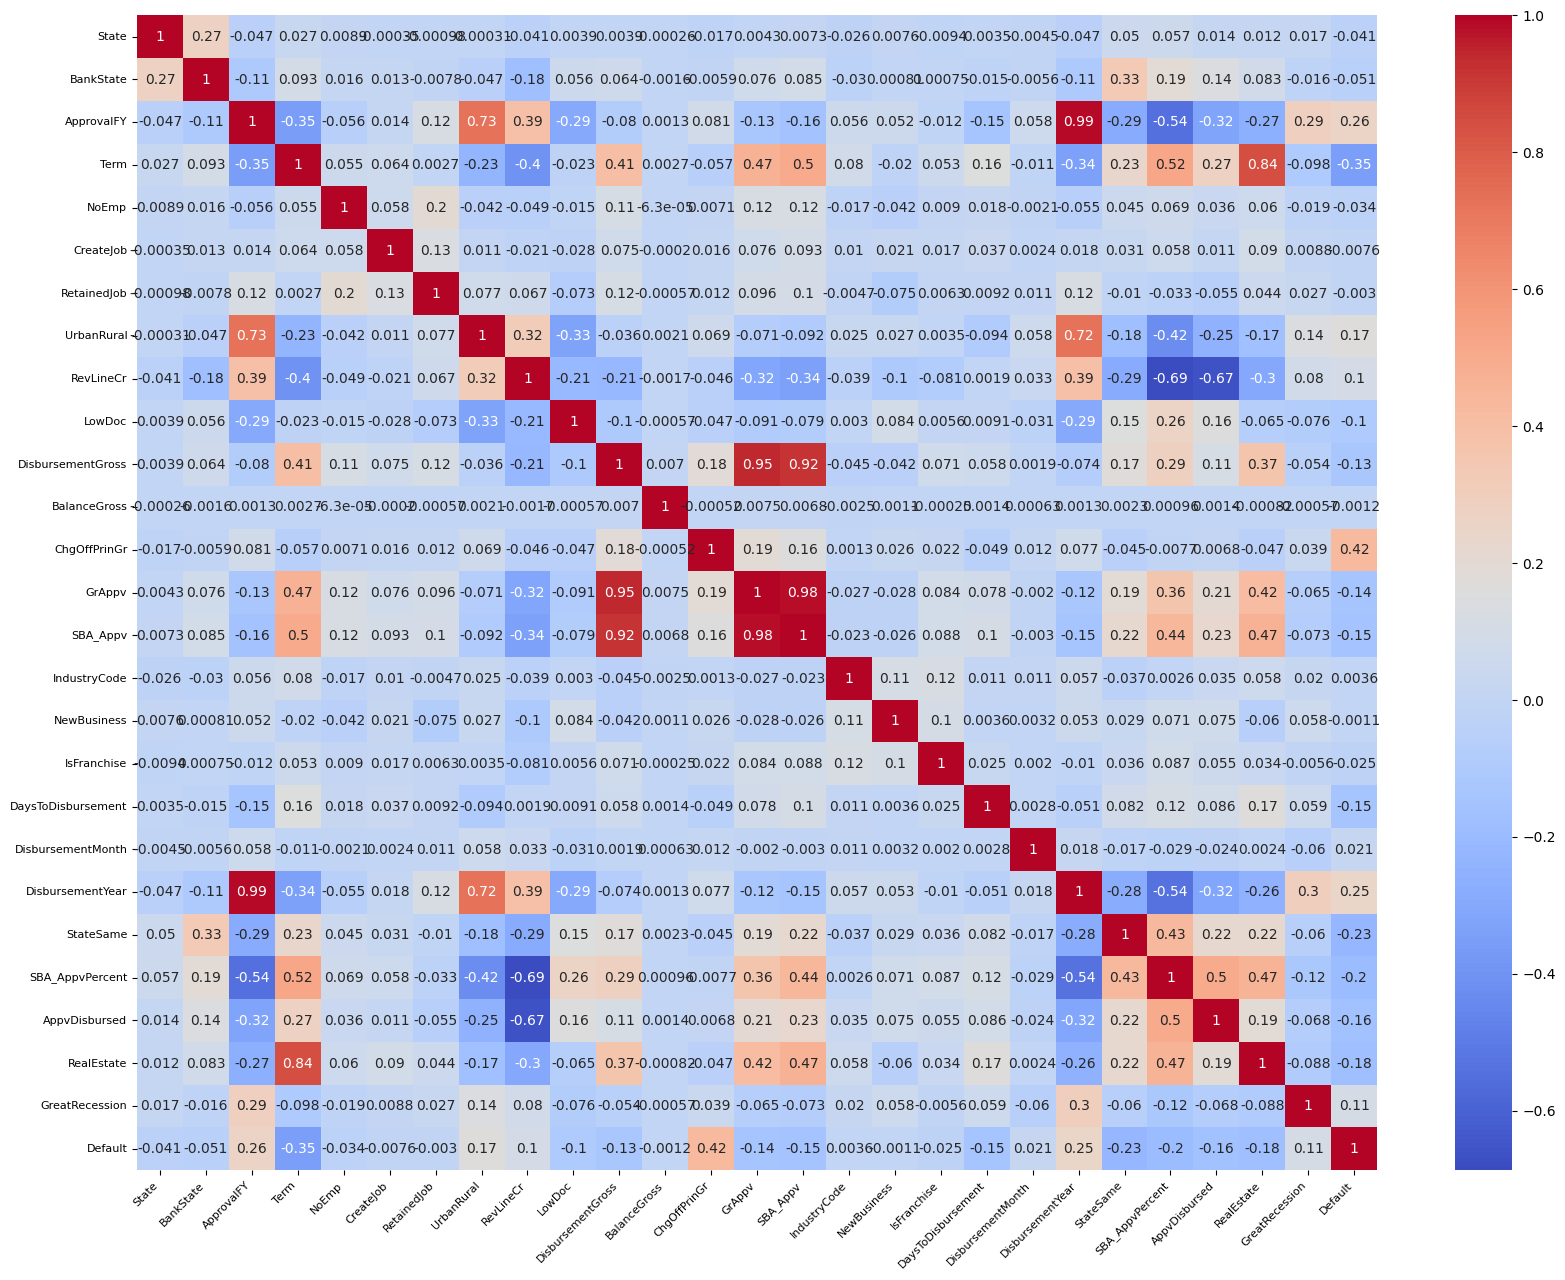

In [ ]:
# Correlation Matrix
cor_fig, cor_ax = plt.subplots(figsize=(20, 15))
corr_matrix = loans_matrix_df.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

Feature pairs with high multicollinearity:
1. ApprovalFY & UrbanRural
2. ApprovalFY & DisbursementYear
3. Term & Real Estate
4. UrbanRural & DisbursementYear
5. DisbursementGross & GrAppv
6. DisbursementGross & SBA_Appv
7. GrAppv & SBA_Appv


- Remove UrbanRural due to lowest correlation with target variable
- Remove Real Estate due to Term may give more variety in the analysis later on
- Remove DisbursementYear due to lowest correlation with target variable
- Remove GrAppv & SBA_Appv due to lowest correlation with target variable


In [ ]:
# Drop features

X_train_mt = X_train_mt.drop(columns=['UrbanRural', 'RealEstate', 'DisbursementYear', 'GrAppv', 'SBA_Appv'])
X_test_mt = X_test_mt.drop(columns=['UrbanRural', 'RealEstate', 'DisbursementYear', 'GrAppv', 'SBA_Appv'])

In [ ]:
# Recheck VIF Score

X = add_constant(X_train_mt)

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

feature  vif_score
1                State   1.084826
2            BankState   1.227644
3           ApprovalFY   1.731884
4                 Term   1.676946
5                NoEmp   1.058120
6            CreateJob   1.025232
7          RetainedJob   1.091835
8            RevLineCr   2.705693
9               LowDoc   1.193069
10   DisbursementGross   1.361911
11        BalanceGross   1.000104
12        ChgOffPrinGr   1.075424
13        IndustryCode   1.053140
14         NewBusiness   1.063989
15         IsFranchise   1.036115
16  DaysToDisbursement   1.081585
17   DisbursementMonth   1.010629
18           StateSame   1.360446
19     SBA_AppvPercent   2.823372
20       AppvDisbursed   1.848940
21      GreatRecession   1.119739

VIF scores are optimal (below 4), I will continue with the next phase. Which is encoding / scaling.

### **9.4 Feature Transformation**

Transform features that are either heavily left or right skewed to be normalized.

In [ ]:
features_transform = ['DaysToDisbursement', 'SBA_Appv', 'GrAppv', 'DisbursementGross',
                            'RetainedJob', 'CreateJob', 'NoEmp', 'Term']

In [ ]:
loans_model_df[features_transform] = np.log1p(loans_model_df[features_transform])

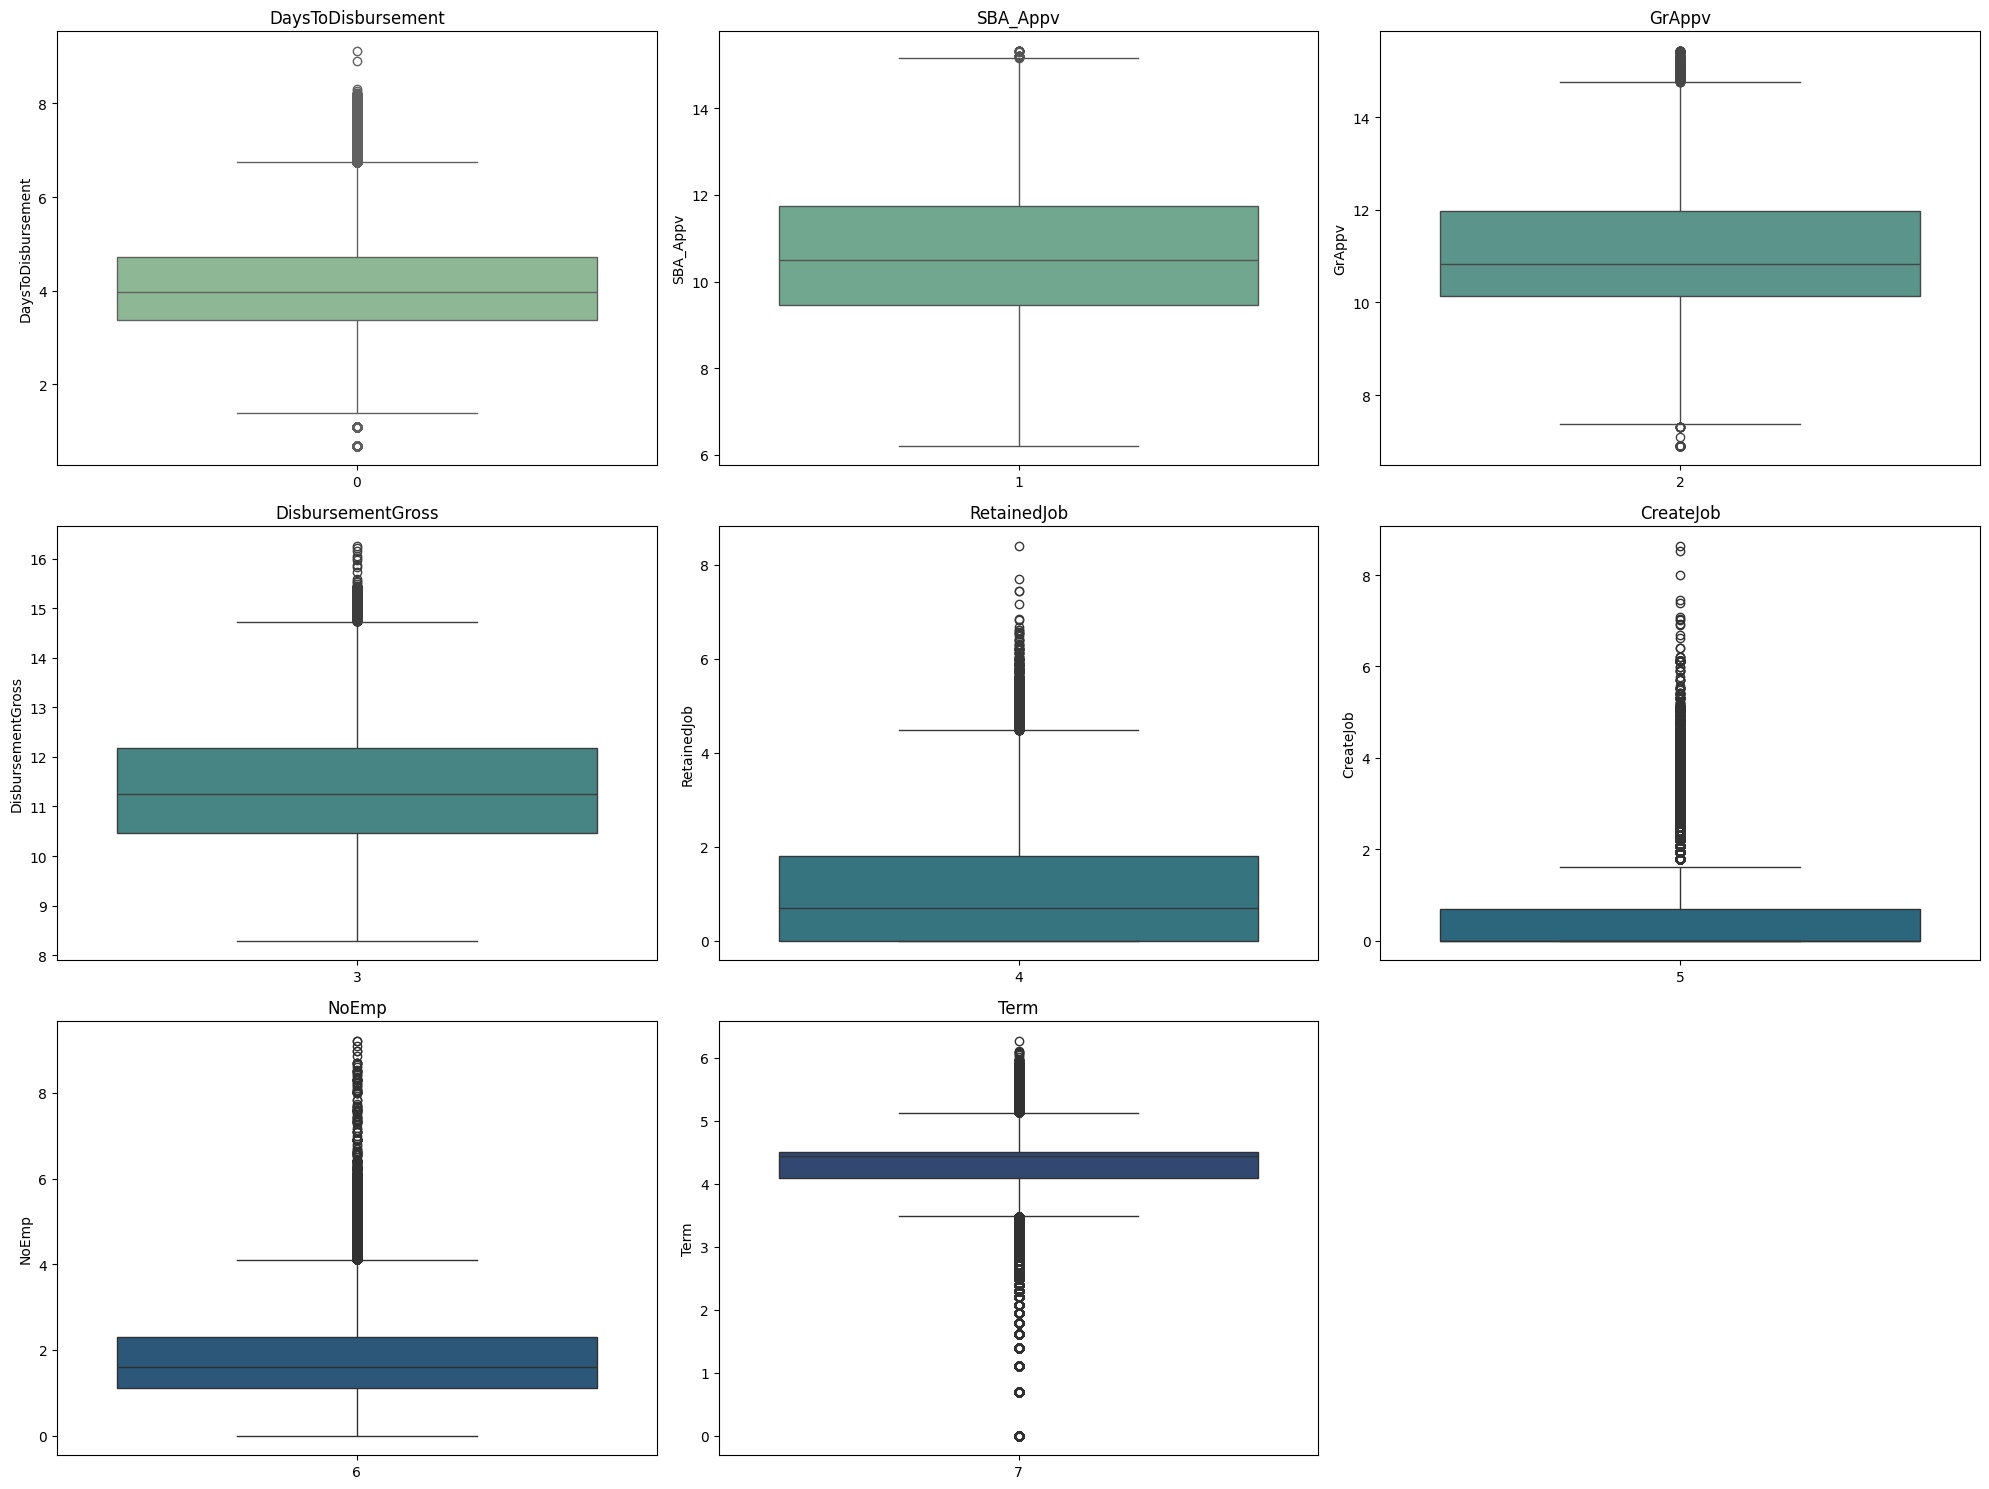

In [ ]:
outlier_plot(loans_model_df, features_transform)

Outlier spread is way improved that what I have started with in the beginning of the analysis.

### **9.5 One-Hot Encoding**

In [ ]:
# Drop features from multicollinearity test and IndustryCode, CompanySize from earlier

loans_model_df.drop(columns=['UrbanRural', 'RealEstate', 'DisbursementYear', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr', 'IndustryCode', 'CompanySize'], inplace=True)

In [ ]:
data_info(loans_model_df)

Rows,Columns (442811, 21)
Duplicated Values 151
=====



missingValue  percentMissing DataType  Unique
State                          0             0.0    int64      51
Industry                       0             0.0   object      20
GreatRecession                 0             0.0    int64       2
AppvDisbursed                  0             0.0    int64       2
SBA_AppvPercent                0             0.0  float64    5694
StateSame                      0             0.0    int64       2
DisbursementMonth              0             0.0    int64      12
DaysToDisbursement             0             0.0  float64    2178
IsFranchise                    0             0.0    int64       2
NewBusiness                    0             0.0    int64       2
BalanceGross                   0             0.0  float64       8
BankState                      0             0.0    int64      54
DisbursementGross              0             0.0  float64   98935
LowDoc                         0             0.0    int64       2
RevLineCr                      0             0.0    int64       2
RetainedJob                    0             0.0  float64     275
CreateJob                      0             0.0  float64     192
NoEmp                          0             0.0  float64     428
Term                           0             0.0  float64     373
ApprovalFY                     0             0.0    int64      29
Default                        0             0.0    int64       2

In [ ]:
loans_model_df = pd.get_dummies(loans_model_df)

In [ ]:
# One-Hot Encoding for non ranking feature fields

loans_model_df = pd.get_dummies(loans_model_df, columns=['State']).astype(int)
loans_model_df = pd.get_dummies(loans_model_df, columns=['BankState']).astype(int)
loans_model_df = pd.get_dummies(loans_model_df, columns=['RevLineCr']).astype(int)
loans_model_df = pd.get_dummies(loans_model_df, columns=['LowDoc']).astype(int)

In [ ]:
loans_model_df.head(3)

ApprovalFY  Term  NoEmp  CreateJob  RetainedJob  DisbursementGross  \
0        1997     4      1          0            0                 11   
1        1997     4      1          0            0                 10   
2        1997     5      2          0            0                 12   

   BalanceGross  NewBusiness  IsFranchise  DaysToDisbursement  ...  \
0             0            1            0                   6  ...   
1             0            1            0                   4  ...   
2             0            0            0                   5  ...   

   BankState_48  BankState_49  BankState_50  BankState_51  BankState_52  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   

   BankState_53  RevLineCr_0  RevLineCr_1  LowDoc_0  LowDoc_1  
0             0            1            0         0         1  
1             0            1            0         0         1  
2             0            1            0         1         0  

[3 rows x 145 columns]

### **9.6 Data Splitting & Feature Scaling**

In [ ]:
# Get predictors (X) and target variables (y)

X = loans_model_df.drop(columns='Default')
y = loans_model_df[['Default']]

In [ ]:
scaler = preprocessing.StandardScaler()

In [ ]:
# Scale predictors for easier training

X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# first split: train & pretest (split for validation & test)
X_train, X_pretest, y_train, y_pretest = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# second split: validation & test (validation for hyperparameter tuning)
X_val, X_test, y_val, y_test = train_test_split(X_pretest, y_pretest, test_size=0.50, random_state=42)

## **10. Modeling**

### **10.1. Logistic Regression**

In [ ]:
logreg = LogisticRegression(random_state=42)

Classification Report: 
               precision    recall  f1-score   support

           0      0.873     0.955     0.912     52039
           1      0.754     0.496     0.598     14383

    accuracy                          0.856     66422
   macro avg      0.813     0.726     0.755     66422
weighted avg      0.847     0.856     0.844     66422



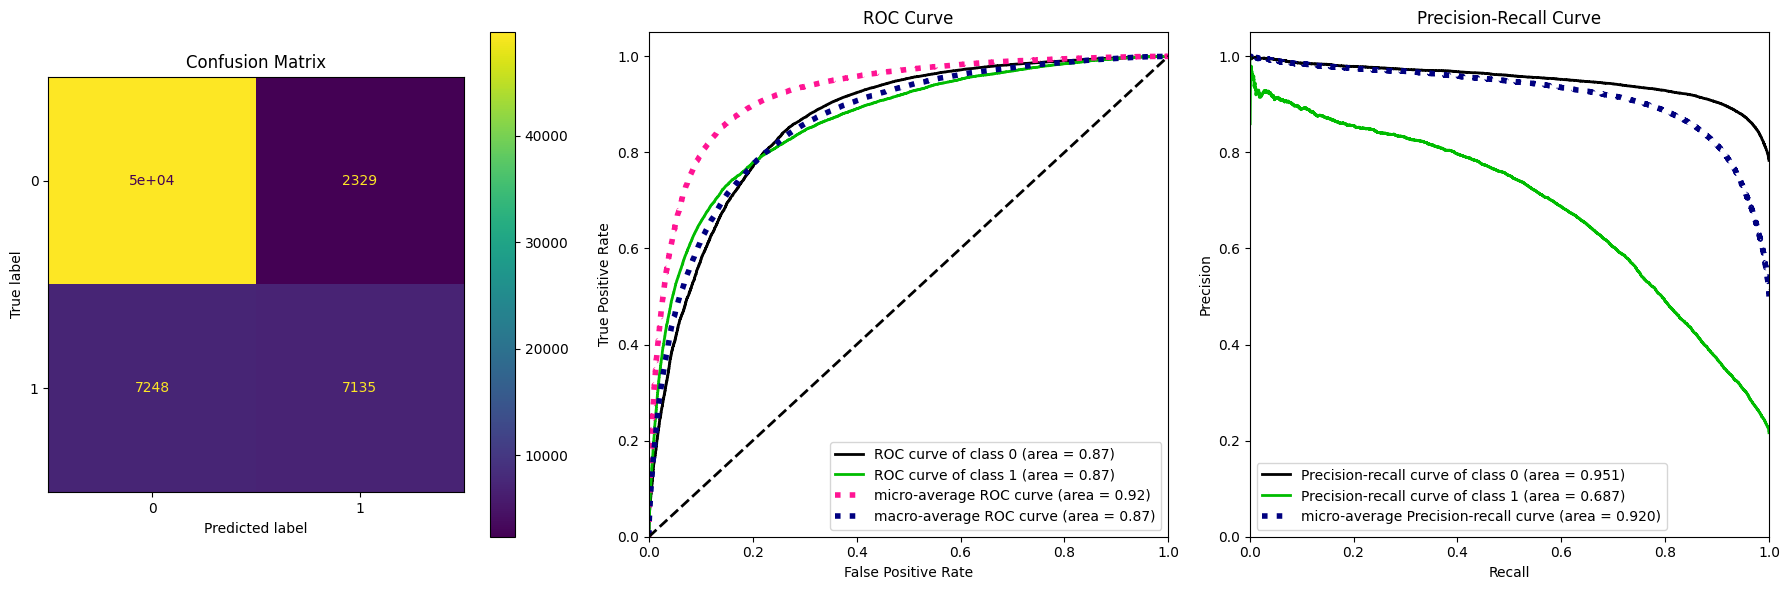

In [ ]:
eval_model(X_train, y_train, X_test, y_test, logreg)

### **10.2 K-Nearest Neighbor**

In [ ]:
knn = KNeighborsClassifier()

Classification Report: 
               precision    recall  f1-score   support

           0      0.867     0.940     0.902     52039
           1      0.686     0.478     0.563     14383

    accuracy                          0.840     66422
   macro avg      0.776     0.709     0.732     66422
weighted avg      0.828     0.840     0.828     66422



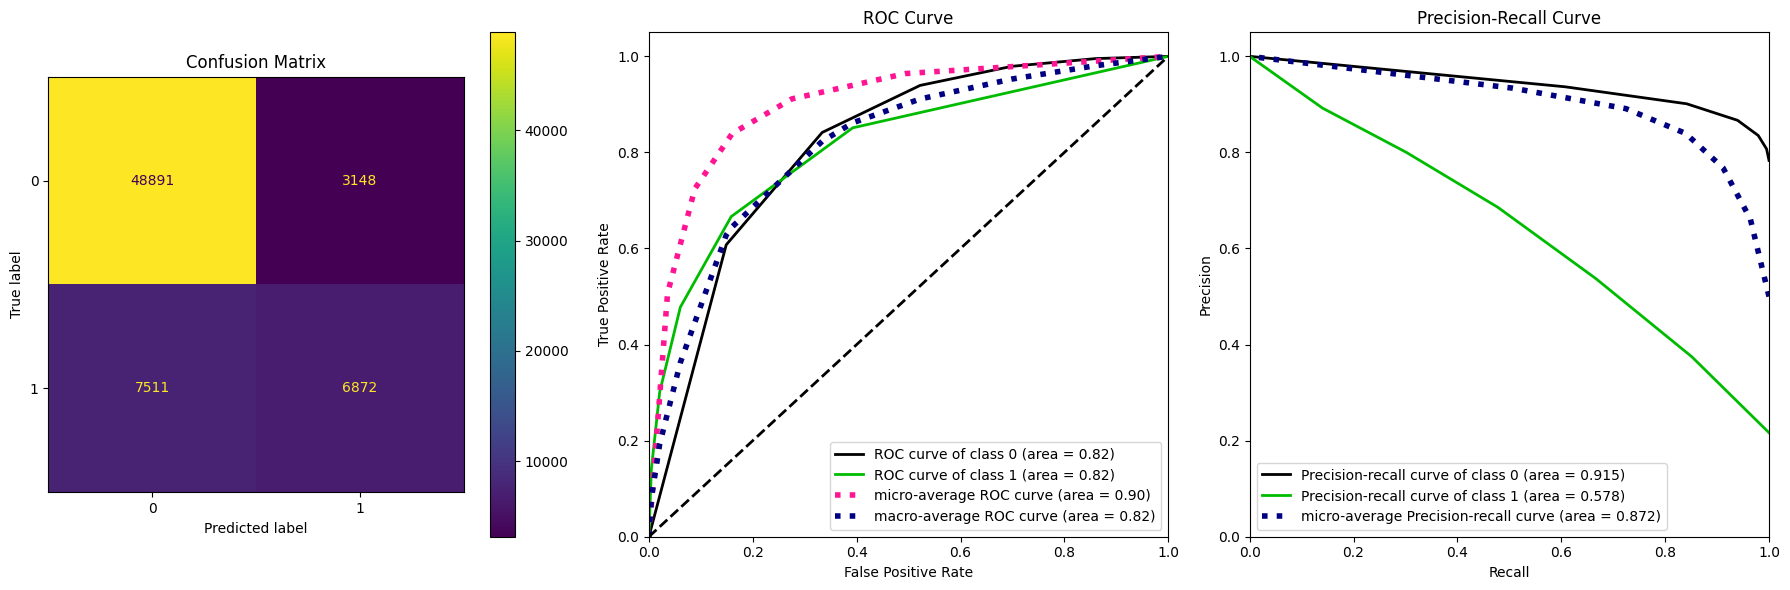

In [ ]:
eval_model(X_train, y_train, X_test, y_test, knn)

### **10.3 Random Forest**

In [ ]:
rf = RandomForestClassifier(random_state=42)

Classification Report: 
               precision    recall  f1-score   support

           0      0.910     0.965     0.937     52039
           1      0.839     0.653     0.735     14383

    accuracy                          0.898     66422
   macro avg      0.874     0.809     0.836     66422
weighted avg      0.894     0.898     0.893     66422



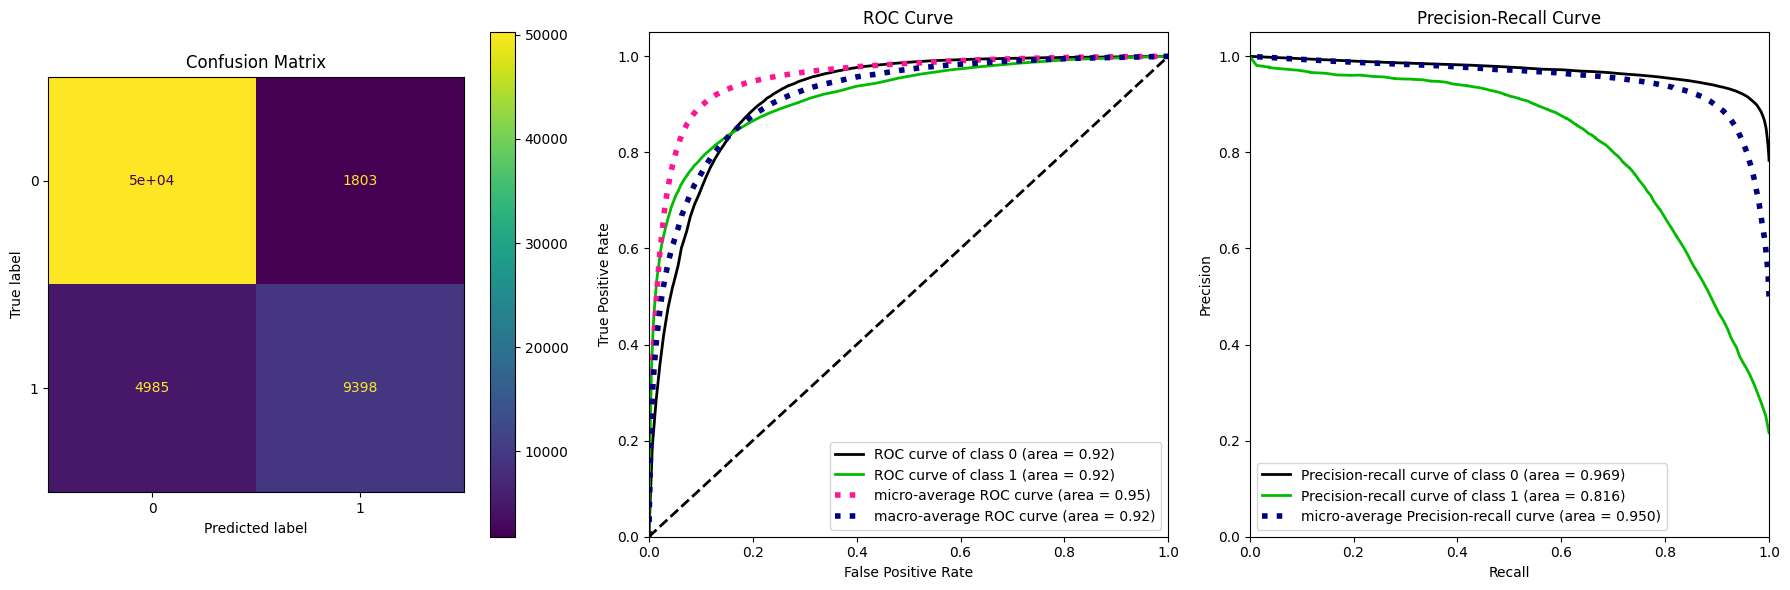

In [ ]:
eval_model(X_train, y_train, X_test, y_test, rf)

### **10.4 XGBoost**

In [ ]:
xgb = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

Classification Report: 
               precision    recall  f1-score   support

           0      0.915     0.964     0.939     52039
           1      0.840     0.675     0.748     14383

    accuracy                          0.902     66422
   macro avg      0.877     0.820     0.844     66422
weighted avg      0.899     0.902     0.898     66422



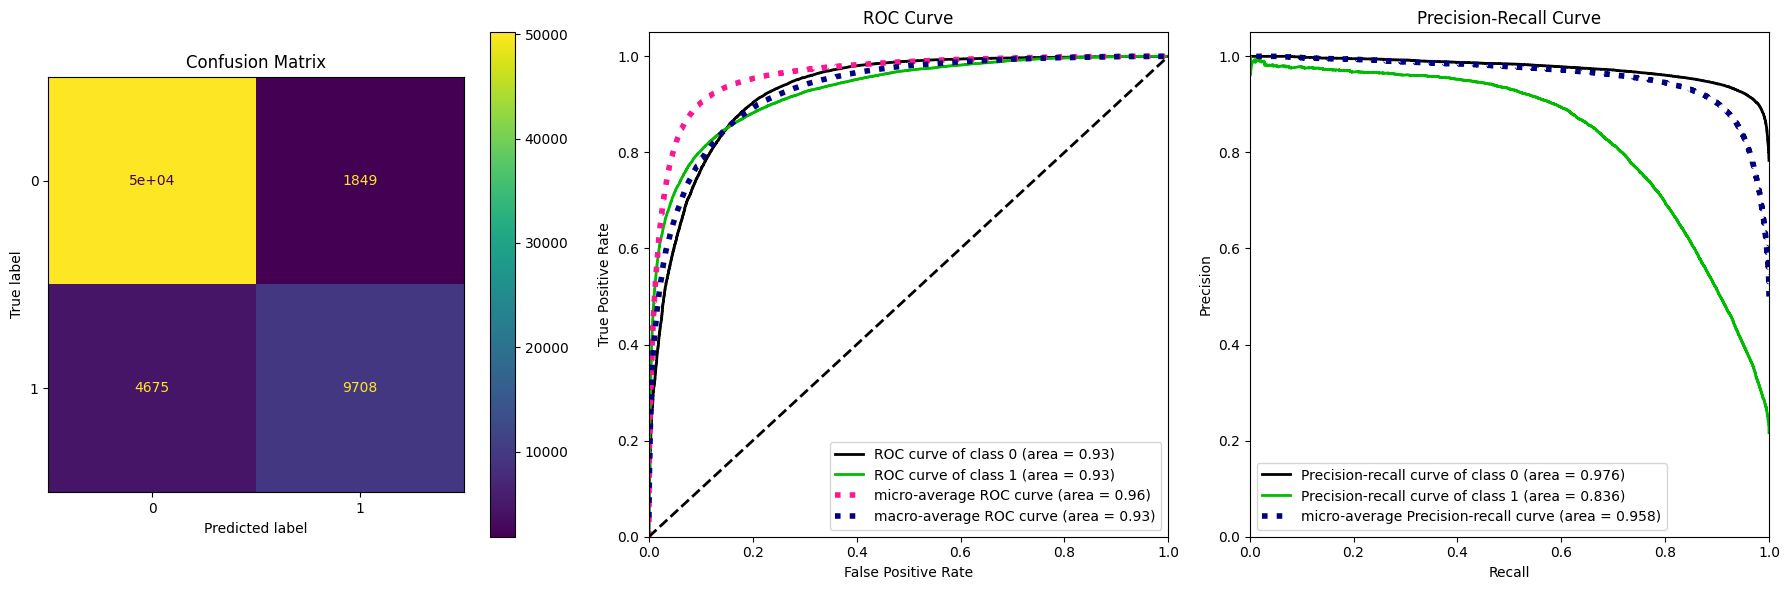

In [ ]:
eval_model(X_train, y_train, X_test, y_test, xgb)

Out of 3 models I've tested, it is a fact that XGBoost performs the most optimal out of the bunch.

### **10.5 Hyperparameter Tuning**

Here I am going to hyperparameter tune for the model choice, which is XGBoost, a few tuning parameters I've chosen based on [this blogpost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) are:
1. max_depth
2. min_child_weight
3. gamma
4. subsample
5. colsample_bytree


I will stop if there seems to be no improvements whatsoever.

#### **Tune 1**

In [ ]:
parameters = {
 'max_depth':range(3,10,2), # an interval of 2
 'min_child_weight':range(1,6,2) # an interval of 2
}

xgb_tuned_1 = GridSearchCV(xgb, parameters, cv=5, scoring='recall')
xgb_tuned_1.fit(X_val, y_val)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='recall')

In [ ]:
xgb_tuned_1.best_params_, xgb_tuned_1.best_score_

({'max_depth': 7, 'min_child_weight': 3}, 0.6782645669562571)

In [ ]:
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=7, # update max_depth to best
    min_child_weight=3, # up date min_child_weight to best
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

Classification Report: 
               precision    recall  f1-score   support

           0      0.916     0.965     0.940     52039
           1      0.841     0.680     0.752     14383

    accuracy                          0.903     66422
   macro avg      0.879     0.822     0.846     66422
weighted avg      0.900     0.903     0.899     66422



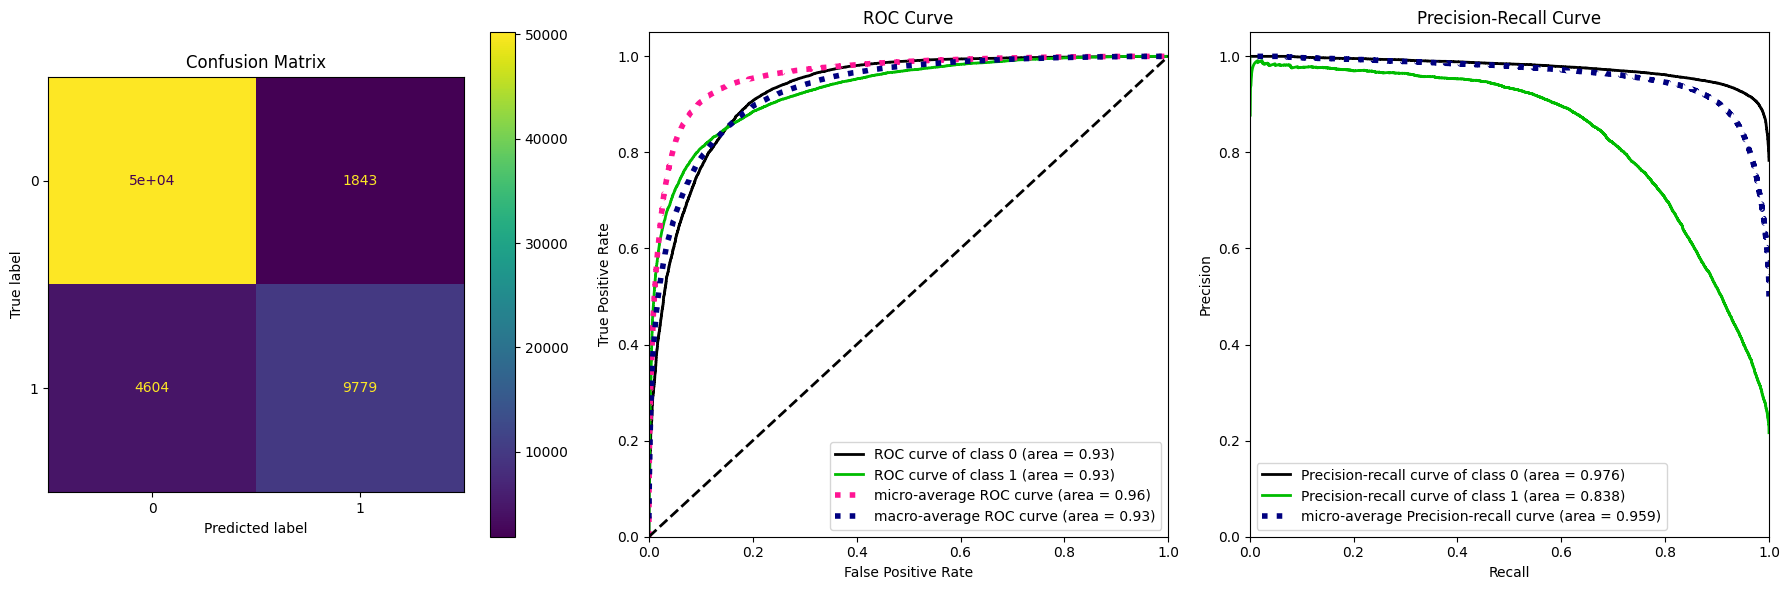

In [ ]:
eval_model(X_train, y_train, X_test, y_test, xgb2)

There is a slight improvement of 0.5% on recall and 0.4% on f1-score. we continue with using the best parameters from the tune.

#### **Tune 2**

In [ ]:
parameters = {
 'gamma':[i/10.0 for i in range(0,5)]
}

xgb_tuned_2 = GridSearchCV(xgb2, parameters, cv=5, scoring='recall')
xgb_tuned_2.fit(X_val, y_val)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}, scoring='recall')

In [ ]:
xgb_tuned_2.best_params_, xgb_tuned_2.best_score_

({'gamma': 0.3}, 0.6795789431884998)

In [ ]:
xgb3 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=3,
    gamma=0.3, # update gamma to best
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

Classification Report: 
               precision    recall  f1-score   support

           0      0.916     0.965     0.940     52039
           1      0.841     0.680     0.752     14383

    accuracy                          0.903     66422
   macro avg      0.879     0.822     0.846     66422
weighted avg      0.900     0.903     0.899     66422



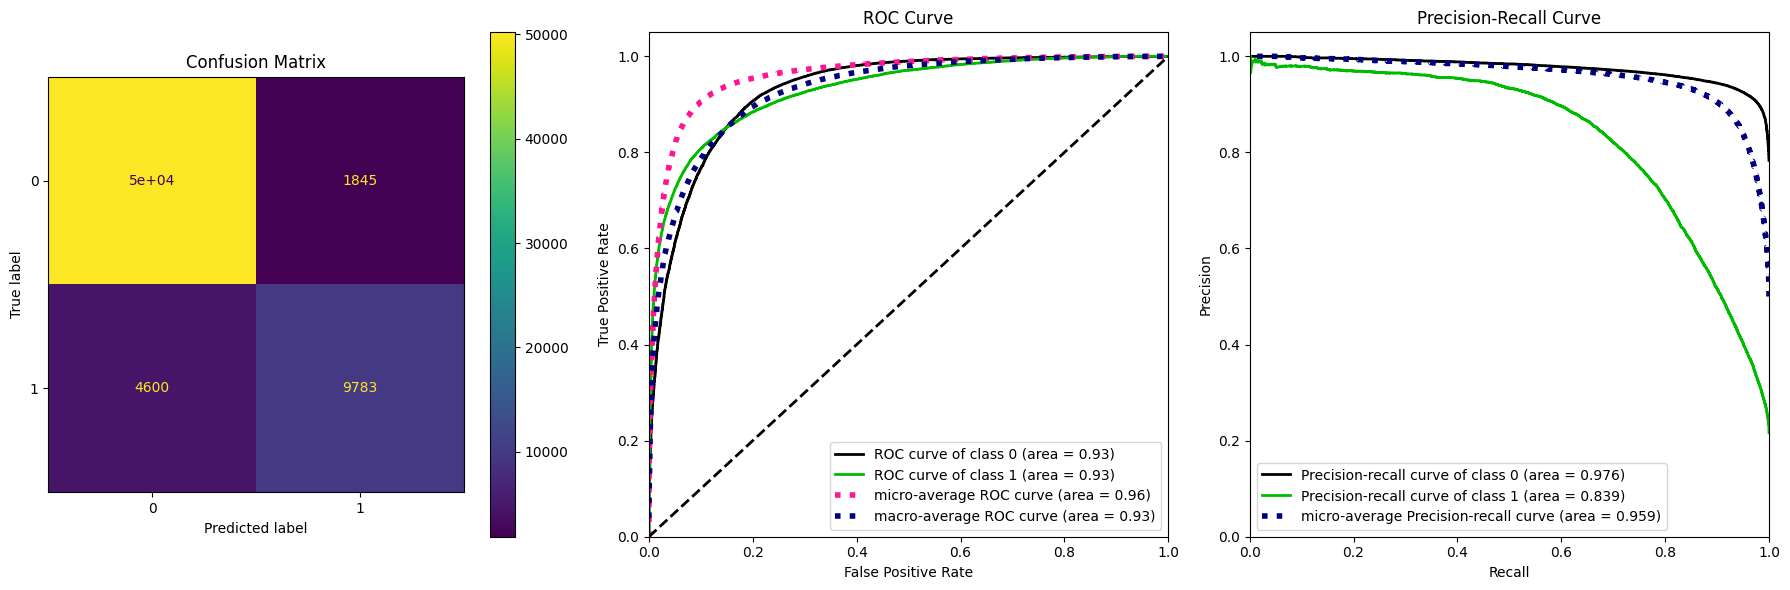

In [ ]:
eval_model(X_train, y_train, X_test, y_test, xgb3)

There has not been any change of peformance at all. But we might as well continue to see if there are any significance on the next parameters used.

#### **Tune 3**

In [ ]:
parameters = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb_tuned_3 = GridSearchCV(xgb2, parameters, cv=5, scoring='recall')
xgb_tuned_3.fit(X_val, y_val)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='recall')

In [ ]:
xgb_tuned_3.best_params_, xgb_tuned_3.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.6791641489565796)

In [ ]:
xgb4 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=3,
    gamma=0.3,
    subsample=0.9, # update subsample to best
    colsample_bytree=0.8, # remian colsample to default of 0.8
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

Classification Report: 
               precision    recall  f1-score   support

           0      0.916     0.965     0.940     52039
           1      0.841     0.680     0.752     14383

    accuracy                          0.903     66422
   macro avg      0.879     0.822     0.846     66422
weighted avg      0.900     0.903     0.899     66422



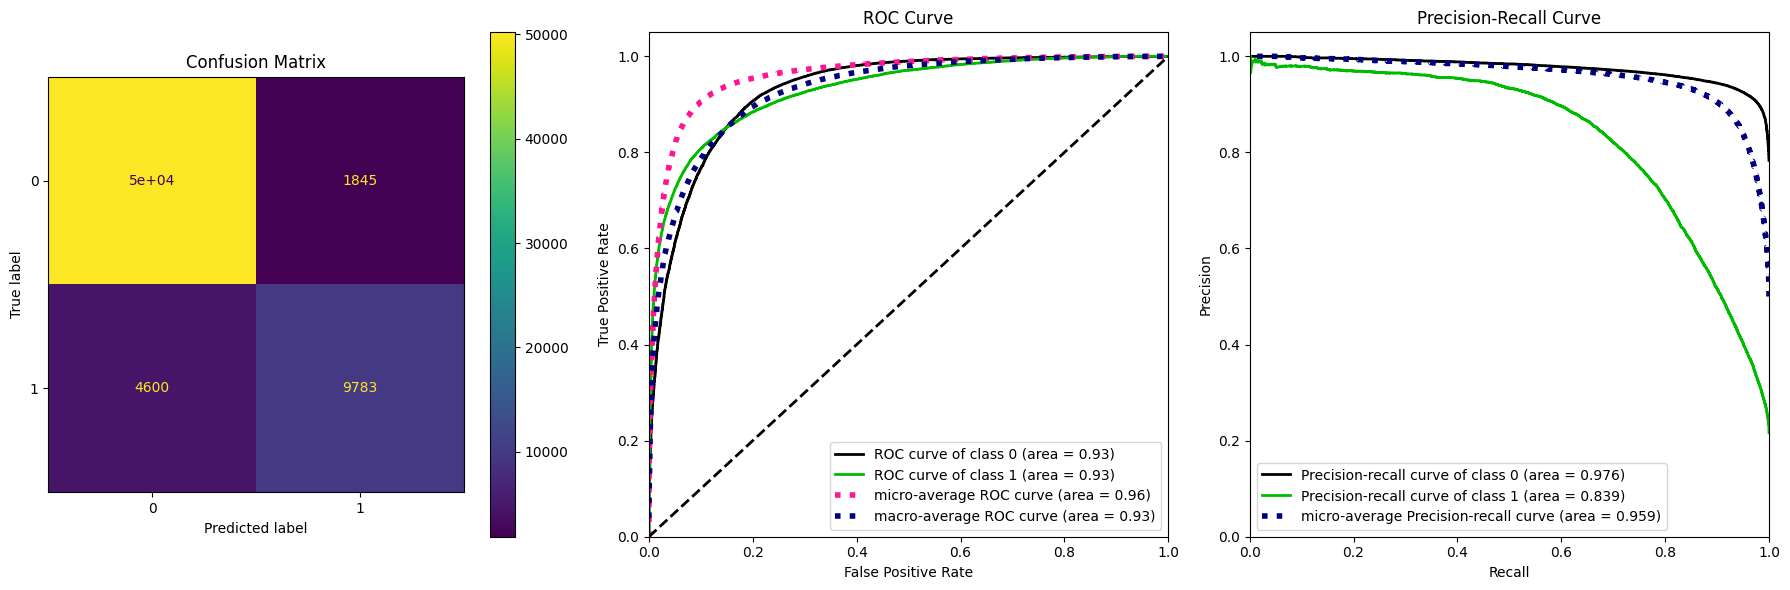

In [ ]:
eval_model(X_train, y_train, X_test, y_test, xgb3)

Again, it doesnt seem to have any improvements whatsoever, so I conclude in ending the tuning here at the max recall value of 68% and f1-score of 75.2%.

## **11. Evaluation**

#### **11.1 Feature Importance**

In [ ]:
model = xgb.fit(X_train, y_train)

coefficients = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False).reset_index(drop=True)

importance_df

Feature  Coefficient
0                                Term     0.091222
1                        BankState_23     0.048343
2                     SBA_AppvPercent     0.041123
3                           StateSame     0.040777
4                        BankState_22     0.032217
5                          ApprovalFY     0.030251
6                            State_15     0.025884
7                         RevLineCr_0     0.019547
8                         BankState_3     0.019209
9                        BankState_12     0.018177
10                       BankState_26     0.018066
11                            State_2     0.015856
12                        RevLineCr_1     0.014729
13             Industry_Health/Social     0.013656
14                       BankState_11     0.013299
15                        BankState_0     0.012881
16                      AppvDisbursed     0.012484
17                           State_42     0.012204
18                       BankState_24     0.011857
19                       BankState_41     0.011319
20                           State_39     0.010533
21                 DaysToDisbursement     0.010250
22                           State_32     0.010095
23                  DisbursementGross     0.009855
24                           State_26     0.009813
25                           State_34     0.009099
26                       BankState_14     0.008691
27                            State_6     0.008413
28                       BankState_50     0.008278
29                       BankState_17     0.008055
30                        BankState_9     0.007999
31                     GreatRecession     0.007769
32                           LowDoc_1     0.007501
33                            State_4     0.007465
34                           State_19     0.007333
35                       BankState_13     0.007302
36                           State_44     0.007286
37                           State_14     0.007113
38                           State_22     0.006787
39                        BankState_4     0.006782
40                       BankState_46     0.006545
41                           State_38     0.006538
42        Industry_Agri/For/Fish/Hunt     0.005975
43                Industry_Accom/Food     0.005930
44                        BankState_1     0.005861
45                       BankState_15     0.005823
46                        BankState_8     0.005784
47                           State_24     0.005758
48                           LowDoc_0     0.005728
49                           State_43     0.005694
50                           State_11     0.005588
51                        BankState_6     0.005504
52                           State_28     0.005467
53         Industry_Prof/Science/Tech     0.005277
54                        NewBusiness     0.005241
55                           State_33     0.005168
56                          CreateJob     0.005138
57     Industry_Real_est/Rental/Lease     0.005119
58                       BankState_30     0.004939
59                           State_17     0.004924
60                            State_3     0.004541
61                           State_35     0.004354
62              Industry_Retail_trade     0.004288
63                        BankState_5     0.004268
64                              NoEmp     0.004207
65                       BankState_10     0.003929
66                       BankState_27     0.003910
67           Industry_Wholesale_trade     0.003807
68      Industry_Min/Quar/Oil/Gas_ext     0.003677
69                        BankState_2     0.003570
70                       BankState_21     0.003504
71                           State_10     0.003481
72              Industry_Art/Entr/Rec     0.003461
73                            State_9     0.003394
74                       BankState_39     0.003381
75         Industry_Finance/Insurance     0.003374
76                       BankState_33     0.003272
77                           State_31     0.003268
7

**Observation:**

As we can see, top 5 collective features that are important to our model are `Term`, `StateSame`, `ApprovalFY`, `BankState` (some), and `SBA_AppvPercent`.

1. `Term`: The loan term can impact repayment likelihood, with longer terms posing higher risks due to economic fluctuations, while shorter terms may indicate better cash flow and financial stability. Longer terms may indicate lower monthly payments but long-term challenges, while shorter terms may indicate stronger financial position or quick capital turnover.
2. `StateSame`: Loans between businesses and banks in the same state may have different approval rates and default risks due to local economic conditions, familiarity with local businesses, and regulatory environments. Banks may prefer lending to businesses within the same state due to better understanding.
3. `ApprovalFY`: The year of approval can reflect economic cycles, lending standards, and policy shifts, affecting loan approvals and performance. Analyzing historical contexts helps understand how historical contexts influence current loan outcomes.
4. `BankState`: Bank location impacts lending practices, risk tolerance, and industry expertise. Local economic conditions and state-specific regulations influence decision-making and loan performance, with a booming state potentially having lower default rates.
5. `SBA_AppvPercent`: Higher SBA guarantees reduce lending bank risk, increasing loan approval rates. They also provide a safety net, influencing borrower behavior and loan performance, and can significantly influence loan approval rates and defaults.

Since there is a high dimensionality of features (due to one-hot encoding), I also decide to try and see if the model's performance improve if I used the most important features. I will be using SelectKBest with K=10 as default to see if there are any improvements.

In [ ]:
k_best = SelectKBest(f_classif, k=10)
fit_new = k_best.fit(X_scaled, y)
X_new = k_best.fit_transform(X_scaled, y)

selected_features = X.columns[fit_new.get_support(indices=True)].tolist()

selected_features

['ApprovalFY',
 'Term',
 'NoEmp',
 'DisbursementGross',
 'DaysToDisbursement',
 'StateSame',
 'SBA_AppvPercent',
 'AppvDisbursed',
 'GreatRecession',
 'BankState_22']

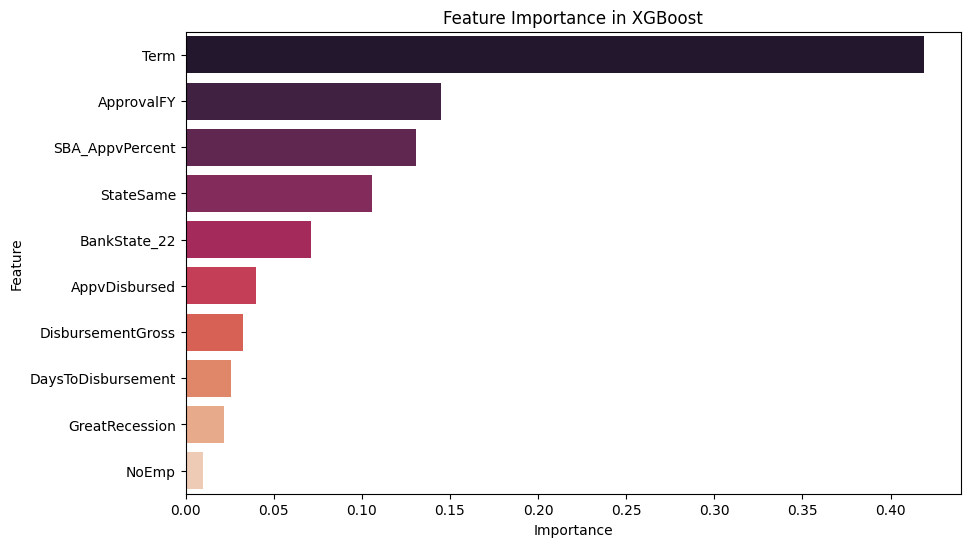

In [ ]:
# Plot feature importance based on SelectKBest features

xgb_clf = XGBClassifier(random_state=2)
xgb_clf.fit(X_new, y)

importances = xgb_clf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
plt.title('Feature Importance in XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Observation:**

After we've reduced feature dimensionality, we can see that `GreatRecession`, and `NoEmp` come up.

1. The Great Recession period significantly influenced loan approvals, potentially affecting default rates, thereby strengthening the hypothesis about ApprovalFY.
2. NoEmp feature indicates that smaller businesses or sole proprietorships with fewer employees are more susceptible to financial instability and loan defaults. The number of employees can indicate a business's size and stability, as smaller operations may lack the financial resources to weather economic downturns or operational challenges.

## **12. Conclusion**

Out of the models I've tested, I've concluded that implementing XGBoost(tuned-1) has the best performance. It has a recall score of 68% and an F1-score of 75.2%. This means the model has a 68% hit rate for predicting whether a loan will default or not and maintains a good balance between precision and recall, as indicated by the 75.2% F1-score, despite the data being imbalanced.

For example, if 100 businesses apply for a 100,000 loan. the bank will have to finance 10,000,000. If all these loans have the potential to default, this model can help prevent 66 defaults, potentially reducing costs by up to 6,800,000.

## **13. Business Recommendations**

To prevent more defaults, the SBA need to filter loan applications more thoroughly. Here are some recommendations to consider:

1. Examine and strengthen the requirements for loan approvals, particularly for high-risk sectors including construction, retail trade, and professional/scientific/technical services.
2. Use business information, such as cash flow and transaction history, to improve credit score.
3. Keep a close eye on the borrowers' financial situation after payments are made in order to spot any early warning indications of possible defaults.
4. To lessen the lender's liability, demand collateral or personal guarantees for loans with higher risk.
5. Banks and lenders with loose regulations can either tighten their regulations or reduce their approval guarantee rate.